In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import time
import sklearn
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from tabulate import tabulate
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier

evaluate={'Acc':"Accuracy", 'b_Acc':"Balanced Accuracy", 'F1':"F1 Score", 'kap':"Kappa", 'ROC':"Roc"}

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost

In [4]:
def GA(train,test,cols,gen_number=25,outputcsv="GA_output.csv"):
    #defining various steps required for the genetic algorithm
    # GA adapted from https://datascienceplus.com/genetic-algorithm-in-machine-learning-using-python/
    def initilization_of_population(size,n_feat):
        population = []
        for i in range(size):
            chromosome = np.ones(n_feat,dtype=np.bool)
            chromosome[:int(0.3*n_feat)]=False
            np.random.shuffle(chromosome)
            population.append(chromosome)
        return population

    def fitness_score(population):
        scores = []
        for chromosome in population:
            logmodel.fit(X_train.iloc[:,chromosome],y_train)
            predictions = logmodel.predict(X_test.iloc[:,chromosome])
            scores.append(sklearn.metrics.f1_score(y_test,predictions,average= "macro"))
        scores, population = np.array(scores), np.array(population) 
        inds = np.argsort(scores)
        return list(scores[inds][::-1]), list(population[inds,:][::-1])

    def selection(pop_after_fit,n_parents):
        population_nextgen = []
        for i in range(n_parents):
            population_nextgen.append(pop_after_fit[i])
        return population_nextgen

    def crossover(pop_after_sel):
        population_nextgen=pop_after_sel
        for i in range(len(pop_after_sel)):
            child=pop_after_sel[i]
            child[3:7]=pop_after_sel[(i+1)%len(pop_after_sel)][3:7]
            population_nextgen.append(child)
        return population_nextgen

    def mutation(pop_after_cross,mutation_rate):
        population_nextgen = []
        for i in range(0,len(pop_after_cross)):
            chromosome = pop_after_cross[i]
            for j in range(len(chromosome)):
                if random.random() < mutation_rate:
                    chromosome[j]= not chromosome[j]
            population_nextgen.append(chromosome)
        #print(population_nextgen)
        return population_nextgen

    def generations(size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                       X_test, y_train, y_test):

        best_chromo= []
        best_score= []
        population_nextgen=initilization_of_population(size,n_feat)
        for i in range(n_gen):
            second=time.time()
            scores, pop_after_fit = fitness_score(population_nextgen)
            #print(scores[:2])
            zaman=time.time()-second

            ths.write(f"{np.mean(scores)},{np.mean(scores)},{zaman}\n")
            


            pop_after_sel = selection(pop_after_fit,n_parents)
            pop_after_cross = crossover(pop_after_sel)
            population_nextgen = mutation(pop_after_cross,mutation_rate)
            best_chromo.append(pop_after_fit[0])
            best_score.append(scores[0])
        return best_chromo,best_score
    
    



    df = pd.read_csv(train,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_train =df[df.columns[0:-1]]
    #X_train=np.array(X_train)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_train=df[df.columns[-1]].cat.codes  
    df = pd.read_csv(test,usecols=cols)#,header=None )
    df=df.fillna(0)
    #df = df.sample(n = 10000)
    X_test =df[df.columns[0:-1]]
    #X_test=np.array(X_test)
    df[df.columns[-1]] = df[df.columns[-1]].astype('category')
    y_test=df[df.columns[-1]].cat.codes  

    
    ths = open(f"./{outputcsv}", "w")
    ths.write("MEAN,STD,TIME\n")
    logmodel=DecisionTreeClassifier()
    #print ('%-30s %-30s %-30s' % ("MEAN","STD","TIME"))
    chromo,score=generations(size=200,n_feat=X_train.shape[1],n_parents=120,mutation_rate=0.005,
                         n_gen=gen_number,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test)
    #logmodel.fit(X_train.iloc[:,chromo[-1]],y_train)
    #predictions = logmodel.predict(X_test.iloc[:,chromo[-1]])
    #print("F1 Score score after genetic algorithm is= "+str(sklearn.metrics.f1_score(y_test,predictions,average= "macro")))
    ths.close()
    sonuç=[]
    for k,j in enumerate(chromo):
        temp=X_train.iloc[:,j]
        temp=list(temp.columns)
        temp.append("Label")
        sonuç.append(temp)
    
    np.save(outputcsv.replace("csv","npy"), sonuç)
    gf = pd.read_csv(outputcsv)
    gf=gf["MEAN"].values
    gf=np.argmax(gf) 
    return sonuç[gf],gf

In [5]:
def folder(f_name): #this function creates a folder named "attacks" in the program directory.
    try:
        if not os.path.exists(f_name):
            os.makedirs(f_name)
    except OSError:
        print ("The folder could not be created!")

In [6]:
def find_the_way(path,file_format,con=""):
    files_add = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if file_format in file:
                if con in file:
                    files_add.append(os.path.join(r, file))  
    return files_add

In [7]:
ml_list={"LR":{"SYN":LogisticRegression(C=59.8441,penalty="l1",solver="liblinear" ),
               "HTTP":LogisticRegression(C=0.0463841 ,penalty="l2",solver="lbfgs" ),
               "ACK":LogisticRegression(C=0.204882 ,penalty="l2",solver="lbfgs" ),    
               "UDP":LogisticRegression(C=74.8807,penalty="none",solver="lbfgs" ),    
               "ARP":LogisticRegression(C=74.5065 ,penalty="l1",solver="liblinear" ),
               "SP":LogisticRegression(C=2.45721 ,penalty="none",solver="lbfgs" ),    
               "BF":LogisticRegression(C=27.4817 ,penalty="l1",solver="liblinear" ),    
               "OS":LogisticRegression(C= 29.4052,penalty="l1",solver="liblinear" ),
               "SCHD":LogisticRegression(C=0.820152,penalty="none",solver="lbfgs" ),    
               "MHDis":LogisticRegression(C=0.000453162,penalty="none",solver="lbfgs" )},   

"DT":{"SYN":DecisionTreeClassifier(criterion="gini",max_depth=6,max_features=10,min_samples_split=2 ),
"HTTP":DecisionTreeClassifier(criterion="gini",max_depth=6,max_features=10,min_samples_split=3 ),                      
"ACK":DecisionTreeClassifier(criterion="entropy",max_depth=3,max_features=4,min_samples_split=4),            
"UDP":DecisionTreeClassifier(criterion="gini",max_depth=5,max_features=20,min_samples_split=6 ),            
"ARP":DecisionTreeClassifier(criterion="gini",max_depth=17,max_features=51,min_samples_split=2 ),            
"SP":DecisionTreeClassifier(criterion="entropy",max_depth=6,max_features=6,min_samples_split=2 ),            
"BF":DecisionTreeClassifier(criterion="entropy",max_depth=6,max_features=21,min_samples_split=3 ),              
"OS":DecisionTreeClassifier(criterion="entropy",max_depth=1,max_features=53,min_samples_split=4 ),            
"SCHD":DecisionTreeClassifier(criterion="entropy",max_depth=4,max_features=26,min_samples_split=9 ),             
"MHDis":DecisionTreeClassifier(criterion="gini",max_depth=7,max_features=12,min_samples_split=9 )},
         
               
    
"RF":{"SYN":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=7,max_features=8,min_samples_split=2,n_estimators=98),
"HTTP":RandomForestClassifier(bootstrap=True,criterion="gini",max_depth=7,max_features=9,min_samples_split=2,n_estimators=73),                      
"ACK":RandomForestClassifier(bootstrap=True,criterion="entropy",max_depth=8,max_features=7,min_samples_split=8,n_estimators=55 ),            
"UDP":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=14,max_features=3,min_samples_split=3,n_estimators=35 ),            
"ARP":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=17,max_features=9,min_samples_split=2,n_estimators=140),            
"SP":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=8,max_features=7,min_samples_split=2,n_estimators=1),            
"BF":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=5,max_features=9,min_samples_split=9,n_estimators=138 ),      
"OS":RandomForestClassifier(bootstrap=False,criterion="entropy",max_depth=5,max_features=2,min_samples_split=6,n_estimators=3),            
"SCHD":RandomForestClassifier(bootstrap=False,criterion="gini",max_depth=13,max_features=9,min_samples_split=7,n_estimators=73),             
"MHDis":RandomForestClassifier(bootstrap=True,criterion="gini",max_depth=11,max_features=3,min_samples_split=5,n_estimators=75)},
         

    
"KNN":{"SYN":KNeighborsClassifier(algorithm="kd_tree",leaf_size=27,n_neighbors=11,weights="distance"),
"HTTP":KNeighborsClassifier(algorithm="ball_tree",leaf_size=40,n_neighbors=2,weights="distance"),                     
"ACK":KNeighborsClassifier(algorithm="auto",leaf_size=13,n_neighbors=1,weights="distance"),        
"UDP":KNeighborsClassifier(algorithm="ball_tree",leaf_size=45,n_neighbors=9,weights="uniform"),       
"ARP":KNeighborsClassifier(algorithm="kd_tree",leaf_size=10,n_neighbors=2,weights="distance"),         
"SP":KNeighborsClassifier(algorithm="auto",leaf_size=33,n_neighbors=1,weights="distance"),         
"BF":KNeighborsClassifier(algorithm="auto",leaf_size=10,n_neighbors=9,weights="distance"),    
"OS":KNeighborsClassifier(algorithm="brute",leaf_size=7,n_neighbors=10,weights="distance"),         
"SCHD":KNeighborsClassifier(algorithm="kd_tree",leaf_size=21,n_neighbors=1,weights="distance"),        
"MHDis":KNeighborsClassifier(algorithm="ball_tree",leaf_size=46,n_neighbors=1,weights="uniform")}
,


         
"SVM":{"SYN":SVC(gamma=1,C=10),
"HTTP":SVC(gamma=1,C=1),                  
"ACK":SVC(gamma=1,C=10),
"UDP":SVC(gamma=0.1,C=10),   
"ARP":SVC(gamma=0.01,C=1),       
"SP":SVC(gamma=1 ,C=1),      
"BF":SVC(gamma=0.01,C=10),  
"OS":SVC(gamma=0.01 ,C=10),
"SCHD":SVC(gamma=1,C=10),     
"MHDis":SVC(gamma=0.1,C=1)},
       

         
"MLP":{"SYN":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1184,433), alpha= 0.05, activation='relu'),
"HTTP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (439, ),  alpha= 0.0001, activation='relu'),             
"ACK":MLPClassifier(solver= 'lbfgs', learning_rate= 'adaptive', hidden_layer_sizes= (1193, 630),  alpha= 0.05, activation='tanh'),
"UDP":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1391,1912),  alpha= 0.0001, activation='relu'),
"ARP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1015, ),  alpha= 0.1, activation='relu'),    
"SP":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes=  (851,318),  alpha= 0.0001, activation='relu'), 
"BF":MLPClassifier(solver= 'adam', learning_rate= 'adaptive', hidden_layer_sizes= (1129,732), alpha= 0.001, activation='relu'),
"OS":MLPClassifier(solver= 'lbfgs', learning_rate= 'constant', hidden_layer_sizes= (851,318), alpha= 0.01, activation='tanh'),
"SCHD":MLPClassifier(solver= 'lbfgs', learning_rate= 'adaptive', hidden_layer_sizes= (310,1163), alpha= 0.1, activation='tanh'),
"MHDis":MLPClassifier(solver= 'adam', learning_rate= 'constant', hidden_layer_sizes= (1568,1928), alpha= 0.01, activation='tanh')},
                
         
"NB":{"SYN":GaussianNB(var_smoothing=1.23285e-09),
"HTTP":GaussianNB(var_smoothing=1e-09 ),                  
"ACK":GaussianNB(var_smoothing= 2.84804e-07),
"UDP":GaussianNB(var_smoothing=1.23285e-09),  
"ARP":GaussianNB(var_smoothing=1.23285e-08),    
"SP":GaussianNB(var_smoothing=1e-09 ),      
"BF":GaussianNB(var_smoothing= 0.053367),  
"OS":GaussianNB(var_smoothing=1e-09 ),
"SCHD":GaussianNB(var_smoothing=0.00432876 ),  
"MHDis":GaussianNB(var_smoothing=1e-09)},
         
         
        "XGB":{"SYN":xgboost.XGBClassifier(n_estimators=1500,min_child_weight=4,max_depth=2,learning_rate=0.2),
               "HTTP":xgboost.XGBClassifier(n_estimators=900,min_child_weight=3,max_depth=2,learning_rate=0.15),
               "ACK":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=1,max_depth=2,learning_rate=0.15),    
               "UDP":xgboost.XGBClassifier(n_estimators=900,min_child_weight=2,max_depth=2,learning_rate=0.15),
               "ARP":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=3,max_depth=2,learning_rate=0.2),
               "SP":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=1,max_depth=3,learning_rate=0.2),    
               "BF":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=4,max_depth=2,learning_rate=0.05),   
               "OS":xgboost.XGBClassifier(n_estimators=100,min_child_weight=3,max_depth=2,learning_rate=0.15),
               "SCHD":xgboost.XGBClassifier(n_estimators=100,min_child_weight=2,max_depth=2,learning_rate=0.1),  
               "MHDis":xgboost.XGBClassifier(n_estimators=1100,min_child_weight=2,max_depth=2,learning_rate=0.15),
              }}


In [8]:
def target_name(name):
    df = pd.read_csv(name,usecols=["Label"])
    target_names=sorted(list(df["Label"].unique()))
    return target_names

In [9]:
folder("results")
folder("pdfs")
folder("results/fin")
folder("models")


## Calculation of evaluations

In [10]:
def score(train_time,test_time,predict,y_test,class_based_results,repeat,cv,dname,ml,sw):
    train_time=train_time[0]
    test_time=test_time[0]
    rc=sklearn.metrics.recall_score(y_test, predict,average= "macro")
    pr=sklearn.metrics.precision_score(y_test, predict,average= "macro")
    f_1=sklearn.metrics.f1_score(y_test, predict,average= "macro")     
    accuracy=sklearn.metrics.accuracy_score(y_test, predict)
    accuracy_b=sklearn.metrics.balanced_accuracy_score( y_test,predict)
    kappa=sklearn.metrics.cohen_kappa_score(y_test, predict,labels=None, weights=None, sample_weight=None)
    try:
        roc=sklearn.metrics.roc_auc_score(y_test, predict)
    except:roc=0
    report = sklearn.metrics.classification_report(y_test, predict, target_names=target_names,output_dict=True)
    cr = pd.DataFrame(report).transpose()
    line=[dname,sw,repeat,cv,ml,accuracy,accuracy_b,pr,rc,f_1,kappa,roc,train_time,test_time]

    if class_based_results.empty:
        class_based_results =cr
    else:
        class_based_results = class_based_results.add(cr, fill_value=0)
    return class_based_results,line

In [11]:
def ML_CV(loop1,loop2,output_csv1,cols,dname,sw):
    fold=5
    repetition=2
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            rnd = random()
            
            kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            ##df = df.reset_index(drop=True)
            df=df.fillna(0)

            #del df["MAC"] # if dataset has MAC colomn please uncomment this line
            X =df[df.columns[0:-1]]
            X=np.array(X)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y=df[df.columns[-1]].cat.codes  
            X.shape
            for train_index, test_index in kfold.split(X):
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]  



                #dname=loop1  [6:-13]  
                results_y=[]
                cv+=1
                results_y.append(y_test)


                precision=[]
                recall=[]
                f1=[]
                accuracy=[]
                train_time=[]
                test_time=[]
                total_time=[]
                kappa=[]
                accuracy_b=[]

                    #machine learning algorithm is applied in this section
                clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
                second=time.time()
                clf.fit(X_train, y_train)
                train_time.append(float((time.time()-second)) )
                second=time.time()
                predict =clf.predict(X_test)
                test_time.append(float((time.time()-second)) )

                altime=0
                class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
                lines.append(line)
                df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
                if cm.empty:
                    cm =df_cm
                else:
                    cm = cm.add(df_cm, fill_value=0)

                if line[9]>max_f1:
                    max_f1=line[9]
                    pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))

        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


In [12]:
def ML(loop1,loop2,output_csv1,cols,dname,sw):
    fold=1
    repetition=10
    for ii in ml_list:
        output_csv=output_csv1.replace("ML",ii)
        class_based_results=pd.DataFrame()#"" #pd.DataFrame(0, index=np.arange((len(target_names)+3)), columns=["f1-score","precision","recall","support"])
        cm=pd.DataFrame()
        cv=0
        lines=[["Dataset","SW","T","CV","ML","Acc","b_Acc","Prec","Rec","F1","kap","ROC","tra-T","test-T"]]
        max_f1=0
        for i in range(repetition):

            #rnd = random()
            
            #kfold = sklearn.model_selection.KFold(n_splits=fold, shuffle=True, random_state=int(rnd*100))  
            cv=0
            df = pd.read_csv(loop1,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_train =df[df.columns[0:-1]]
            X_train=np.array(X_train)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_train=df[df.columns[-1]].cat.codes  


            df = pd.read_csv(loop2,usecols=cols)#,header=None )
            df=df.fillna(0)
            X_test =df[df.columns[0:-1]]
            X_test=np.array(X_test)
            df[df.columns[-1]] = df[df.columns[-1]].astype('category')
            y_test=df[df.columns[-1]].cat.codes  




            #dname=loop1  [6:-13]  
            results_y=[]
            cv+=1
            results_y.append(y_test)


            precision=[]
            recall=[]
            f1=[]
            accuracy=[]
            train_time=[]
            test_time=[]
            total_time=[]
            kappa=[]
            accuracy_b=[]

                #machine learning algorithm is applied in this section
            clf = ml_list[ii][dname]#choose algorithm from ml_list dictionary
            second=time.time()
            clf.fit(X_train, y_train)
            train_time.append(float((time.time()-second)) )
            second=time.time()
            predict =clf.predict(X_test)
            test_time.append(float((time.time()-second)) )

            altime=0
            class_based_results,line=score(train_time,test_time,predict,y_test,class_based_results,cv,i,dname,ii,sw)
            lines.append(line)
            df_cm = pd.DataFrame(sklearn.metrics.confusion_matrix(y_test, predict))
            if cm.empty:
                cm =df_cm
            else:
                cm = cm.add(df_cm, fill_value=0)

            if line[9]>max_f1:
                max_f1=line[9]
                pickle.dump(clf, open(f'./models/{ii}_{dname}_{sw}_model.pkl', 'wb'))
                
        
        class_based_results=class_based_results/(repetition*fold)
        results = pd.DataFrame (lines[1:], columns = lines[0])
        results.to_csv(output_csv.replace("ML",ii),index=False)
        results=results.round(3)
        print (tabulate(results, headers=list(results.columns)))
        print()
        
        print (tabulate(class_based_results, headers=list(class_based_results.columns)))
        class_based_results.to_csv(output_csv.replace(".csv","class_based_results.csv"))
        if True:
            cm=cm//(repetition*fold)
            graph_name=output_csv[:-4]+"_confusion matrix.pdf"   
            plt.figure(figsize = (5,3.5))
            sns.heatmap(cm,xticklabels=target_names, yticklabels=target_names, annot=True, fmt='g')
            plt.savefig(graph_name,bbox_inches='tight')#, dpi=400)
            plt.show()
            #print(cm)
            print("\n\n\n")             


# GA output

In [13]:
import json
with open('GA_output_ET.json', 'r') as fp:
    feature_list = json.load(fp)

# CV

In [14]:
file_list={'./INPUT/SW/DoS-SYN-1.csv':"SYN",
'./INPUT/SW/MB-HTTP-4.csv':"HTTP",
'./INPUT/SW/MB-ACK-4.csv':"ACK",
'./INPUT/SW/MB-UDP-4.csv':"UDP",
'./INPUT/SW/MitM-ARP-6.csv':"ARP",
'./INPUT/SW/Scan-Port-3.csv':"SP",
'./INPUT/SW/MB-BF-5.csv':"BF",
'./INPUT/SW/Scan-OS-3.csv':"OS",  
'./INPUT/SW/Scan-HDis-3.csv':"SCHD",
'./INPUT/SW/MB-HDis-3.csv':"MHDis"}

./INPUT/SW/DoS-SYN-1.csv
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0.063      0
 1  SYN           0    2     0  LR    1        1       1      1      1      0.999  1        0.079      0
 2  SYN           0    3     0  LR    1        1       1      1      1      1      1        0.091      0.0

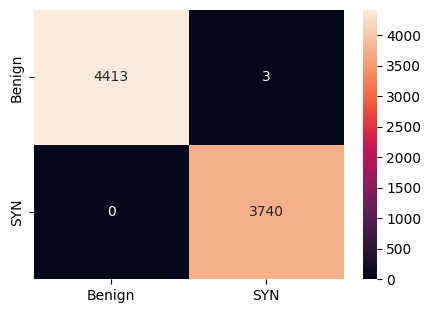





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    1        1       1      1      1      1      1        0.034     0
 1  SYN           0    2     0  DT    1        1       0.999  1      1      0.999  1        0.031     0.009
 2  SYN           0    3     0  DT    1        1       1      1      1      1      1        0.047     0
 3  SYN           0    4     0  DT    1        1       0.999  1      1      0.999  1        0.031     0
 4  SYN           0    5     0  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0.031     0
 5  SYN           0    1     1  DT    1        1       0.999  1      1      0.999  1        0.023     0
 6  SYN           0    2     1  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0.032     0
 7  SYN           0    3     1  DT    1        1

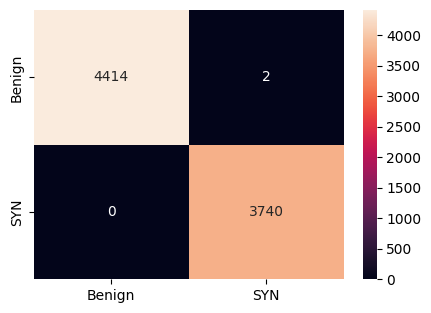





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF    1        1       0.999  1      1      0.999  1        2.131     0.08
 1  SYN           0    2     0  RF    1        1       1      1      1      1      1        2.12      0.081
 2  SYN           0    3     0  RF    1        1       1      1      1      1      1        2.178     0.078
 3  SYN           0    4     0  RF    0.999    0.999   0.999  0.999  0.999  0.999  0.999    2.123     0.096
 4  SYN           0    5     0  RF    1        1       1      1      1      0.999  1        1.907     0.041
 5  SYN           0    1     1  RF    0.999    0.999   0.999  0.999  0.999  0.999  0.999    2.203     0.095
 6  SYN           0    2     1  RF    1        1       1      1      1      1      1        2.192     0.091
 7  SYN           0    3 

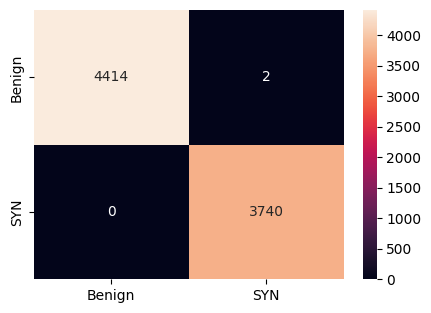





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  KNN   0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.158     3.269
 1  SYN           0    2     0  KNN   0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.181     3.245
 2  SYN           0    3     0  KNN   0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.184     3.366
 3  SYN           0    4     0  KNN   0.999    0.999   0.999  0.999  0.999  0.999  0.999    0.188     3.279
 4  SYN           0    5     0  KNN   1        1       1      1      1      0.999  1        0.178     3.24
 5  SYN           0    1     1  KNN   0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.172     3.244
 6  SYN           0    2     1  KNN   0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.171     3.29
 7  SYN           0    3  

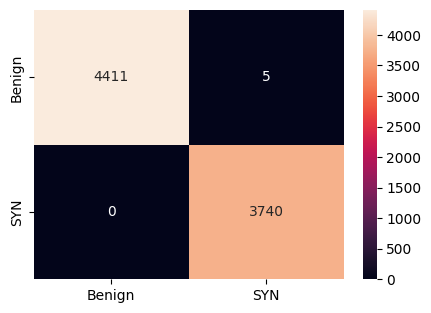





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.993    0.993   0.993  0.993  0.993  0.986  0.993    0.016     0.016
 1  SYN           0    2     0  NB    0.994    0.994   0.993  0.994  0.994  0.987  0.994    0.016     0
 2  SYN           0    3     0  NB    0.995    0.995   0.994  0.995  0.995  0.989  0.995    0.031     0
 3  SYN           0    4     0  NB    0.994    0.994   0.993  0.994  0.994  0.987  0.994    0.016     0.016
 4  SYN           0    5     0  NB    0.993    0.993   0.992  0.993  0.993  0.985  0.993    0.017     0.016
 5  SYN           0    1     1  NB    0.994    0.994   0.993  0.994  0.994  0.987  0.994    0.031     0.016
 6  SYN           0    2     1  NB    0.994    0.994   0.993  0.994  0.994  0.987  0.994    0.016     0.016
 7  SYN           0    3     1  

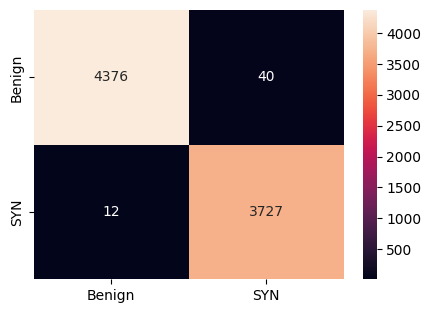





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  XGB   1        1       1      1      1      0.999  1       15.255     0.043
 1  SYN           0    2     0  XGB   0.999    0.999   0.999  0.999  0.999  0.999  0.999   13.455     0.04
 2  SYN           0    3     0  XGB   1        1       1      1      1      1      1       15.742     0.038
 3  SYN           0    4     0  XGB   1        1       1      1      1      0.999  1       13.129     0.036
 4  SYN           0    5     0  XGB   1        1       1      1      1      1      1       15.589     0.037
 5  SYN           0    1     1  XGB   1        1       0.999  1      1      0.999  1       14.888     0.047
 6  SYN           0    2     1  XGB   1        1       0.999  1      1      0.999  1       13.357     0.038
 7  SYN           0    3 

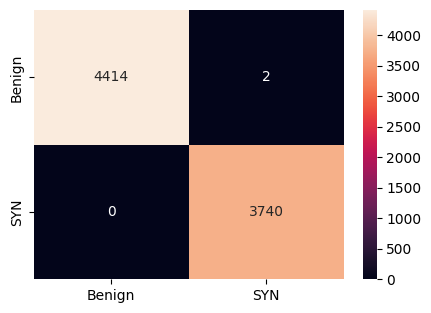





./INPUT/SW/MB-HTTP-4.csv
['ts', 'TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_PSH_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.999    0.997   0.986  0.997  0.991  0.983  0.997    1.61      0
 1  HTTP          0    2     0  LR    1        1       0.995  1      0.997  0.995  1        1.967     0
 2  HTTP          0    3     0  LR    0.998    0.995   0.985  0.995  0.99   0.98   0.995    1.761     0.016
 3  HTTP          0    4     0  LR    1        0.999   1      0.999  0.999  0.999  0.999    1.514     0
 4  HTTP          0    5     0  LR    0.999    0.998   0.983 

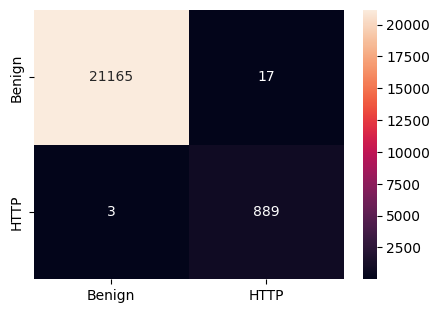





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT        1    0.998   1      0.998  0.999  0.998  0.998    0.126     0.001
 1  HTTP          0    2     0  DT        1    0.999   1      0.999  1      0.999  0.999    0.27      0
 2  HTTP          0    3     0  DT        1    1       1      1      1      1      1        0.283     0
 3  HTTP          0    4     0  DT        1    0.999   1      0.999  1      0.999  0.999    0.229     0
 4  HTTP          0    5     0  DT        1    0.999   1      0.999  1      0.999  0.999    0.283     0
 5  HTTP          0    1     1  DT        1    1       0.999  1      1      0.999  1        0.108     0.006
 6  HTTP          0    2     1  DT        1    0.999   1      0.999  0.999  0.999  0.999    0.258     0
 7  HTTP          0    3     1  DT        1 

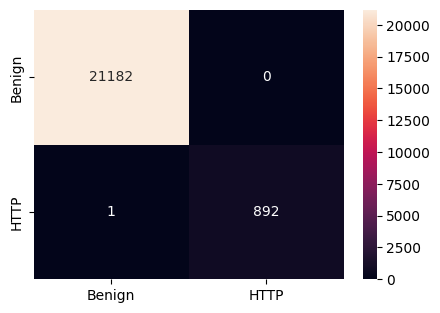





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  RF        1    1           1  1      1      1      1        9.75      0.126
 1  HTTP          0    2     0  RF        1    0.999       1  0.999  1      0.999  0.999    9.553     0.141
 2  HTTP          0    3     0  RF        1    1           1  1      1      1      1       10.902     0.13
 3  HTTP          0    4     0  RF        1    0.999       1  0.999  1      0.999  0.999    8.798     0.126
 4  HTTP          0    5     0  RF        1    1           1  1      1      1      1        9.674     0.126
 5  HTTP          0    1     1  RF        1    0.999       1  0.999  1      0.999  0.999   10.635     0.157
 6  HTTP          0    2     1  RF        1    1           1  1      1      1      1        9.394     0.124
 7  HTTP          0    3 

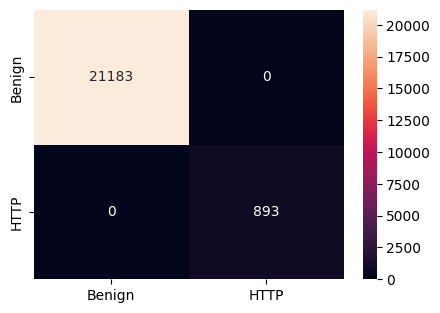





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  KNN       1    0.999   0.997  0.999  0.998  0.996  0.999    0.255     0.582
 1  HTTP          0    2     0  KNN       1    0.999   0.999  0.999  0.999  0.998  0.999    0.263     0.575
 2  HTTP          0    3     0  KNN       1    0.998   0.997  0.998  0.997  0.995  0.998    0.26      0.585
 3  HTTP          0    4     0  KNN       1    0.997   0.998  0.997  0.998  0.995  0.997    0.299     0.522
 4  HTTP          0    5     0  KNN       1    0.998   1      0.998  0.999  0.998  0.998    0.252     0.546
 5  HTTP          0    1     1  KNN       1    0.997   0.998  0.997  0.997  0.994  0.997    0.252     0.581
 6  HTTP          0    2     1  KNN       1    0.998   0.998  0.998  0.998  0.996  0.998    0.229     0.506
 7  HTTP          0    3

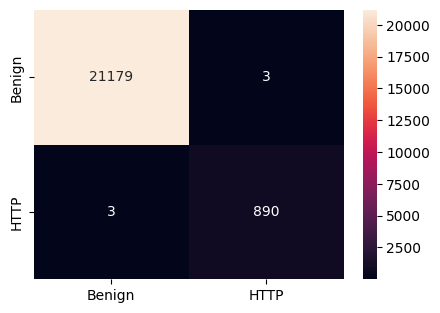





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  NB    0.853    0.923   0.608  0.923  0.636  0.308  0.923    0.031     0.016
 1  HTTP          0    2     0  NB    0.847    0.92    0.602  0.92   0.627  0.294  0.92     0.047     0.016
 2  HTTP          0    3     0  NB    0.851    0.922   0.609  0.922  0.636  0.31   0.922    0.047     0.016
 3  HTTP          0    4     0  NB    0.845    0.919   0.603  0.919  0.627  0.296  0.919    0.047     0.016
 4  HTTP          0    5     0  NB    0.852    0.923   0.608  0.923  0.636  0.309  0.923    0.042     0.016
 5  HTTP          0    1     1  NB    0.847    0.92    0.608  0.92   0.634  0.306  0.92     0.047     0
 6  HTTP          0    2     1  NB    0.849    0.921   0.604  0.921  0.63   0.299  0.921    0.047     0
 7  HTTP          0    3     1  

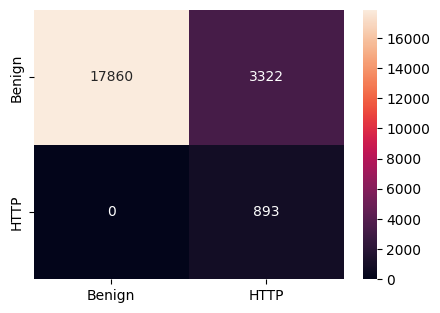





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  XGB       1    0.999       1  0.999  1      0.999  0.999   17.225     0.063
 1  HTTP          0    2     0  XGB       1    1           1  1      1      1      1       14.034     0.047
 2  HTTP          0    3     0  XGB       1    0.999       1  0.999  1      0.999  0.999   24.292     0.061
 3  HTTP          0    4     0  XGB       1    1           1  1      1      1      1       13.511     0.056
 4  HTTP          0    5     0  XGB       1    0.999       1  0.999  0.999  0.999  0.999   13.464     0.047
 5  HTTP          0    1     1  XGB       1    0.999       1  0.999  1      0.999  0.999   13.94      0.047
 6  HTTP          0    2     1  XGB       1    1           1  1      1      1      1       12.952     0.061
 7  HTTP          0    3

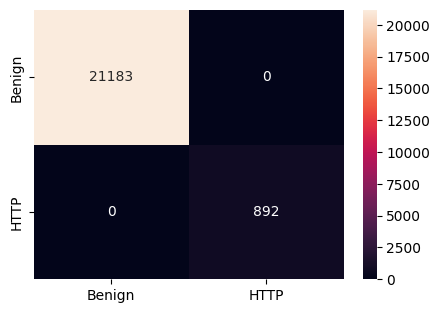





./INPUT/SW/MB-ACK-4.csv
['payload_bytes_mean_WE', 'sport_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  LR        1    1           1  1         1  1      1        0.446         0
 1  ACK           0    2     0  LR        1    1           1  1         1  1      1        0.389         0
 2  ACK           0    3     0  LR        1    0.999       1  0.999     1  0.999  0.999    0.393         0
 3  ACK           0    4     0  LR        1    1           1  1         1  1      1        0.43          0
 4  ACK           0    5     0  LR        1    1           1  1         1  1      1        0.495         0
 5  ACK           0    1     1  LR        1    1           1  1         1  1      1        0.475         0
 6  ACK           0    2

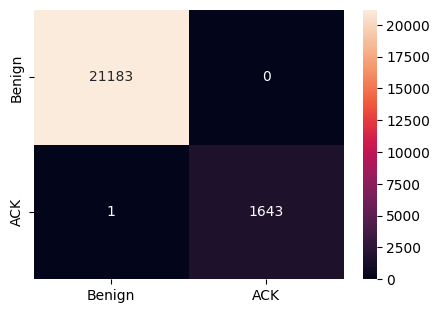





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  DT        1    0.999       1  0.999     1  0.999  0.999    0.1           0
 1  ACK           0    2     0  DT        1    0.999       1  0.999     1  0.999  0.999    0.104         0
 2  ACK           0    3     0  DT        1    1           1  1         1  1      1        0.11          0
 3  ACK           0    4     0  DT        1    1           1  1         1  1      1        0.1           0
 4  ACK           0    5     0  DT        1    0.999       1  0.999     1  0.999  0.999    0.126         0
 5  ACK           0    1     1  DT        1    1           1  1         1  1      1        0.11          0
 6  ACK           0    2     1  DT        1    1           1  1         1  1      1        0.11          0
 7  ACK           0    3     1  D

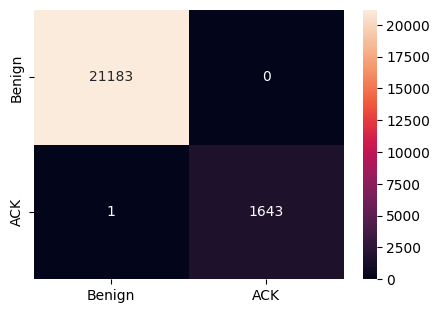





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  RF        1    0.999   1      0.999     1  0.999  0.999    5.639     0.094
 1  ACK           0    2     0  RF        1    1       0.999  1         1  0.999  1        5.741     0.094
 2  ACK           0    3     0  RF        1    1       1      1         1  1      1        5.511     0.094
 3  ACK           0    4     0  RF        1    0.999   1      0.999     1  0.999  0.999    5.259     0.094
 4  ACK           0    5     0  RF        1    0.999   1      0.999     1  0.999  0.999    5.523     0.094
 5  ACK           0    1     1  RF        1    0.999   1      0.999     1  0.999  0.999    5.599     0.1
 6  ACK           0    2     1  RF        1    0.999   1      0.999     1  0.999  0.999    5.438     0.094
 7  ACK           0    3     1  RF 

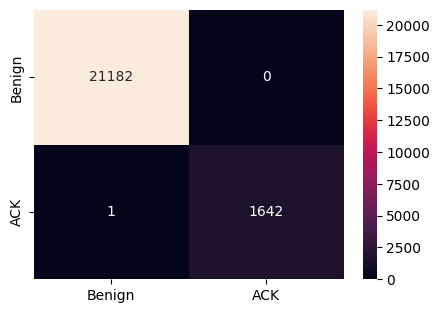





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  KNN       1    1       1      1      1      1      1        0.13      0.121
 1  ACK           0    2     0  KNN       1    1       0.999  1      1      0.999  1        0.126     0.125
 2  ACK           0    3     0  KNN       1    1       1      1      1      1      1        0.141     0.126
 3  ACK           0    4     0  KNN       1    1       0.999  1      1      0.999  1        0.125     0.125
 4  ACK           0    5     0  KNN       1    0.999   1      0.999  0.999  0.999  0.999    0.12      0.141
 5  ACK           0    1     1  KNN       1    1       0.999  1      1      0.999  1        0.125     0.126
 6  ACK           0    2     1  KNN       1    1       1      1      1      1      1        0.14      0.126
 7  ACK           0    3

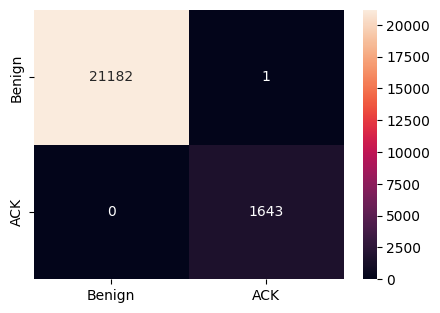





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  NB        1    0.999       1  0.999  1      0.999  0.999    0.031     0
 1  ACK           0    2     0  NB        1    1           1  1      1      1      1        0.031     0.01
 2  ACK           0    3     0  NB        1    0.998       1  0.998  0.999  0.998  0.998    0.032     0.016
 3  ACK           0    4     0  NB        1    0.999       1  0.999  1      0.999  0.999    0.031     0
 4  ACK           0    5     0  NB        1    1           1  1      1      1      1        0.031     0.019
 5  ACK           0    1     1  NB        1    0.999       1  0.999  1      0.999  0.999    0.035     0
 6  ACK           0    2     1  NB        1    0.999       1  0.999  1      0.999  0.999    0.031     0
 7  ACK           0    3     1  NB       

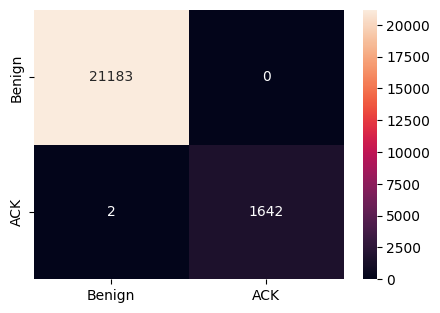





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  XGB       1    1           1  1         1  1      1       13.656     0.063
 1  ACK           0    2     0  XGB       1    1           1  1         1  1      1       14.156     0.066
 2  ACK           0    3     0  XGB       1    0.999       1  0.999     1  0.999  0.999   13.727     0.063
 3  ACK           0    4     0  XGB       1    0.999       1  0.999     1  0.999  0.999   13.73      0.114
 4  ACK           0    5     0  XGB       1    1           1  1         1  1      1       14.224     0.047
 5  ACK           0    1     1  XGB       1    1           1  1         1  1      1       14.773     0.063
 6  ACK           0    2     1  XGB       1    0.999       1  0.999     1  0.999  0.999   16.66      0.057
 7  ACK           0    3     1  X

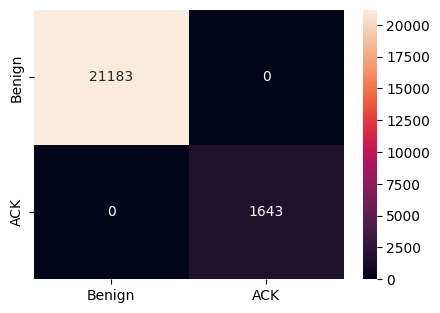





./INPUT/SW/MB-UDP-4.csv
['IP_tos', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'TCP_window_sum_of_EW', 'entropy_diff', 'ts_std_2', 'TCP_window_mean_2', 'entropy_std_2', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_mean_9', 'entropy_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  LR        1        1       1      1     1      1      1    2.818     0.017
 1  UDP           0    2     0  LR        1        1       1      1     1      1      1    2.137     0.016
 2  UDP           0    3     0  LR        1        1       1      1     1      1      1    4.266     0.008
 3  UDP           0    4     0  LR        1        1       1      1   

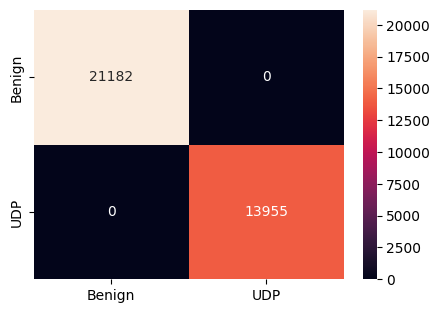





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  DT        1        1       1      1     1      1      1    0.298     0.016
 1  UDP           0    2     0  DT        1        1       1      1     1      1      1    0.3       0
 2  UDP           0    3     0  DT        1        1       1      1     1      1      1    0.251     0
 3  UDP           0    4     0  DT        1        1       1      1     1      1      1    0.245     0
 4  UDP           0    5     0  DT        1        1       1      1     1      1      1    0.267     0.017
 5  UDP           0    1     1  DT        1        1       1      1     1      1      1    0.283     0
 6  UDP           0    2     1  DT        1        1       1      1     1      1      1    0.298     0
 7  UDP           0    3     1  DT        1        1 

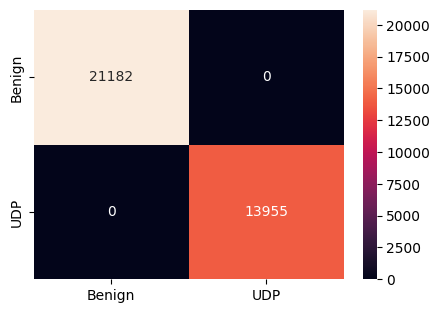





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  RF        1        1       1      1     1      1      1    3.565     0.123
 1  UDP           0    2     0  RF        1        1       1      1     1      1      1    3.934     0.126
 2  UDP           0    3     0  RF        1        1       1      1     1      1      1    3.823     0.126
 3  UDP           0    4     0  RF        1        1       1      1     1      1      1    3.613     0.126
 4  UDP           0    5     0  RF        1        1       1      1     1      1      1    3.751     0.125
 5  UDP           0    1     1  RF        1        1       1      1     1      1      1    3.752     0.141
 6  UDP           0    2     1  RF        1        1       1      1     1      1      1    3.775     0.126
 7  UDP           0    3     1  R

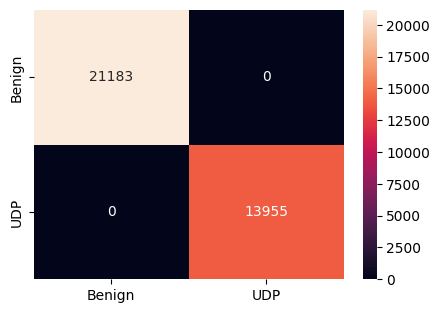





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  KNN       1        1       1      1     1      1      1    0.543    54.556
 1  UDP           0    2     0  KNN       1        1       1      1     1      1      1    0.565    53.315
 2  UDP           0    3     0  KNN       1        1       1      1     1      1      1    0.552    60.719
 3  UDP           0    4     0  KNN       1        1       1      1     1      1      1    0.548    57.548
 4  UDP           0    5     0  KNN       1        1       1      1     1      1      1    0.549    56.406
 5  UDP           0    1     1  KNN       1        1       1      1     1      1      1    0.375    55.374
 6  UDP           0    2     1  KNN       1        1       1      1     1      1      1    0.533    56.944
 7  UDP           0    3     1  K

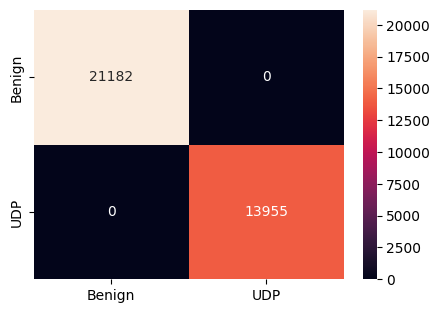





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  NB    0.677    0.73    0.778  0.73   0.672  0.407  0.73     0.173     0.016
 1  UDP           0    2     0  NB    0.674    0.729   0.775  0.729  0.669  0.403  0.729    0.063     0.016
 2  UDP           0    3     0  NB    0.674    0.731   0.773  0.731  0.669  0.403  0.731    0.079     0.031
 3  UDP           0    4     0  NB    0.673    0.729   0.774  0.729  0.668  0.401  0.729    0.078     0.032
 4  UDP           0    5     0  NB    0.671    0.729   0.772  0.729  0.667  0.399  0.729    0.079     0.031
 5  UDP           0    1     1  NB    0.673    0.73    0.774  0.73   0.669  0.402  0.73     0.11      0.031
 6  UDP           0    2     1  NB    0.681    0.734   0.778  0.734  0.677  0.414  0.734    0.079     0.031
 7  UDP           0    3

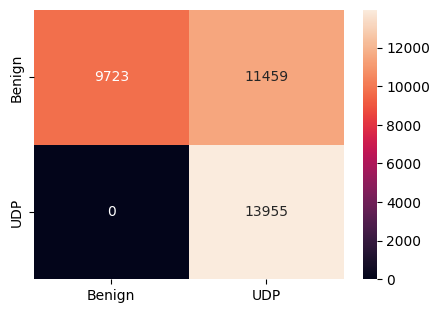





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  XGB       1        1       1      1     1      1      1   38.834     0.11
 1  UDP           0    2     0  XGB       1        1       1      1     1      1      1   38.35      0.11
 2  UDP           0    3     0  XGB       1        1       1      1     1      1      1   38.053     0.145
 3  UDP           0    4     0  XGB       1        1       1      1     1      1      1   38.288     0.126
 4  UDP           0    5     0  XGB       1        1       1      1     1      1      1   38.56      0.126
 5  UDP           0    1     1  XGB       1        1       1      1     1      1      1   38.653     0.11
 6  UDP           0    2     1  XGB       1        1       1      1     1      1      1   42.59      0.135
 7  UDP           0    3     1  XGB 

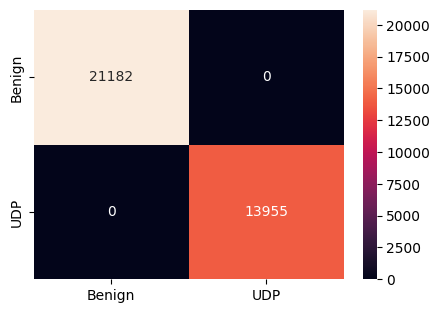





./INPUT/SW/MitM-ARP-6.csv
['Ether_type', 'IP_tos', 'IP_flags', 'IP_MF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_reserved', 'TCP_ACK', 'TCP_ECE', 'TCP_CWR', 'UDP_len', 'DNS_qr', 'DNS_ra', 'DNS_qdcount', 'DNS_nscount', 'DNS_arcount', 'payload_bytes', 'entropy', 'Protocol', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_mean_WE', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'entropy_mean_2', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_CWR_ratio', 'TCP_RST_SR', 'TCP_PSH_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'entropy_mean_6', 'entropy_std_6', 'pck_size_mean_9', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_std_9', 'T

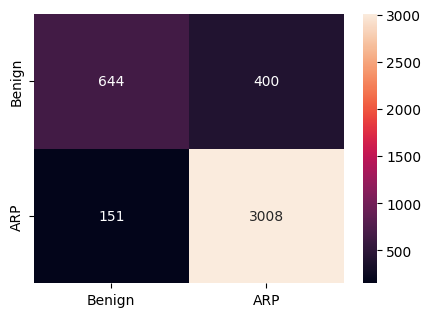





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.994    0.993   0.991  0.993  0.992  0.984  0.993    0.392     0
 1  ARP           0    2     0  DT    0.994    0.992   0.993  0.992  0.992  0.985  0.992    0.424     0
 2  ARP           0    3     0  DT    0.996    0.997   0.994  0.997  0.995  0.99   0.997    0.472     0.015
 3  ARP           0    4     0  DT    0.998    0.996   0.997  0.996  0.997  0.993  0.996    0.393     0
 4  ARP           0    5     0  DT    0.995    0.994   0.994  0.994  0.994  0.987  0.994    0.471     0
 5  ARP           0    1     1  DT    0.995    0.994   0.993  0.994  0.994  0.988  0.994    0.456     0
 6  ARP           0    2     1  DT    0.994    0.991   0.992  0.991  0.991  0.982  0.991    0.455     0
 7  ARP           0    3     1  DT    0.995    0

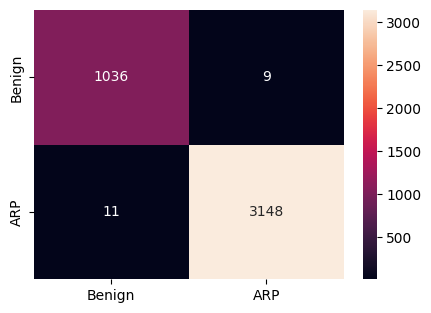





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  RF    0.998    0.997   0.997  0.997  0.997  0.994  0.997   11.291     0.101
 1  ARP           0    2     0  RF    0.997    0.995   0.997  0.995  0.996  0.992  0.995   11.784     0.094
 2  ARP           0    3     0  RF    0.997    0.995   0.996  0.995  0.996  0.991  0.995   10.689     0.094
 3  ARP           0    4     0  RF    0.999    0.997   0.999  0.997  0.998  0.996  0.997   11.356     0.095
 4  ARP           0    5     0  RF    0.998    0.999   0.997  0.999  0.998  0.995  0.999   11.701     0.093
 5  ARP           0    1     1  RF    0.998    0.998   0.997  0.998  0.997  0.995  0.998   11.601     0.094
 6  ARP           0    2     1  RF    0.997    0.996   0.997  0.996  0.996  0.993  0.996   11.538     0.094
 7  ARP           0    3

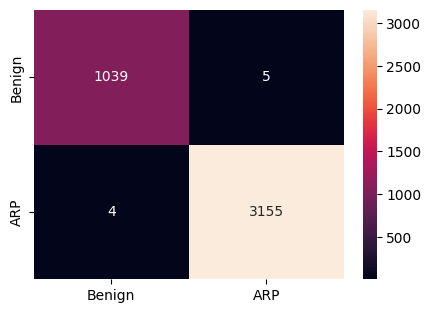





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  KNN   0.946    0.933   0.926  0.933  0.929  0.859  0.933    0.204     0.126
 1  ARP           0    2     0  KNN   0.944    0.928   0.922  0.928  0.925  0.851  0.928    0.204     0.11
 2  ARP           0    3     0  KNN   0.944    0.93    0.921  0.93   0.925  0.851  0.93     0.204     0.11
 3  ARP           0    4     0  KNN   0.943    0.927   0.922  0.927  0.924  0.848  0.927    0.204     0.11
 4  ARP           0    5     0  KNN   0.942    0.924   0.922  0.924  0.923  0.846  0.924    0.204     0.11
 5  ARP           0    1     1  KNN   0.946    0.927   0.926  0.927  0.927  0.853  0.927    0.189     0.126
 6  ARP           0    2     1  KNN   0.944    0.93    0.924  0.93   0.927  0.854  0.93     0.204     0.11
 7  ARP           0    3     

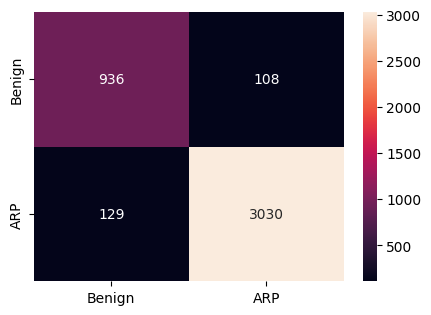





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  NB    0.762    0.528   0.684  0.528  0.496  0.081  0.528    0.031     0.016
 1  ARP           0    2     0  NB    0.765    0.532   0.8    0.532  0.496  0.093  0.532    0.031     0.016
 2  ARP           0    3     0  NB    0.759    0.534   0.7    0.534  0.504  0.095  0.534    0.031     0
 3  ARP           0    4     0  NB    0.758    0.531   0.763  0.531  0.493  0.088  0.531    0.016     0.016
 4  ARP           0    5     0  NB    0.761    0.532   0.692  0.532  0.502  0.091  0.532    0.031     0.016
 5  ARP           0    1     1  NB    0.748    0.526   0.637  0.526  0.493  0.072  0.526    0.031     0.016
 6  ARP           0    2     1  NB    0.746    0.523   0.705  0.523  0.477  0.065  0.523    0.016     0.016
 7  ARP           0    3    

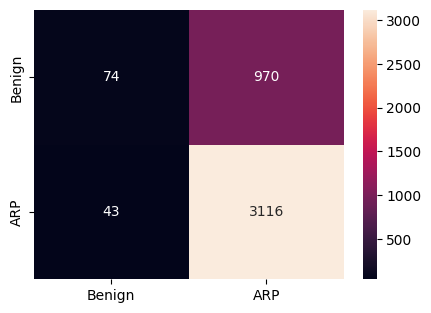





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  XGB   0.997    0.996   0.995  0.996  0.996  0.992  0.996   14.969     0.04
 1  ARP           0    2     0  XGB   0.997    0.996   0.997  0.996  0.996  0.993  0.996   14.597     0.031
 2  ARP           0    3     0  XGB   0.999    0.997   0.999  0.997  0.998  0.996  0.997   14.743     0.047
 3  ARP           0    4     0  XGB   0.997    0.996   0.997  0.996  0.996  0.992  0.996   14.344     0.032
 4  ARP           0    5     0  XGB   0.998    0.998   0.996  0.998  0.997  0.995  0.998   14.612     0.032
 5  ARP           0    1     1  XGB   0.997    0.997   0.996  0.997  0.996  0.993  0.997   14.627     0.047
 6  ARP           0    2     1  XGB   0.998    0.996   0.998  0.996  0.997  0.995  0.996   14.937     0.094
 7  ARP           0    3 

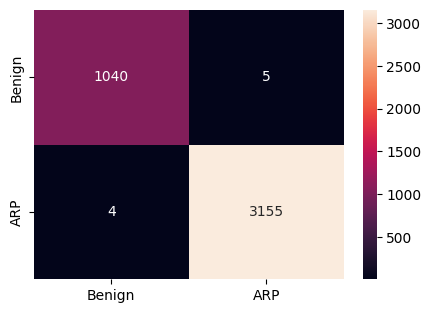





./INPUT/SW/Scan-Port-3.csv
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'entropy_sum_of_EW', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  LR    1        1       1      1      1      1      1        0.056     0
 1  SP            0    2     0  LR    1        1       1      1      1      1      1        0.069     0
 2  SP            0    3     0  LR    1        1       1      1      1      1      1        0.078     0
 3  SP            0    4     0  LR    1        0.998   1      0.998  0.999  0.998  0.998    0.063     0.016
 4  SP            0    5     0  LR    1        1       0.998  1      0.999  0.998  1        0.06      0.016
 5  SP            0    1     1  LR    1        1       1      1      1      1      1    

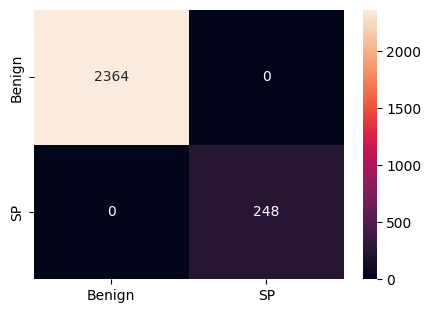





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  DT        1    1           1  1      1      1      1        0.014         0
 1  SP            0    2     0  DT        1    1           1  1      1      1      1        0             0
 2  SP            0    3     0  DT        1    1           1  1      1      1      1        0             0
 3  SP            0    4     0  DT        1    0.998       1  0.998  0.999  0.998  0.998    0             0
 4  SP            0    5     0  DT        1    0.998       1  0.998  0.999  0.998  0.998    0.016         0
 5  SP            0    1     1  DT        1    1           1  1      1      1      1        0             0
 6  SP            0    2     1  DT        1    0.998       1  0.998  0.999  0.998  0.998    0.016         0
 7  SP            0    3

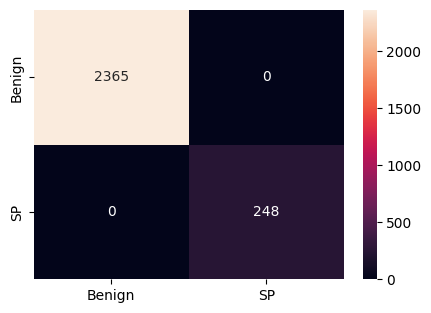





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  RF    0.999    0.996   1      0.996  0.998  0.996  0.996    0.016         0
 1  SP            0    2     0  RF    1        1       1      1      1      1      1        0.016         0
 2  SP            0    3     0  RF    1        1       1      1      1      1      1        0.016         0
 3  SP            0    4     0  RF    1        0.998   1      0.998  0.999  0.998  0.998    0.016         0
 4  SP            0    5     0  RF    1        1       1      1      1      1      1        0.016         0
 5  SP            0    1     1  RF    0.998    0.992   0.999  0.992  0.996  0.991  0.992    0             0
 6  SP            0    2     1  RF    1        1       1      1      1      1      1        0.016         0
 7  SP            0    3

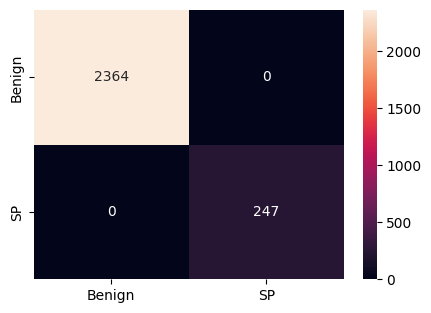





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  KNN   1        1       1      1      1      1      1        0.016     0.024
 1  SP            0    2     0  KNN   1        1       1      1      1      1      1        0.016     0.016
 2  SP            0    3     0  KNN   1        1       1      1      1      1      1        0.016     0.016
 3  SP            0    4     0  KNN   0.999    0.999   0.994  0.999  0.997  0.993  0.999    0.016     0.016
 4  SP            0    5     0  KNN   1        1       1      1      1      1      1        0.016     0.016
 5  SP            0    1     1  KNN   1        1       1      1      1      1      1        0.016     0.016
 6  SP            0    2     1  KNN   1        1       1      1      1      1      1        0.016     0.016
 7  SP            0    3

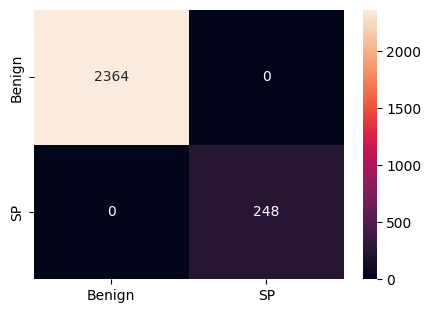





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  NB    0.989    0.992   0.948  0.992  0.969  0.937  0.992    0.016     0
 1  SP            0    2     0  NB    0.993    0.996   0.963  0.996  0.979  0.957  0.996    0         0
 2  SP            0    3     0  NB    0.991    0.995   0.957  0.995  0.975  0.949  0.995    0         0
 3  SP            0    4     0  NB    0.989    0.994   0.948  0.994  0.969  0.939  0.994    0         0
 4  SP            0    5     0  NB    0.99     0.995   0.951  0.995  0.972  0.944  0.995    0         0
 5  SP            0    1     1  NB    0.99     0.994   0.951  0.994  0.972  0.943  0.994    0         0
 6  SP            0    2     1  NB    0.989    0.994   0.951  0.994  0.971  0.942  0.994    0         0
 7  SP            0    3     1  NB    0.989    0.992

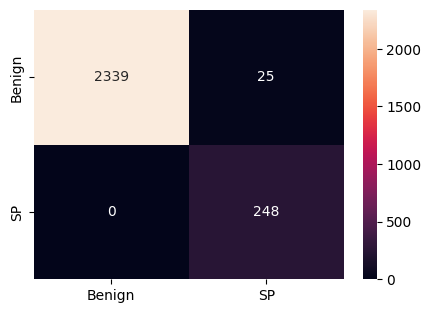





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  XGB       1    1       1      1      1      1      1        2.804     0.016
 1  SP            0    2     0  XGB       1    1       0.998  1      0.999  0.998  1        2.226     0.016
 2  SP            0    3     0  XGB       1    0.998   1      0.998  0.999  0.998  0.998    1.995     0.016
 3  SP            0    4     0  XGB       1    0.998   1      0.998  0.999  0.998  0.998    2.2       0.016
 4  SP            0    5     0  XGB       1    1       1      1      1      1      1        2.905     0.015
 5  SP            0    1     1  XGB       1    1       1      1      1      1      1        3.046     0.016
 6  SP            0    2     1  XGB       1    1       1      1      1      1      1        2.215     0.016
 7  SP            0    3

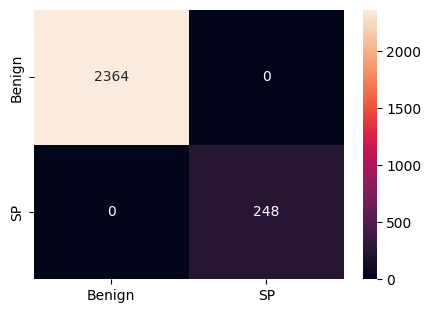





./INPUT/SW/MB-BF-5.csv
['payload_bytes', 'pck_size_diff', 'TCP_window_diff', 'entropy_mean_WE', 'pck_size_mean_2', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_ratio', 'TCP_FIN_SR', 'pck_size_mean_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR        1    0.996   0.992  0.996  0.994  0.988  0.996    4.896     0
 1  BF            0    2     0  LR        1    1       1      1      1      1      1        2.549     0
 2  BF            0    3     0  LR        1    1 

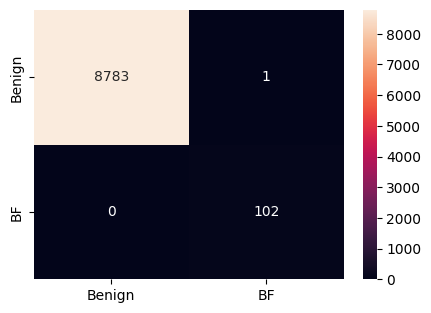





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT        1    1       1      1      1      1      1        0.157     0
 1  BF            0    2     0  DT        1    1       1      1      1      1      1        0.173     0.016
 2  BF            0    3     0  DT        1    1       1      1      1      1      1        0.157     0.016
 3  BF            0    4     0  DT        1    1       1      1      1      1      1        0.125     0
 4  BF            0    5     0  DT        1    1       1      1      1      1      1        0.15      0
 5  BF            0    1     1  DT        1    1       0.995  1      0.998  0.995  1        0.189     0
 6  BF            0    2     1  DT        1    0.995   1      0.995  0.998  0.995  0.995    0.141     0
 7  BF            0    3     1  DT        1 

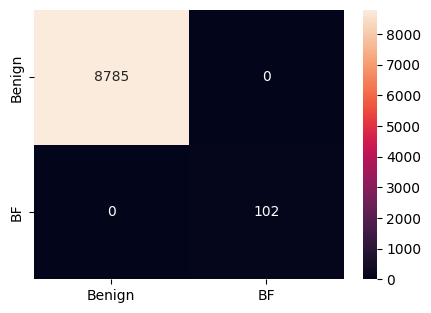





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  BF            0    1     0  RF        1        1       1      1     1      1      1    8.379     0.11
 1  BF            0    2     0  RF        1        1       1      1     1      1      1    7.828     0.094
 2  BF            0    3     0  RF        1        1       1      1     1      1      1    8.019     0.11
 3  BF            0    4     0  RF        1        1       1      1     1      1      1    8.708     0.11
 4  BF            0    5     0  RF        1        1       1      1     1      1      1    8.33      0.126
 5  BF            0    1     1  RF        1        1       1      1     1      1      1    8.724     0.11
 6  BF            0    2     1  RF        1        1       1      1     1      1      1    8.897     0.11
 7  BF            0    3     1  RF    

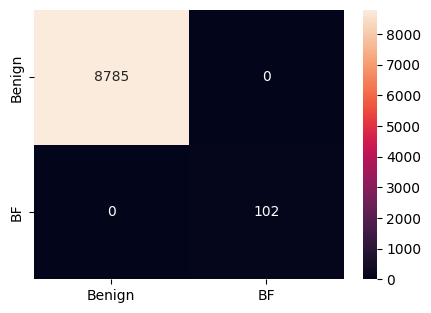





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  KNN   0.999    0.995   0.971  0.995  0.983  0.965  0.995    0.014     2.113
 1  BF            0    2     0  KNN   0.999    0.99    0.98   0.99   0.985  0.969  0.99     0         2.064
 2  BF            0    3     0  KNN   0.999    0.976   0.976  0.976  0.976  0.953  0.976    0         2.092
 3  BF            0    4     0  KNN   0.999    0.976   0.985  0.976  0.981  0.961  0.976    0         2.154
 4  BF            0    5     0  KNN   0.999    0.975   0.971  0.975  0.973  0.946  0.975    0         1.93
 5  BF            0    1     1  KNN   0.999    0.989   0.97   0.989  0.979  0.958  0.989    0.015     2.878
 6  BF            0    2     1  KNN   0.999    0.977   0.982  0.977  0.98   0.959  0.977    0         2.177
 7  BF            0    3 

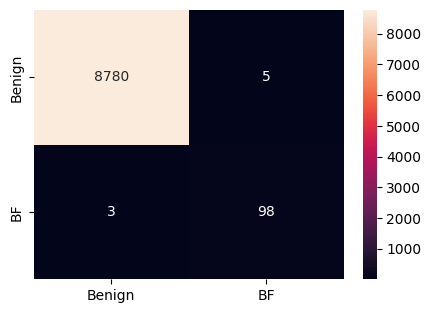





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  NB    0.971    0.684   0.586  0.684  0.616  0.234  0.684    0.031     0
 1  BF            0    2     0  NB    0.972    0.639   0.553  0.639  0.575  0.152  0.639    0.026     0
 2  BF            0    3     0  NB    0.971    0.644   0.581  0.644  0.602  0.206  0.644    0.016     0
 3  BF            0    4     0  NB    0.973    0.652   0.573  0.652  0.597  0.196  0.652    0.016     0
 4  BF            0    5     0  NB    0.974    0.676   0.594  0.676  0.621  0.244  0.676    0.016     0
 5  BF            0    1     1  NB    0.973    0.695   0.579  0.695  0.611  0.224  0.695    0.018     0.014
 6  BF            0    2     1  NB    0.973    0.703   0.611  0.703  0.642  0.286  0.703    0.031     0.016
 7  BF            0    3     1  NB    0.97  

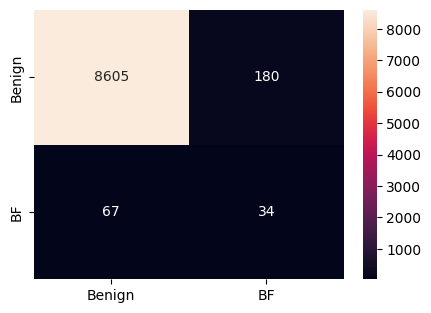





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  XGB       1    0.994       1  0.994  0.997  0.994  0.994   10.272     0.031
 1  BF            0    2     0  XGB       1    0.995       1  0.995  0.997  0.995  0.995    9.782     0.038
 2  BF            0    3     0  XGB       1    1           1  1      1      1      1        9.957     0.032
 3  BF            0    4     0  XGB       1    0.996       1  0.996  0.998  0.996  0.996    9.689     0.039
 4  BF            0    5     0  XGB       1    0.989       1  0.989  0.994  0.989  0.989    9.564     0.032
 5  BF            0    1     1  XGB       1    0.996       1  0.996  0.998  0.996  0.996    9.676     0.03
 6  BF            0    2     1  XGB       1    0.995       1  0.995  0.997  0.995  0.995   10.366     0.047
 7  BF            0    3 

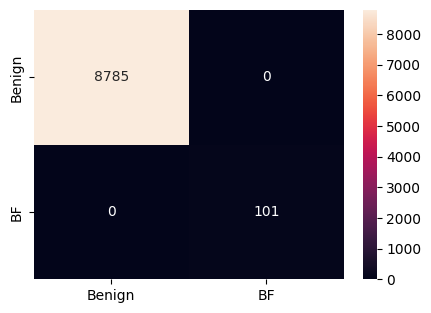





./INPUT/SW/Scan-OS-3.csv
['IP_ttl', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_ECE', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'dport_class', 'Protocol', 'dst_IP_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'payload_bytes_std_2', 'entropy_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_URG_ratio', 'TCP_ECE_ratio', 'TCP_CWR_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_ECE_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec  

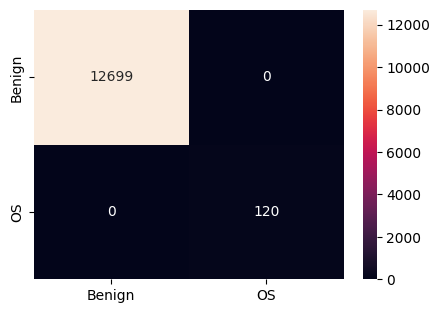





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  DT        1    1       0.996  1      0.998  0.996  1        0.299     0
 1  OS            0    2     0  DT        1    1       1      1      1      1      1        0.33      0
 2  OS            0    3     0  DT        1    1       1      1      1      1      1        0.299     0
 3  OS            0    4     0  DT        1    0.996   1      0.996  0.998  0.996  0.996    0.299     0
 4  OS            0    5     0  DT        1    1       0.995  1      0.998  0.995  1        0.315     0.009
 5  OS            0    1     1  DT        1    1       0.996  1      0.998  0.996  1        0.346     0.016
 6  OS            0    2     1  DT        1    1       1      1      1      1      1        0.314     0.009
 7  OS            0    3     1  DT      

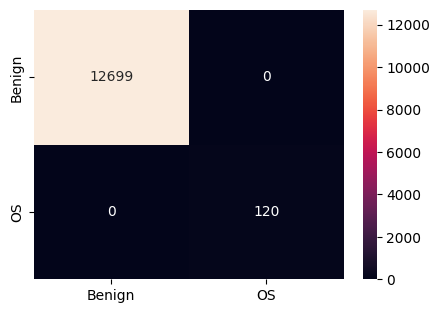





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  RF    1        1       1      1      1      1      1        0.063     0
 1  OS            0    2     0  RF    1        0.979   1      0.979  0.989  0.978  0.979    0.094     0.016
 2  OS            0    3     0  RF    0.994    0.702   0.987  0.702  0.785  0.571  0.702    0.11      0
 3  OS            0    4     0  RF    1        1       0.995  1      0.998  0.995  1        0.079     0.016
 4  OS            0    5     0  RF    1        0.996   1      0.996  0.998  0.996  0.996    0.109     0.016
 5  OS            0    1     1  RF    1        0.995   1      0.995  0.997  0.995  0.995    0.094     0
 6  OS            0    2     1  RF    1        0.996   1      0.996  0.998  0.996  0.996    0.078     0
 7  OS            0    3     1  RF    1 

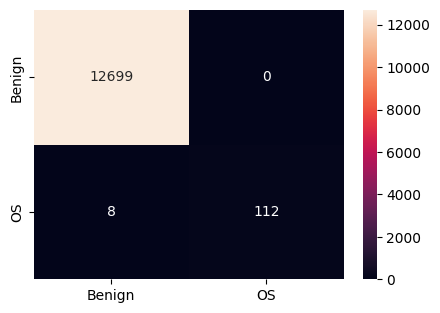





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  KNN   0.998    0.945   0.956  0.945  0.95   0.9    0.945    0.016     5.868
 1  OS            0    2     0  KNN   0.998    0.973   0.925  0.973  0.948  0.896  0.973    0.016     5.71
 2  OS            0    3     0  KNN   0.997    0.918   0.939  0.918  0.928  0.857  0.918    0.016     5.615
 3  OS            0    4     0  KNN   0.998    0.958   0.951  0.958  0.954  0.909  0.958    0.016     5.807
 4  OS            0    5     0  KNN   0.998    0.961   0.925  0.961  0.942  0.885  0.961    0.016     5.758
 5  OS            0    1     1  KNN   0.998    0.956   0.938  0.956  0.947  0.894  0.956    0.016     5.788
 6  OS            0    2     1  KNN   0.998    0.951   0.945  0.951  0.948  0.896  0.951    0.016     5.678
 7  OS            0    3 

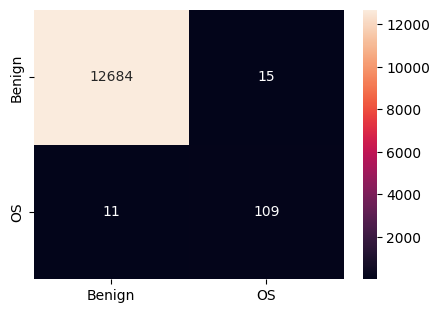





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  NB    0.93     0.965   0.558  0.965  0.586  0.196  0.965    0.063     0.018
 1  OS            0    2     0  NB    0.932    0.965   0.557  0.965  0.585  0.192  0.965    0.063     0.016
 2  OS            0    3     0  NB    0.933    0.966   0.566  0.966  0.6    0.22   0.966    0.083     0.027
 3  OS            0    4     0  NB    0.931    0.965   0.56   0.965  0.59   0.202  0.965    0.063     0.016
 4  OS            0    5     0  NB    0.931    0.965   0.56   0.965  0.59   0.202  0.965    0.07      0.009
 5  OS            0    1     1  NB    0.932    0.966   0.566  0.966  0.599  0.219  0.966    0.047     0
 6  OS            0    2     1  NB    0.932    0.966   0.571  0.966  0.606  0.232  0.966    0.063     0.032
 7  OS            0    3    

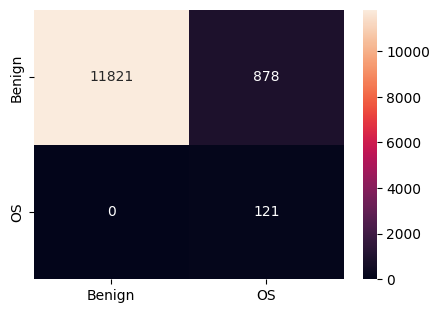





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  XGB       1    1       0.996  1      0.998  0.996  1        3.85      0.032
 1  OS            0    2     0  XGB       1    0.997   1      0.997  0.998  0.996  0.997    3.145     0.031
 2  OS            0    3     0  XGB       1    1       1      1      1      1      1        3.098     0.031
 3  OS            0    4     0  XGB       1    0.996   1      0.996  0.998  0.996  0.996    3.02      0.047
 4  OS            0    5     0  XGB       1    1       0.995  1      0.998  0.995  1        3.063     0.031
 5  OS            0    1     1  XGB       1    0.996   1      0.996  0.998  0.996  0.996    3.144     0.031
 6  OS            0    2     1  XGB       1    1       0.996  1      0.998  0.996  1        3.193     0.029
 7  OS            0    3

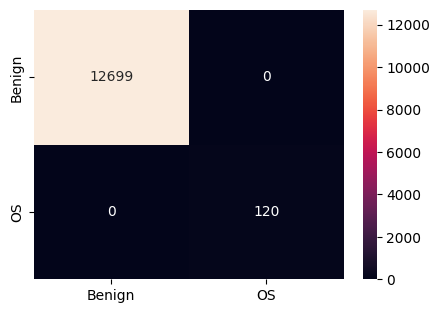





./INPUT/SW/Scan-HDis-3.csv
['Ether_type', 'IP_version', 'IP_DF', 'IP_ttl', 'TCP_flags', 'TCP_options', 'dport_class', 'Protocol', 'IP_add_count', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'TCP_window_mean_WE', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'entropy_std_WE', 'pck_size_mean_2', 'ts_std_2', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    1        1       1      1      1      1      1        0.142         0
 1  SCHD          0    2     0  LR    0.999    1       0.991  1      0.995  0.99   1        0.126         0
 2  SCHD          0    3 

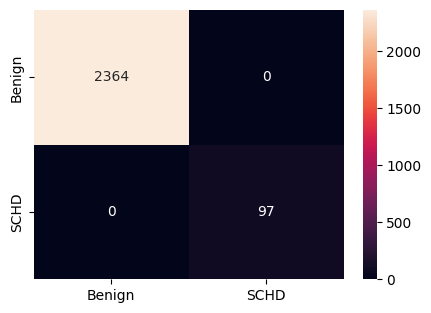





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT    1        1       1      1      1      1      1        0.037     0
 1  SCHD          0    2     0  DT    1        1       1      1      1      1      1        0.047     0
 2  SCHD          0    3     0  DT    1        1       0.995  1      0.997  0.995  1        0.05      0
 3  SCHD          0    4     0  DT    1        1       1      1      1      1      1        0.059     0.001
 4  SCHD          0    5     0  DT    1        1       1      1      1      1      1        0.047     0
 5  SCHD          0    1     1  DT    0.999    0.991   1      0.991  0.995  0.991  0.991    0.031     0
 6  SCHD          0    2     1  DT    1        1       1      1      1      1      1        0.031     0
 7  SCHD          0    3     1  DT    1        1

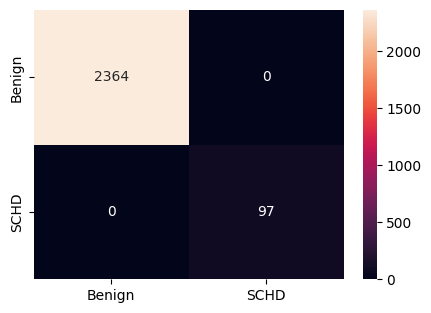





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  RF        1        1   1          1  1      1          1    0.818     0.016
 1  SCHD          0    2     0  RF        1        1   1          1  1      1          1    0.77      0.032
 2  SCHD          0    3     0  RF        1        1   1          1  1      1          1    0.786     0.031
 3  SCHD          0    4     0  RF        1        1   0.995      1  0.997  0.995      1    0.787     0.016
 4  SCHD          0    5     0  RF        1        1   1          1  1      1          1    0.787     0.016
 5  SCHD          0    1     1  RF        1        1   0.995      1  0.997  0.994      1    0.787     0.031
 6  SCHD          0    2     1  RF        1        1   1          1  1      1          1    0.771     0.031
 7  SCHD          0    3

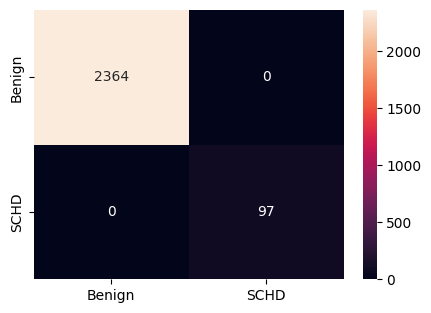





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  KNN   1            1   0.995      1  0.997  0.995      1    0.079     0.11
 1  SCHD          0    2     0  KNN   1            1   1          1  1      1          1    0.063     0.031
 2  SCHD          0    3     0  KNN   1            1   1          1  1      1          1    0.048     0.047
 3  SCHD          0    4     0  KNN   1            1   1          1  1      1          1    0.045     0.031
 4  SCHD          0    5     0  KNN   0.999        1   0.99       1  0.995  0.989      1    0.047     0.031
 5  SCHD          0    1     1  KNN   1            1   0.995      1  0.997  0.995      1    0.062     0.031
 6  SCHD          0    2     1  KNN   1            1   1          1  1      1          1    0.054     0.04
 7  SCHD          0    3  

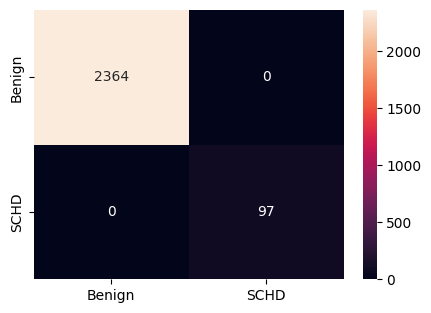





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  NB    0.957      0.5   0.479    0.5  0.489      0    0.5    0.016     0
 1  SCHD          0    2     0  NB    0.961      0.5   0.48     0.5  0.49       0    0.5    0.004     0
 2  SCHD          0    3     0  NB    0.961      0.5   0.481    0.5  0.49       0    0.5    0         0
 3  SCHD          0    4     0  NB    0.962      0.5   0.481    0.5  0.49       0    0.5    0         0
 4  SCHD          0    5     0  NB    0.961      0.5   0.48     0.5  0.49       0    0.5    0         0.01
 5  SCHD          0    1     1  NB    0.961      0.5   0.48     0.5  0.49       0    0.5    0         0
 6  SCHD          0    2     1  NB    0.965      0.5   0.483    0.5  0.491      0    0.5    0.013     0.004
 7  SCHD          0    3     1  NB    0.954  

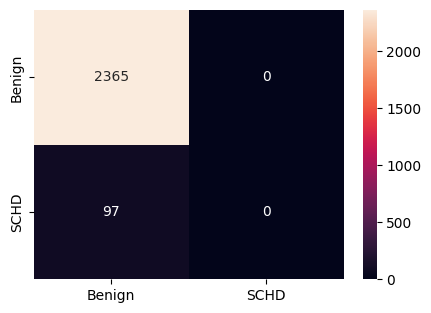





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  XGB   1            1   1          1  1      1          1    1.702     0.016
 1  SCHD          0    2     0  XGB   1            1   1          1  1      1          1    0.661     0.016
 2  SCHD          0    3     0  XGB   1            1   1          1  1      1          1    0.567     0
 3  SCHD          0    4     0  XGB   0.999        1   0.991      1  0.995  0.991      1    0.676     0.016
 4  SCHD          0    5     0  XGB   1            1   1          1  1      1          1    0.566     0
 5  SCHD          0    1     1  XGB   1            1   1          1  1      1          1    0.55      0.016
 6  SCHD          0    2     1  XGB   1            1   1          1  1      1          1    0.692     0
 7  SCHD          0    3     1  XGB 

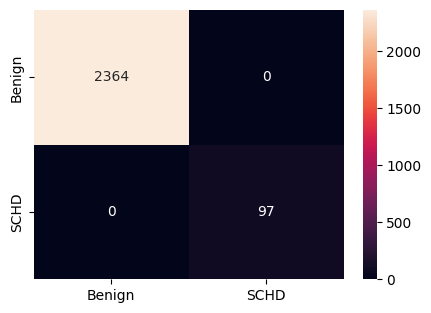





./INPUT/SW/MB-HDis-3.csv
['IP_ihl', 'IP_ttl', 'TCP_options', 'sport_class', 'Protocol', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'TCP_ACK_sum', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  LR        1        1   0.95       1  0.974  0.947      1    1.243         0
 1  MHDis         0    2     0  LR        1        1   0.979      1  0.989  0.979      1    1.495         0
 2  MHDis         0    3     0  LR        1        1   0.973      1  0.986  0.972      1    1.432         0
 3  MHDis         0    4     0  LR        1        1   0.94       1  0.968  0.936      1    1.322         0
 4  MHDis         0    5     0 

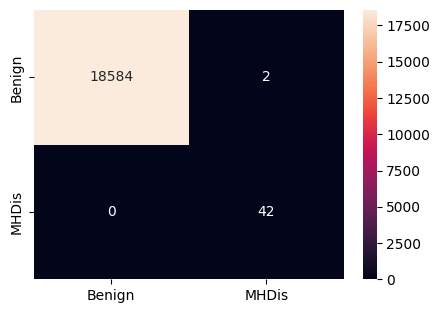





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  DT        1    1       1      1      1      1      1        0.11          0
 1  MHDis         0    2     0  DT        1    1       0.962  1      0.98   0.961  1        0.141         0
 2  MHDis         0    3     0  DT        1    1       0.988  1      0.994  0.987  1        0.157         0
 3  MHDis         0    4     0  DT        1    1       1      1      1      1      1        0.11          0
 4  MHDis         0    5     0  DT        1    1       1      1      1      1      1        0.11          0
 5  MHDis         0    1     1  DT        1    1       1      1      1      1      1        0.126         0
 6  MHDis         0    2     1  DT        1    1       0.973  1      0.986  0.972  1        0.137         0
 7  MHDis         0    3

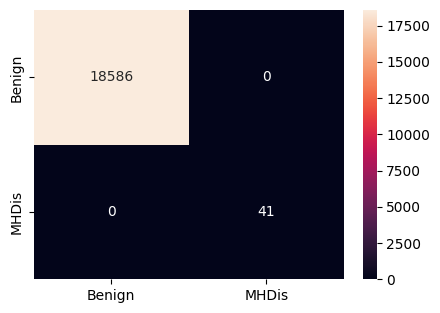





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  RF        1        1   0.988      1  0.994  0.988      1    2.266     0.11
 1  MHDis         0    2     0  RF        1        1   0.979      1  0.989  0.979      1    2.156     0.11
 2  MHDis         0    3     0  RF        1        1   1          1  1      1          1    2.329     0.095
 3  MHDis         0    4     0  RF        1        1   1          1  1      1          1    2.186     0.11
 4  MHDis         0    5     0  RF        1        1   1          1  1      1          1    2.186     0.094
 5  MHDis         0    1     1  RF        1        1   1          1  1      1          1    2.187     0.11
 6  MHDis         0    2     1  RF        1        1   0.99       1  0.995  0.989      1    2.076     0.11
 7  MHDis         0    3     

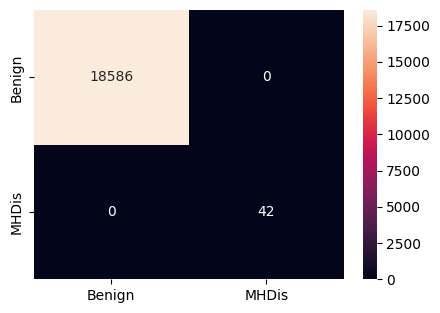





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  KNN       1    1       0.969  1      0.984  0.968  1        0.205     1.007
 1  MHDis         0    2     0  KNN       1    1       0.973  1      0.986  0.972  1        0.206     0.996
 2  MHDis         0    3     0  KNN       1    1       0.927  1      0.96   0.921  1        0.197     0.983
 3  MHDis         0    4     0  KNN       1    1       0.987  1      0.993  0.987  1        0.22      1.025
 4  MHDis         0    5     0  KNN       1    1       0.976  1      0.987  0.975  1        0.205     0.991
 5  MHDis         0    1     1  KNN       1    1       0.988  1      0.994  0.988  1        0.22      1.008
 6  MHDis         0    2     1  KNN       1    1       0.962  1      0.98   0.961  1        0.201     1.007
 7  MHDis         0    3

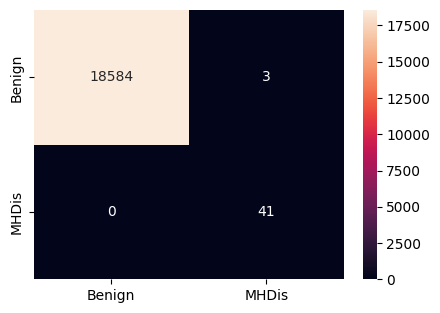





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  NB    0.971    0.985   0.531  0.985  0.551  0.113  0.985    0.048     0.016
 1  MHDis         0    2     0  NB    0.972    0.986   0.544  0.986  0.573  0.156  0.986    0.047     0.016
 2  MHDis         0    3     0  NB    0.973    0.987   0.534  0.987  0.556  0.123  0.987    0.048     0.015
 3  MHDis         0    4     0  NB    0.972    0.986   0.533  0.986  0.555  0.12   0.986    0.04      0.016
 4  MHDis         0    5     0  NB    0.971    0.986   0.544  0.986  0.573  0.157  0.986    0.047     0.016
 5  MHDis         0    1     1  NB    0.971    0.985   0.531  0.985  0.551  0.113  0.985    0.047     0.016
 6  MHDis         0    2     1  NB    0.972    0.986   0.544  0.986  0.573  0.156  0.986    0.052     0.011
 7  MHDis         0    3

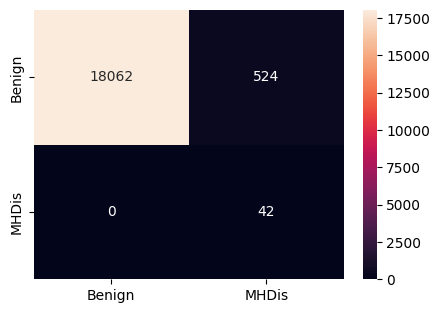





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  XGB       1        1   0.97       1  0.984  0.969      1   20.72      0.047
 1  MHDis         0    2     0  XGB       1        1   1          1  1      1          1   21.194     0.094
 2  MHDis         0    3     0  XGB       1        1   1          1  1      1          1   21.36      0.063
 3  MHDis         0    4     0  XGB       1        1   0.973      1  0.986  0.972      1   21.657     0.048
 4  MHDis         0    5     0  XGB       1        1   1          1  1      1          1   22.377     0.063
 5  MHDis         0    1     1  XGB       1        1   1          1  1      1          1   20.958     0.062
 6  MHDis         0    2     1  XGB       1        1   1          1  1      1          1   21.132     0.047
 7  MHDis         0    3

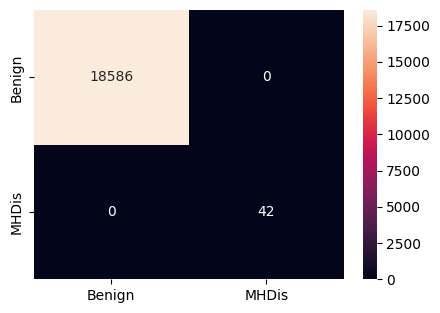

In [15]:
folder("results/cv/")

for file in file_list:
    print(file)
    feature=feature_list[file_list[file]]
    train=file
    test=file
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/cv/{file_list[file]}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file_list[file]]
    ML_CV(train,test,output_csv,feature,file_list[file],0)   


# SS

In [16]:
file_list={"SYN":['./INPUT/SM/DoS-SYN-1.csv','./INPUT/SW/DoS-SYN-2.csv'],
"HTTP":['./INPUT/SM/MB-HTTP-4.csv','./INPUT/SW/MB-HTTP-1.csv'],
"ACK":['./INPUT/SM/MB-ACK-4.csv','./INPUT/SW/MB-ACK-1.csv'],
"UDP":['./INPUT/SM/MB-UDP-4.csv','./INPUT/SW/MB-UDP-1.csv'],
"ARP":['./INPUT/SM/MitM-ARP-6.csv','./INPUT/SW/MitM-ARP-4.csv'],  
"SP":['./INPUT/SM/Scan-Port-3.csv','./INPUT/SW/Scan-Port-4.csv'],
"BF":['./INPUT/SM/MB-BF-5.csv','./INPUT/SW/MB-BF-3.csv'],
"OS":['./INPUT/SM/Scan-OS-3.csv','./INPUT/SW/Scan-OS-6.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SW/MB-HDis-2.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SW/Scan-HDis-4.csv' ]}
 

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.053     0.01
 1  SYN           0    1     1  LR    0.985    0.987   0.983  0.987  0.985  0.97   0.987    0.047     0
 2  SYN           0    1     2  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.063     0
 3  SYN           0   

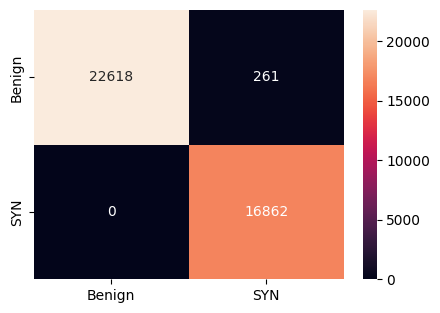





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0
 1  SYN           0    1     1  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.031     0
 2  SYN           0    1     2  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0
 3  SYN           0    1     3  DT    0.999    0.999   0.999  0.999  0.999  0.999  0.999    0.016     0
 4  SYN           0    1     4  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0
 5  SYN           0    1     5  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0
 6  SYN           0    1     6  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.033     0
 7  SYN           0    1     7  DT    0.999    0.999

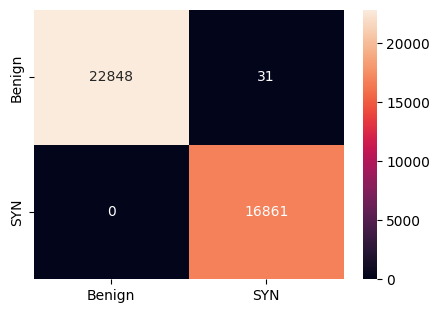





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.18      0.346
 1  SYN           0    1     1  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.241     0.33
 2  SYN           0    1     2  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.244     0.325
 3  SYN           0    1     3  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.218     0.34
 4  SYN           0    1     4  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.18      0.331
 5  SYN           0    1     5  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.227     0.331
 6  SYN           0    1     6  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.133     0.33
 7  SYN           0    1   

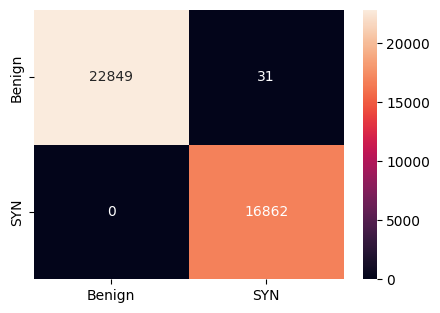





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  KNN   0.997    0.997   0.996  0.997  0.997  0.993  0.997    0.11     10.053
 1  SYN           0    1     1  KNN   0.997    0.997   0.996  0.997  0.997  0.993  0.997    0.11     10.025
 2  SYN           0    1     2  KNN   0.997    0.997   0.996  0.997  0.997  0.993  0.997    0.079     9.96
 3  SYN           0    1     3  KNN   0.997    0.997   0.996  0.997  0.997  0.993  0.997    0.11     10.022
 4  SYN           0    1     4  KNN   0.997    0.997   0.996  0.997  0.997  0.993  0.997    0.11     10.007
 5  SYN           0    1     5  KNN   0.997    0.997   0.996  0.997  0.997  0.993  0.997    0.11      9.944
 6  SYN           0    1     6  KNN   0.997    0.997   0.996  0.997  0.997  0.993  0.997    0.11     10.055
 7  SYN           0    1 

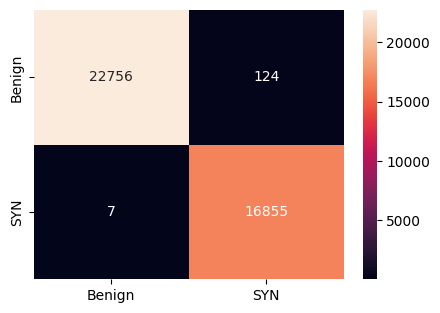





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  NB    0.993    0.994   0.992  0.994  0.993  0.986  0.994    0.016     0.047
 1  SYN           0    1     1  NB    0.993    0.994   0.992  0.994  0.993  0.986  0.994    0.016     0.047
 2  SYN           0    1     2  NB    0.993    0.994   0.992  0.994  0.993  0.986  0.994    0.016     0.031
 3  SYN           0    1     3  NB    0.993    0.994   0.992  0.994  0.993  0.986  0.994    0.016     0.048
 4  SYN           0    1     4  NB    0.993    0.994   0.992  0.994  0.993  0.986  0.994    0.023     0.04
 5  SYN           0    1     5  NB    0.993    0.994   0.992  0.994  0.993  0.986  0.994    0.016     0.048
 6  SYN           0    1     6  NB    0.993    0.994   0.992  0.994  0.993  0.986  0.994    0.016     0.054
 7  SYN           0    1 

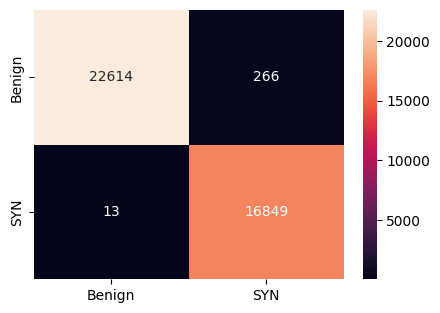





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           0    1     0  XGB   0.999    0.999   0.999  0.999  0.999  0.998  0.999    9.835     0.141
 1  SYN           0    1     1  XGB   0.999    0.999   0.999  0.999  0.999  0.998  0.999    9.75      0.157
 2  SYN           0    1     2  XGB   0.999    0.999   0.999  0.999  0.999  0.998  0.999    9.766     0.142
 3  SYN           0    1     3  XGB   0.999    0.999   0.999  0.999  0.999  0.998  0.999   10.021     0.141
 4  SYN           0    1     4  XGB   0.999    0.999   0.999  0.999  0.999  0.998  0.999    9.925     0.141
 5  SYN           0    1     5  XGB   0.999    0.999   0.999  0.999  0.999  0.998  0.999    9.874     0.141
 6  SYN           0    1     6  XGB   0.999    0.999   0.999  0.999  0.999  0.998  0.999    9.943     0.142
 7  SYN           0    1

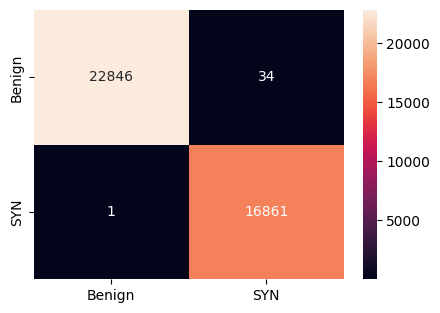





HTTP
['ts', 'TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_PSH_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  LR    0.999    0.996   0.991  0.996  0.993  0.986  0.996    0.377     0
 1  HTTP          0    1     1  LR    0.999    0.996   0.991  0.996  0.993  0.986  0.996    0.393     0
 2  HTTP          0    1     2  LR    0.999    0.996   0.991  0.996  0.993  0.986  0.996    0.409     0
 3  HTTP          0    1     3  LR    0.999    0.996   0.991  0.996  0.993  0.986  0.996    0.378     0
 4  HTTP          0    1     4  LR    0.999    0.996   0.991  0.996  0.993  0.986  0.

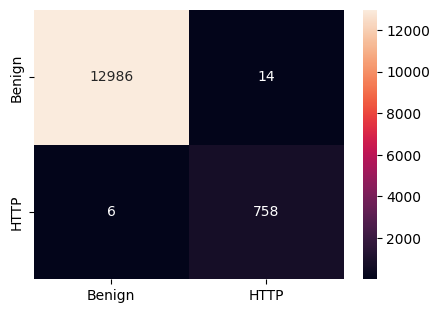





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  DT    0.999    0.995   1      0.995  0.998  0.995  0.995    0.016     0.016
 1  HTTP          0    1     1  DT    0.997    0.971   0.998  0.971  0.984  0.969  0.971    0.038     0
 2  HTTP          0    1     2  DT    0.999    0.995   1      0.995  0.997  0.994  0.995    0.031     0
 3  HTTP          0    1     3  DT    0.999    0.989   0.999  0.989  0.994  0.988  0.989    0.047     0
 4  HTTP          0    1     4  DT    0.999    0.993   1      0.993  0.996  0.992  0.993    0.016     0
 5  HTTP          0    1     5  DT    0.999    0.995   1      0.995  0.998  0.995  0.995    0.047     0
 6  HTTP          0    1     6  DT    0.999    0.995   1      0.995  0.998  0.995  0.995    0.031     0
 7  HTTP          0    1     7  DT    0.995    0

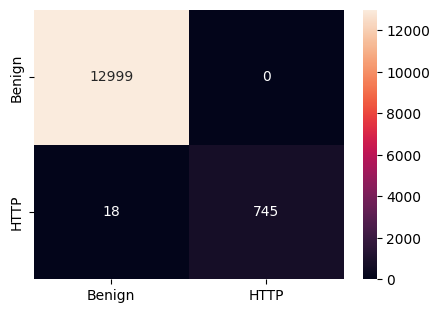





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  RF    0.999    0.992       1  0.992  0.996  0.992  0.992    1.904     0.079
 1  HTTP          0    1     1  RF    0.999    0.993       1  0.993  0.996  0.992  0.993    2.014     0.073
 2  HTTP          0    1     2  RF    0.999    0.992       1  0.992  0.996  0.992  0.992    1.982     0.079
 3  HTTP          0    1     3  RF    0.999    0.992       1  0.992  0.996  0.992  0.992    1.771     0.079
 4  HTTP          0    1     4  RF    0.999    0.993       1  0.993  0.997  0.993  0.993    1.921     0.079
 5  HTTP          0    1     5  RF    0.999    0.992       1  0.992  0.996  0.992  0.992    2.093     0.079
 6  HTTP          0    1     6  RF    0.999    0.993       1  0.993  0.996  0.992  0.993    1.966     0.079
 7  HTTP          0    1

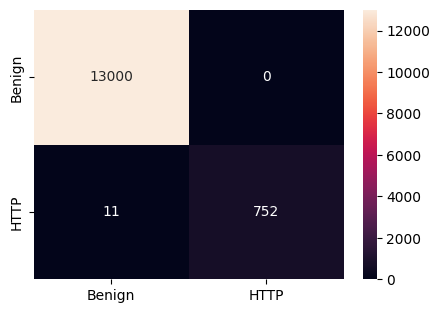





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  KNN   0.981    0.834   0.985  0.834  0.893  0.787  0.834    0.047     0.457
 1  HTTP          0    1     1  KNN   0.981    0.834   0.985  0.834  0.893  0.787  0.834    0.063     0.465
 2  HTTP          0    1     2  KNN   0.981    0.834   0.985  0.834  0.893  0.787  0.834    0.047     0.472
 3  HTTP          0    1     3  KNN   0.981    0.834   0.985  0.834  0.893  0.787  0.834    0.063     0.409
 4  HTTP          0    1     4  KNN   0.981    0.834   0.985  0.834  0.893  0.787  0.834    0.047     0.488
 5  HTTP          0    1     5  KNN   0.981    0.834   0.985  0.834  0.893  0.787  0.834    0.047     0.471
 6  HTTP          0    1     6  KNN   0.981    0.834   0.985  0.834  0.893  0.787  0.834    0.051     0.478
 7  HTTP          0    1

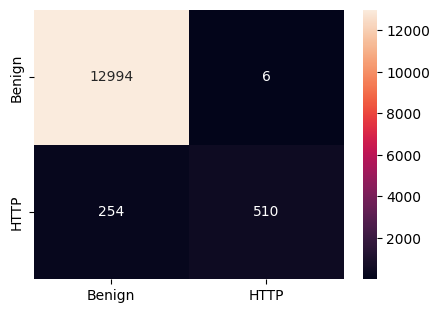





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          0    1     0  NB    0.562    0.768   0.556  0.768  0.45  0.114  0.768    0         0.016
 1  HTTP          0    1     1  NB    0.562    0.768   0.556  0.768  0.45  0.114  0.768    0.031     0.011
 2  HTTP          0    1     2  NB    0.562    0.768   0.556  0.768  0.45  0.114  0.768    0         0.016
 3  HTTP          0    1     3  NB    0.562    0.768   0.556  0.768  0.45  0.114  0.768    0.016     0.016
 4  HTTP          0    1     4  NB    0.562    0.768   0.556  0.768  0.45  0.114  0.768    0.016     0
 5  HTTP          0    1     5  NB    0.562    0.768   0.556  0.768  0.45  0.114  0.768    0.016     0
 6  HTTP          0    1     6  NB    0.562    0.768   0.556  0.768  0.45  0.114  0.768    0.016     0
 7  HTTP          0    1     7  NB    0.562  

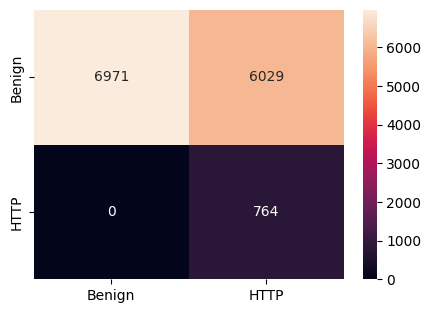





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          0    1     0  XGB   0.999    0.992       1  0.992  0.996  0.992  0.992    3.65      0.031
 1  HTTP          0    1     1  XGB   0.999    0.992       1  0.992  0.996  0.992  0.992    3.698     0.016
 2  HTTP          0    1     2  XGB   0.999    0.992       1  0.992  0.996  0.992  0.992    3.643     0.031
 3  HTTP          0    1     3  XGB   0.999    0.992       1  0.992  0.996  0.992  0.992    3.713     0.016
 4  HTTP          0    1     4  XGB   0.999    0.992       1  0.992  0.996  0.992  0.992    3.666     0.031
 5  HTTP          0    1     5  XGB   0.999    0.992       1  0.992  0.996  0.992  0.992    3.477     0.031
 6  HTTP          0    1     6  XGB   0.999    0.992       1  0.992  0.996  0.992  0.992    3.652     0.031
 7  HTTP          0    1

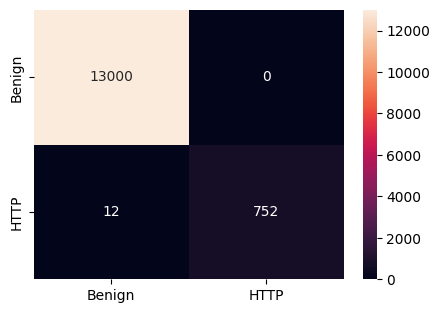





ACK
['payload_bytes_mean_WE', 'sport_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  LR        1        1   0.999      1     1  0.999      1    0.094     0
 1  ACK           0    1     1  LR        1        1   0.999      1     1  0.999      1    0.094     0
 2  ACK           0    1     2  LR        1        1   0.999      1     1  0.999      1    0.094     0.016
 3  ACK           0    1     3  LR        1        1   0.999      1     1  0.999      1    0.094     0
 4  ACK           0    1     4  LR        1        1   0.999      1     1  0.999      1    0.11      0
 5  ACK           0    1     5  LR        1        1   0.999      1     1  0.999      1    0.094     0
 6  ACK           0    1     6  LR        1        1   0.999    

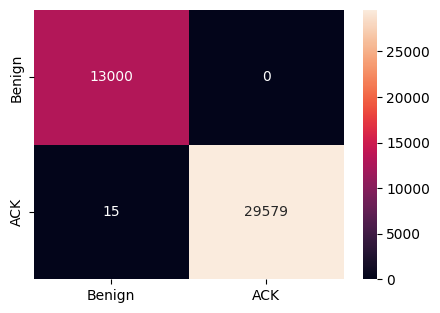





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.031     0
 1  ACK           0    1     1  DT    1        1       0.999  1      1      0.999  1        0.031     0
 2  ACK           0    1     2  DT    1        1       1      1      1      0.999  1        0.016     0
 3  ACK           0    1     3  DT    1        1       1      1      1      0.999  1        0.016     0
 4  ACK           0    1     4  DT    1        1       1      1      1      0.999  1        0.031     0
 5  ACK           0    1     5  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0.016
 6  ACK           0    1     6  DT    1        1       0.999  1      1      0.999  1        0.016     0
 7  ACK           0    1     7  DT    0.999    0

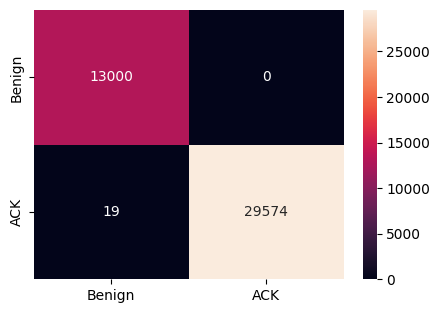





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           0    1     0  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.135     0.171
 1  ACK           0    1     1  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.164     0.172
 2  ACK           0    1     2  RF    1        1       0.999  1      1      0.999  1        1.18      0.173
 3  ACK           0    1     3  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.102     0.166
 4  ACK           0    1     4  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.117     0.158
 5  ACK           0    1     5  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.085     0.173
 6  ACK           0    1     6  RF    0.999    0.999   0.999  0.999  0.999  0.998  0.999    1.054     0.173
 7  ACK           0    1

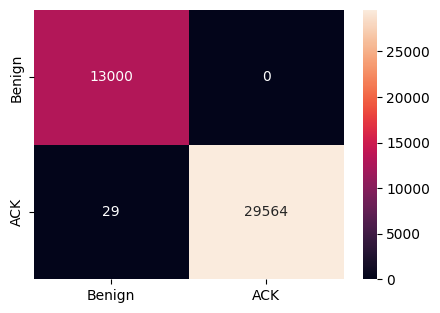





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  KNN       1        1       1      1     1  0.999      1    0.031     0.188
 1  ACK           0    1     1  KNN       1        1       1      1     1  0.999      1    0.016     0.197
 2  ACK           0    1     2  KNN       1        1       1      1     1  0.999      1    0.031     0.189
 3  ACK           0    1     3  KNN       1        1       1      1     1  0.999      1    0.047     0.189
 4  ACK           0    1     4  KNN       1        1       1      1     1  0.999      1    0.032     0.189
 5  ACK           0    1     5  KNN       1        1       1      1     1  0.999      1    0.031     0.188
 6  ACK           0    1     6  KNN       1        1       1      1     1  0.999      1    0.031     0.189
 7  ACK           0    1     7  K

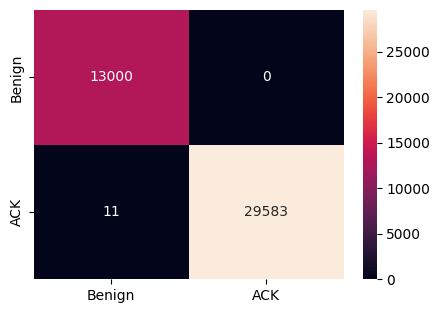





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  NB        1        1       1      1     1  0.999      1    0.013     0
 1  ACK           0    1     1  NB        1        1       1      1     1  0.999      1    0         0.016
 2  ACK           0    1     2  NB        1        1       1      1     1  0.999      1    0         0.016
 3  ACK           0    1     3  NB        1        1       1      1     1  0.999      1    0         0.013
 4  ACK           0    1     4  NB        1        1       1      1     1  0.999      1    0.016     0
 5  ACK           0    1     5  NB        1        1       1      1     1  0.999      1    0         0.016
 6  ACK           0    1     6  NB        1        1       1      1     1  0.999      1    0         0.013
 7  ACK           0    1     7  NB       

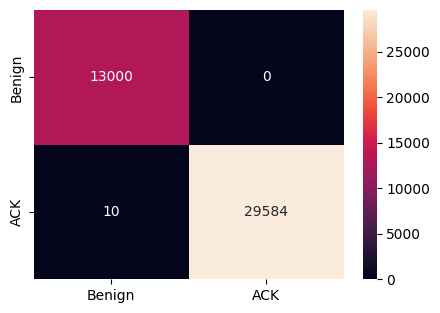





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  ACK           0    1     0  XGB       1        1   0.999      1     1  0.999      1    2.737     0.069
 1  ACK           0    1     1  XGB       1        1   0.999      1     1  0.999      1    2.864     0.063
 2  ACK           0    1     2  XGB       1        1   0.999      1     1  0.999      1    2.878     0.063
 3  ACK           0    1     3  XGB       1        1   0.999      1     1  0.999      1    3.037     0.063
 4  ACK           0    1     4  XGB       1        1   0.999      1     1  0.999      1    2.944     0.063
 5  ACK           0    1     5  XGB       1        1   0.999      1     1  0.999      1    3.255     0.063
 6  ACK           0    1     6  XGB       1        1   0.999      1     1  0.999      1    2.878     0.063
 7  ACK           0    1     7  X

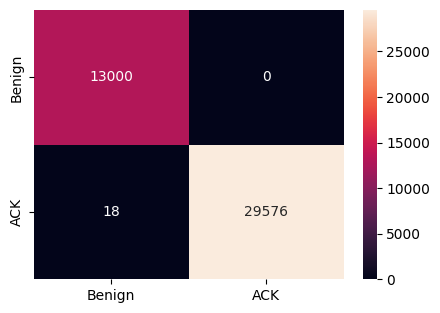





UDP
['IP_tos', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'TCP_window_sum_of_EW', 'entropy_diff', 'ts_std_2', 'TCP_window_mean_2', 'entropy_std_2', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_mean_9', 'entropy_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  LR        1    0.999       1  0.999     1  0.999  0.999    0.424     0.031
 1  UDP           0    1     1  LR        1    0.999       1  0.999     1  0.999  0.999    0.425     0.031
 2  UDP           0    1     2  LR        1    0.999       1  0.999     1  0.999  0.999    0.422     0.016
 3  UDP           0    1     3  LR        1    0.999       1  0.999     1  0.999  0.999   

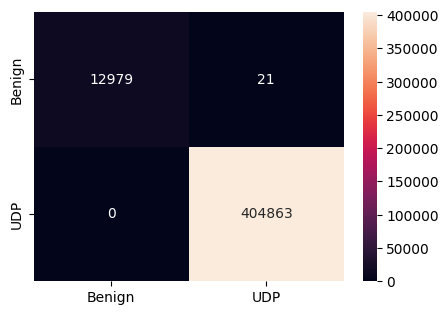





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  DT    1        1       1      1      1      1      1        0.047     0.063
 1  UDP           0    1     1  DT    1        1       1      1      1      1      1        0.032     0.047
 2  UDP           0    1     2  DT    0.566    0.776   0.533  0.776  0.418  0.071  0.776    0.055     0.037
 3  UDP           0    1     3  DT    1        1       1      1      1      1      1        0.032     0.047
 4  UDP           0    1     4  DT    0.566    0.776   0.533  0.776  0.418  0.071  0.776    0.047     0.063
 5  UDP           0    1     5  DT    1        1       1      1      1      1      1        0.031     0.063
 6  UDP           0    1     6  DT    1        1       1      1      1      1      1        0.023     0.079
 7  UDP           0    1

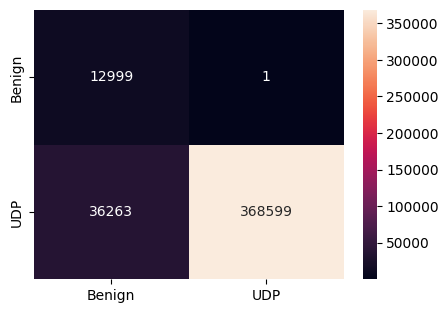





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  RF        1        1       1      1     1      1      1    0.425     1.479
 1  UDP           0    1     1  RF        1        1       1      1     1      1      1    0.472     1.573
 2  UDP           0    1     2  RF        1        1       1      1     1      1      1    0.456     1.511
 3  UDP           0    1     3  RF        1        1       1      1     1      1      1    0.456     1.512
 4  UDP           0    1     4  RF        1        1       1      1     1      1      1    0.452     1.495
 5  UDP           0    1     5  RF        1        1       1      1     1      1      1    0.44      1.495
 6  UDP           0    1     6  RF        1        1       1      1     1      1      1    0.472     1.479
 7  UDP           0    1     7  R

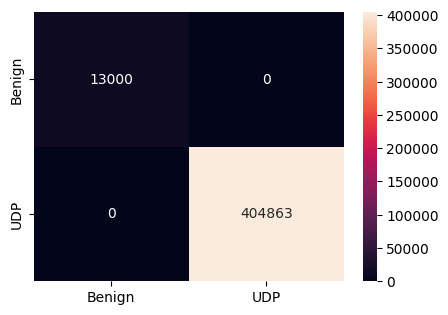





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  KNN       1        1       1      1     1      1      1    0.063   196.889
 1  UDP           0    1     1  KNN       1        1       1      1     1      1      1    0.063   197.044
 2  UDP           0    1     2  KNN       1        1       1      1     1      1      1    0.063   196.683
 3  UDP           0    1     3  KNN       1        1       1      1     1      1      1    0.06    197.299
 4  UDP           0    1     4  KNN       1        1       1      1     1      1      1    0.058   196.711
 5  UDP           0    1     5  KNN       1        1       1      1     1      1      1    0.063   196.882
 6  UDP           0    1     6  KNN       1        1       1      1     1      1      1    0.063   196.357
 7  UDP           0    1     7  K

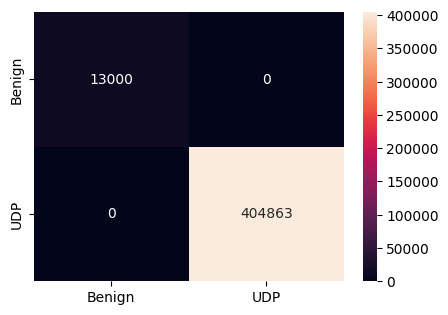





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           0    1     0  NB    0.998    0.969   0.999  0.969  0.983  0.967  0.969    0.016     0.345
 1  UDP           0    1     1  NB    0.998    0.969   0.999  0.969  0.983  0.967  0.969    0         0.346
 2  UDP           0    1     2  NB    0.998    0.969   0.999  0.969  0.983  0.967  0.969    0.016     0.362
 3  UDP           0    1     3  NB    0.998    0.969   0.999  0.969  0.983  0.967  0.969    0.016     0.252
 4  UDP           0    1     4  NB    0.998    0.969   0.999  0.969  0.983  0.967  0.969    0.016     0.377
 5  UDP           0    1     5  NB    0.998    0.969   0.999  0.969  0.983  0.967  0.969    0.016     0.362
 6  UDP           0    1     6  NB    0.998    0.969   0.999  0.969  0.983  0.967  0.969    0.002     0.33
 7  UDP           0    1 

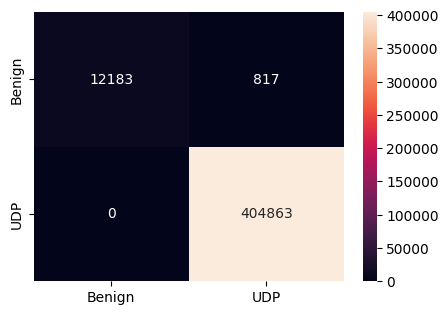





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  UDP           0    1     0  XGB       1        1       1      1     1      1      1    4.967     0.534
 1  UDP           0    1     1  XGB       1        1       1      1     1      1      1    4.212     0.582
 2  UDP           0    1     2  XGB       1        1       1      1     1      1      1    4.257     0.567
 3  UDP           0    1     3  XGB       1        1       1      1     1      1      1    3.963     0.55
 4  UDP           0    1     4  XGB       1        1       1      1     1      1      1    4.089     0.535
 5  UDP           0    1     5  XGB       1        1       1      1     1      1      1    6.619     0.597
 6  UDP           0    1     6  XGB       1        1       1      1     1      1      1    6.641     0.519
 7  UDP           0    1     7  XG

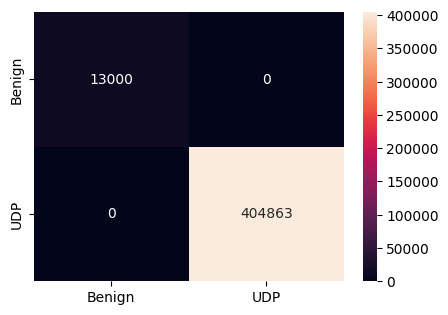





ARP
['Ether_type', 'IP_tos', 'IP_flags', 'IP_MF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_reserved', 'TCP_ACK', 'TCP_ECE', 'TCP_CWR', 'UDP_len', 'DNS_qr', 'DNS_ra', 'DNS_qdcount', 'DNS_nscount', 'DNS_arcount', 'payload_bytes', 'entropy', 'Protocol', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_mean_WE', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'entropy_mean_2', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_CWR_ratio', 'TCP_RST_SR', 'TCP_PSH_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'entropy_mean_6', 'entropy_std_6', 'pck_size_mean_9', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_std_9', 'TCP_SYN_R', 'Label']
  

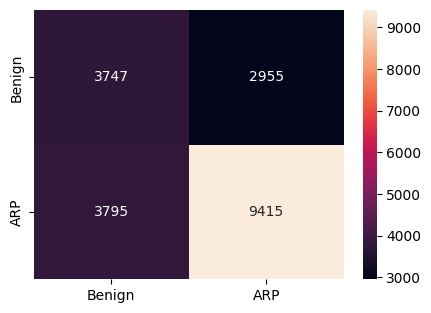





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  DT    0.668    0.616   0.623  0.616  0.618  0.237  0.616    0.503     0
 1  ARP           0    1     1  DT    0.608    0.514   0.519  0.514  0.506  0.032  0.514    0.582     0
 2  ARP           0    1     2  DT    0.655    0.593   0.603  0.593  0.596  0.194  0.593    0.44      0.016
 3  ARP           0    1     3  DT    0.675    0.606   0.625  0.606  0.61   0.226  0.606    0.56      0.016
 4  ARP           0    1     4  DT    0.642    0.57    0.582  0.57   0.571  0.149  0.57     0.567     0
 5  ARP           0    1     5  DT    0.652    0.579   0.594  0.579  0.581  0.169  0.579    0.582     0
 6  ARP           0    1     6  DT    0.68     0.641   0.642  0.641  0.641  0.283  0.641    0.582     0
 7  ARP           0    1     7  DT    0.681 

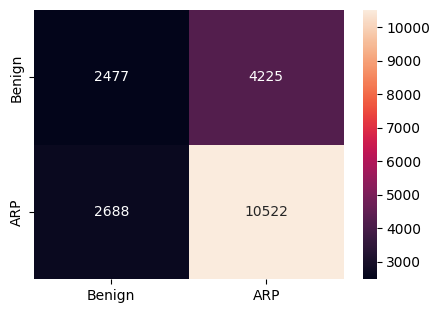





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  RF    0.74     0.666   0.717  0.666  0.677  0.364  0.666   13.199     0.32
 1  ARP           0    1     1  RF    0.757    0.689   0.738  0.689  0.701  0.409  0.689   13.409     0.331
 2  ARP           0    1     2  RF    0.734    0.657   0.708  0.657  0.666  0.345  0.657   13.417     0.33
 3  ARP           0    1     3  RF    0.713    0.632   0.678  0.632  0.639  0.292  0.632   13.208     0.346
 4  ARP           0    1     4  RF    0.74     0.664   0.718  0.664  0.674  0.361  0.664   13.564     0.335
 5  ARP           0    1     5  RF    0.759    0.692   0.741  0.692  0.704  0.416  0.692   13.165     0.315
 6  ARP           0    1     6  RF    0.733    0.655   0.708  0.655  0.664  0.341  0.655   13.407     0.33
 7  ARP           0    1   

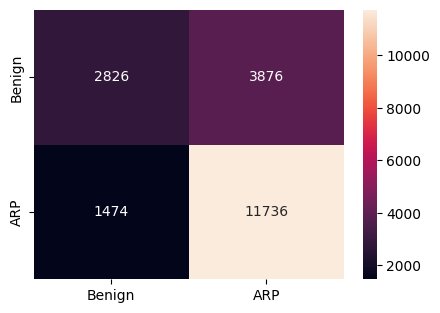





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  KNN   0.688    0.604   0.641  0.604  0.607   0.23  0.604    0.267     0.708
 1  ARP           0    1     1  KNN   0.688    0.604   0.641  0.604  0.607   0.23  0.604    0.251     0.707
 2  ARP           0    1     2  KNN   0.688    0.604   0.641  0.604  0.607   0.23  0.604    0.299     0.708
 3  ARP           0    1     3  KNN   0.688    0.604   0.641  0.604  0.607   0.23  0.604    0.283     0.724
 4  ARP           0    1     4  KNN   0.688    0.604   0.641  0.604  0.607   0.23  0.604    0.205     0.283
 5  ARP           0    1     5  KNN   0.688    0.604   0.641  0.604  0.607   0.23  0.604    0.268     0.708
 6  ARP           0    1     6  KNN   0.688    0.604   0.641  0.604  0.607   0.23  0.604    0.268     0.708
 7  ARP           0    1

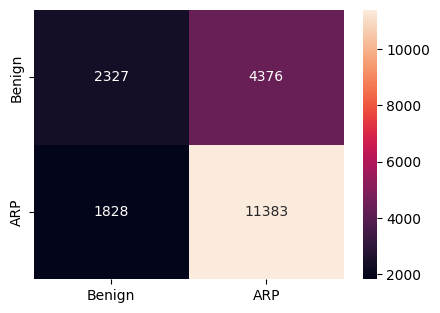





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  NB    0.662    0.502   0.545  0.502  0.411  0.006  0.502    0.016     0.032
 1  ARP           0    1     1  NB    0.662    0.502   0.545  0.502  0.411  0.006  0.502    0.031     0.044
 2  ARP           0    1     2  NB    0.662    0.502   0.545  0.502  0.411  0.006  0.502    0.031     0.031
 3  ARP           0    1     3  NB    0.662    0.502   0.545  0.502  0.411  0.006  0.502    0.02      0.043
 4  ARP           0    1     4  NB    0.662    0.502   0.545  0.502  0.411  0.006  0.502    0.032     0.031
 5  ARP           0    1     5  NB    0.662    0.502   0.545  0.502  0.411  0.006  0.502    0.016     0.047
 6  ARP           0    1     6  NB    0.662    0.502   0.545  0.502  0.411  0.006  0.502    0.022     0.041
 7  ARP           0    1

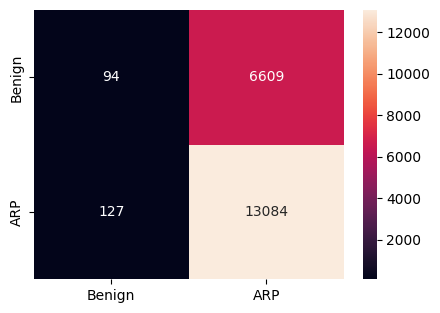





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ARP           0    1     0  XGB   0.785    0.718   0.779  0.718  0.733  0.475  0.718   15.253     0.11
 1  ARP           0    1     1  XGB   0.785    0.718   0.779  0.718  0.733  0.475  0.718   14.833     0.1
 2  ARP           0    1     2  XGB   0.785    0.718   0.779  0.718  0.733  0.475  0.718   14.518     0.103
 3  ARP           0    1     3  XGB   0.785    0.718   0.779  0.718  0.733  0.475  0.718   15.499     0.11
 4  ARP           0    1     4  XGB   0.785    0.718   0.779  0.718  0.733  0.475  0.718   14.864     0.126
 5  ARP           0    1     5  XGB   0.785    0.718   0.779  0.718  0.733  0.475  0.718   15.625     0.085
 6  ARP           0    1     6  XGB   0.785    0.718   0.779  0.718  0.733  0.475  0.718   13.679     0.126
 7  ARP           0    1    

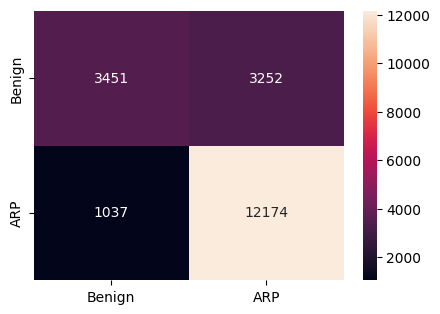





SP
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'entropy_sum_of_EW', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  LR        1        1       1      1     1      1      1    0.079         0
 1  SP            0    1     1  LR        1        1       1      1     1      1      1    0.047         0
 2  SP            0    1     2  LR        1        1       1      1     1      1      1    0.079         0
 3  SP            0    1     3  LR        1        1       1      1     1      1      1    0.058         0
 4  SP            0    1     4  LR        1        1       1      1     1      1      1    0.063         0
 5  SP            0    1     5  LR        1        1       1      1     1      1      1    0.063         0


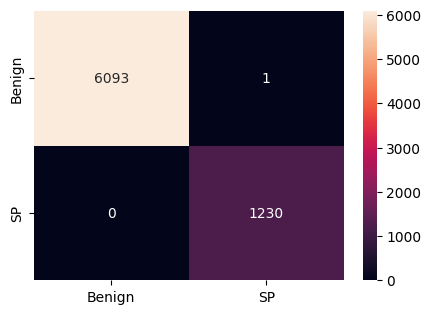





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  DT        1        1       1      1     1      1      1    0.016     0
 1  SP            0    1     1  DT        1        1       1      1     1      1      1    0         0
 2  SP            0    1     2  DT        1        1       1      1     1      1      1    0.016     0
 3  SP            0    1     3  DT        1        1       1      1     1      1      1    0.016     0
 4  SP            0    1     4  DT        1        1       1      1     1      1      1    0.016     0
 5  SP            0    1     5  DT        1        1       1      1     1      1      1    0.008     0
 6  SP            0    1     6  DT        1        1       1      1     1      1      1    0.016     0
 7  SP            0    1     7  DT        1        1       1 

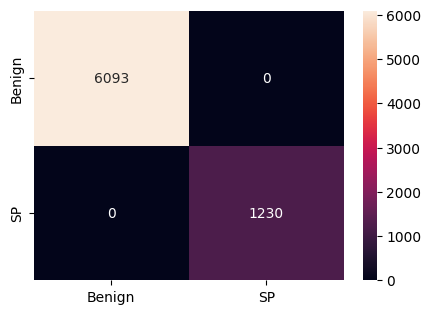





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  RF        1        1       1      1     1      1      1    0.016     0
 1  SP            0    1     1  RF        1        1       1      1     1      1      1    0         0.016
 2  SP            0    1     2  RF        1        1       1      1     1      1      1    0.013     0.004
 3  SP            0    1     3  RF        1        1       1      1     1      1      1    0.016     0
 4  SP            0    1     4  RF        1        1       1      1     1      1      1    0.007     0.009
 5  SP            0    1     5  RF        1        1       1      1     1      1      1    0.016     0
 6  SP            0    1     6  RF        1        1       1      1     1      1      1    0.015     0
 7  SP            0    1     7  RF        1      

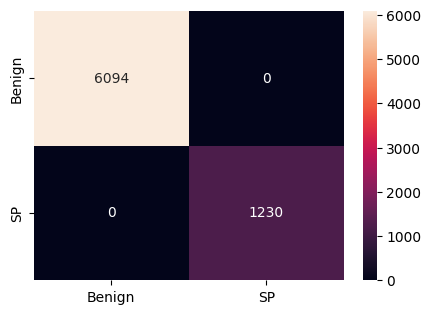





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  KNN       1        1       1      1     1      1      1    0.016     0.062
 1  SP            0    1     1  KNN       1        1       1      1     1      1      1    0.031     0.047
 2  SP            0    1     2  KNN       1        1       1      1     1      1      1    0.016     0.079
 3  SP            0    1     3  KNN       1        1       1      1     1      1      1    0.016     0.063
 4  SP            0    1     4  KNN       1        1       1      1     1      1      1    0.027     0.047
 5  SP            0    1     5  KNN       1        1       1      1     1      1      1    0.031     0.047
 6  SP            0    1     6  KNN       1        1       1      1     1      1      1    0.031     0.047
 7  SP            0    1     7  K

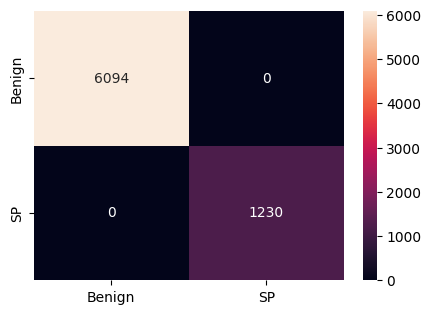





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            0    1     0  NB    0.978    0.987   0.942  0.987  0.963  0.925  0.987    0.016     0
 1  SP            0    1     1  NB    0.978    0.987   0.942  0.987  0.963  0.925  0.987    0.016     0.005
 2  SP            0    1     2  NB    0.978    0.987   0.942  0.987  0.963  0.925  0.987    0         0.016
 3  SP            0    1     3  NB    0.978    0.987   0.942  0.987  0.963  0.925  0.987    0         0
 4  SP            0    1     4  NB    0.978    0.987   0.942  0.987  0.963  0.925  0.987    0         0
 5  SP            0    1     5  NB    0.978    0.987   0.942  0.987  0.963  0.925  0.987    0         0
 6  SP            0    1     6  NB    0.978    0.987   0.942  0.987  0.963  0.925  0.987    0         0
 7  SP            0    1     7  NB    0.978 

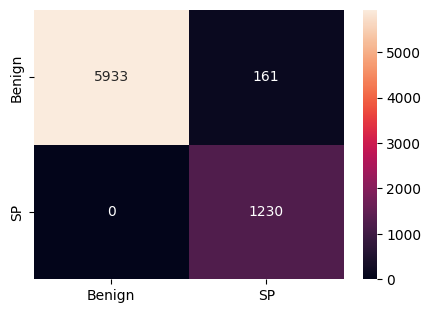





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SP            0    1     0  XGB       1        1       1      1     1  0.999      1    1.589     0.016
 1  SP            0    1     1  XGB       1        1       1      1     1  0.999      1    2.117     0.008
 2  SP            0    1     2  XGB       1        1       1      1     1  0.999      1    1.997     0.016
 3  SP            0    1     3  XGB       1        1       1      1     1  0.999      1    2.345     0.016
 4  SP            0    1     4  XGB       1        1       1      1     1  0.999      1    1.761     0.016
 5  SP            0    1     5  XGB       1        1       1      1     1  0.999      1    1.841     0.016
 6  SP            0    1     6  XGB       1        1       1      1     1  0.999      1    1.904     0.016
 7  SP            0    1     7  X

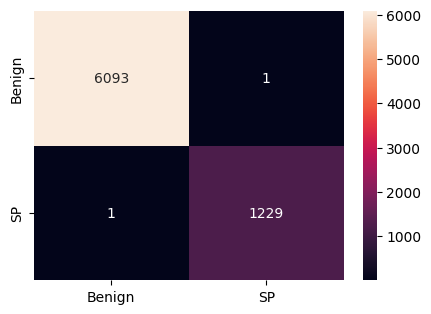





BF
['payload_bytes', 'pck_size_diff', 'TCP_window_diff', 'entropy_mean_WE', 'pck_size_mean_2', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_ratio', 'TCP_FIN_SR', 'pck_size_mean_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  LR    0.895    0.911   0.522  0.911  0.516  0.077  0.911    0.189     0.016
 1  BF            0    1     1  LR    0.896    0.91    0.523  0.91   0.516  0.077  0.91     0.173     0
 2  BF            0    1     2  LR    0.896    0.911   0.523  0.9

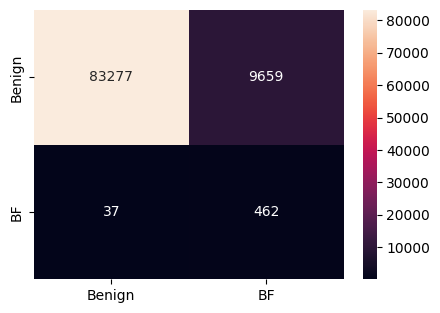





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  DT    0.827    0.873   0.514  0.873  0.48   0.044  0.873    0.047     0.016
 1  BF            0    1     1  DT    0.827    0.875   0.514  0.875  0.48   0.044  0.875    0.031     0.016
 2  BF            0    1     2  DT    0.827    0.875   0.514  0.875  0.48   0.044  0.875    0.047     0.016
 3  BF            0    1     3  DT    0.839    0.879   0.515  0.879  0.485  0.048  0.879    0.031     0.016
 4  BF            0    1     4  DT    0.828    0.875   0.514  0.875  0.48   0.044  0.875    0.032     0.016
 5  BF            0    1     5  DT    0.839    0.875   0.514  0.875  0.485  0.047  0.875    0.047     0.016
 6  BF            0    1     6  DT    0.828    0.875   0.514  0.875  0.48   0.044  0.875    0.047     0.016
 7  BF            0    1

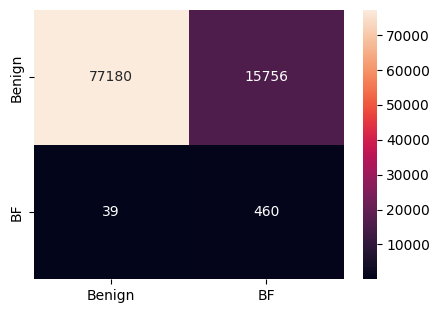





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  RF    0.999    0.964   0.983  0.964  0.973  0.947  0.964    2.408     1.034
 1  BF            0    1     1  RF    0.999    0.962   0.985  0.962  0.973  0.946  0.962    2.567     1.007
 2  BF            0    1     2  RF    0.999    0.965   0.986  0.965  0.975  0.951  0.965    2.423     1.023
 3  BF            0    1     3  RF    0.999    0.963   0.984  0.963  0.973  0.947  0.963    2.407     1.054
 4  BF            0    1     4  RF    0.999    0.965   0.986  0.965  0.975  0.951  0.965    2.533     1.039
 5  BF            0    1     5  RF    0.999    0.965   0.982  0.965  0.973  0.947  0.965    2.493     1.039
 6  BF            0    1     6  RF    0.999    0.962   0.986  0.962  0.974  0.947  0.962    2.361     1.038
 7  BF            0    1

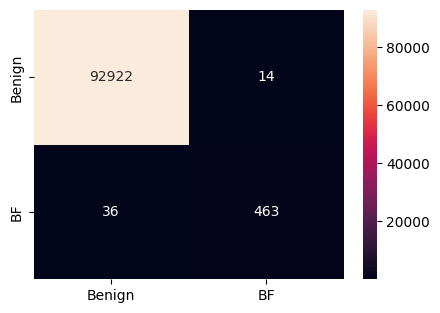





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  KNN   0.998    0.987   0.877  0.987  0.925   0.85  0.987    0         2.203
 1  BF            0    1     1  KNN   0.998    0.987   0.877  0.987  0.925   0.85  0.987    0         2.107
 2  BF            0    1     2  KNN   0.998    0.987   0.877  0.987  0.925   0.85  0.987    0         2.079
 3  BF            0    1     3  KNN   0.998    0.987   0.877  0.987  0.925   0.85  0.987    0         2.187
 4  BF            0    1     4  KNN   0.998    0.987   0.877  0.987  0.925   0.85  0.987    0         2.14
 5  BF            0    1     5  KNN   0.998    0.987   0.877  0.987  0.925   0.85  0.987    0.016     2.218
 6  BF            0    1     6  KNN   0.998    0.987   0.877  0.987  0.925   0.85  0.987    0         2.117
 7  BF            0    1 

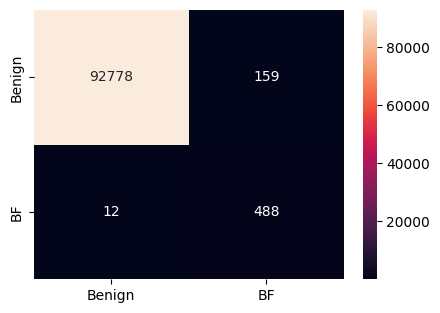





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  NB     0.98    0.747   0.566  0.747  0.601  0.206  0.747    0         0.094
 1  BF            0    1     1  NB     0.98    0.747   0.566  0.747  0.601  0.206  0.747    0         0.094
 2  BF            0    1     2  NB     0.98    0.747   0.566  0.747  0.601  0.206  0.747    0.016     0.078
 3  BF            0    1     3  NB     0.98    0.747   0.566  0.747  0.601  0.206  0.747    0.016     0.094
 4  BF            0    1     4  NB     0.98    0.747   0.566  0.747  0.601  0.206  0.747    0.016     0.078
 5  BF            0    1     5  NB     0.98    0.747   0.566  0.747  0.601  0.206  0.747    0.016     0.078
 6  BF            0    1     6  NB     0.98    0.747   0.566  0.747  0.601  0.206  0.747    0.016     0.078
 7  BF            0    1

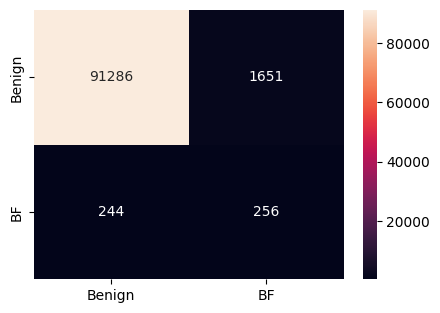





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            0    1     0  XGB   0.997     0.96   0.851   0.96  0.898  0.796   0.96    3.243     0.158
 1  BF            0    1     1  XGB   0.997     0.96   0.851   0.96  0.898  0.796   0.96    2.809     0.141
 2  BF            0    1     2  XGB   0.997     0.96   0.851   0.96  0.898  0.796   0.96    2.973     0.189
 3  BF            0    1     3  XGB   0.997     0.96   0.851   0.96  0.898  0.796   0.96    2.611     0.158
 4  BF            0    1     4  XGB   0.997     0.96   0.851   0.96  0.898  0.796   0.96    2.8       0.157
 5  BF            0    1     5  XGB   0.997     0.96   0.851   0.96  0.898  0.796   0.96    2.78      0.158
 6  BF            0    1     6  XGB   0.997     0.96   0.851   0.96  0.898  0.796   0.96    2.596     0.173
 7  BF            0    1

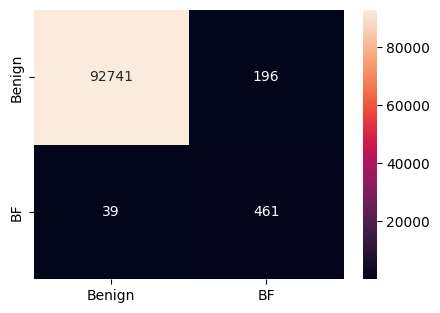





OS
['IP_ttl', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_ECE', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'dport_class', 'Protocol', 'dst_IP_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'payload_bytes_std_2', 'entropy_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_URG_ratio', 'TCP_ECE_ratio', 'TCP_CWR_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_ECE_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap   

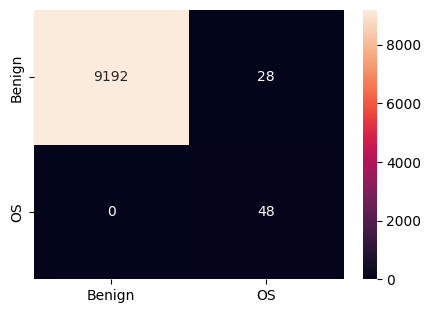





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  OS            0    1     0  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.047     0.016
 1  OS            0    1     1  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.048     0.016
 2  OS            0    1     2  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.063     0
 3  OS            0    1     3  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.063     0
 4  OS            0    1     4  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.062     0
 5  OS            0    1     5  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.063     0
 6  OS            0    1     6  DT    0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.078     0.005
 7  OS            0    1     7  DT    0.997    0.

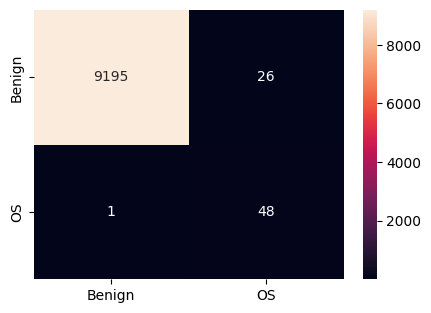





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS            0    1     0  RF    0.996    0.998   0.792  0.998  0.867   0.735  0.998    0.022     0
 1  OS            0    1     1  RF    0.99     0.498   0.497  0.498  0.497  -0.005  0.498    0.016     0
 2  OS            0    1     2  RF    0.997    0.988   0.824  0.988  0.89    0.779  0.988    0.016     0
 3  OS            0    1     3  RF    0.996    0.937   0.775  0.937  0.837   0.675  0.937    0.031     0
 4  OS            0    1     4  RF    0.997    0.988   0.82   0.988  0.886   0.773  0.988    0.016     0.016
 5  OS            0    1     5  RF    0.998    0.786   0.966  0.786  0.854   0.708  0.786    0.016     0
 6  OS            0    1     6  RF    0.997    0.999   0.822  0.999  0.891   0.783  0.999    0.032     0
 7  OS            0    1     7  RF    0

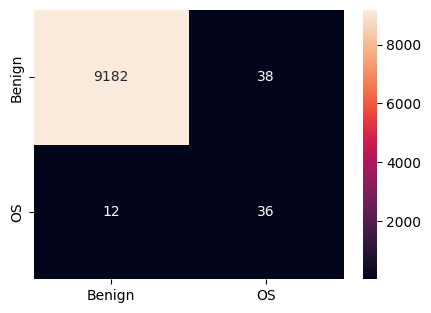





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            0    1     0  KNN   0.863     0.84   0.515   0.84  0.493   0.05   0.84    0         0.913
 1  OS            0    1     1  KNN   0.863     0.84   0.515   0.84  0.493   0.05   0.84    0         1.023
 2  OS            0    1     2  KNN   0.863     0.84   0.515   0.84  0.493   0.05   0.84    0         1.085
 3  OS            0    1     3  KNN   0.863     0.84   0.515   0.84  0.493   0.05   0.84    0         0.96
 4  OS            0    1     4  KNN   0.863     0.84   0.515   0.84  0.493   0.05   0.84    0         1.054
 5  OS            0    1     5  KNN   0.863     0.84   0.515   0.84  0.493   0.05   0.84    0         2.022
 6  OS            0    1     6  KNN   0.863     0.84   0.515   0.84  0.493   0.05   0.84    0.016     1.588
 7  OS            0    1 

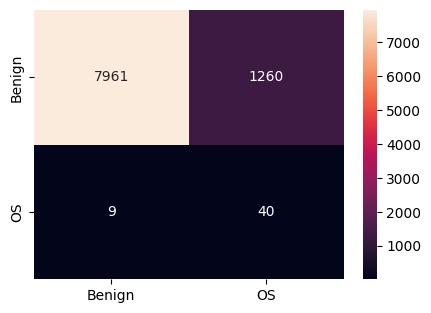





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS            0    1     0  NB    0.325    0.326   0.496  0.326  0.247  -0.005  0.326    0.016     0.016
 1  OS            0    1     1  NB    0.325    0.326   0.496  0.326  0.247  -0.005  0.326    0.016     0.031
 2  OS            0    1     2  NB    0.325    0.326   0.496  0.326  0.247  -0.005  0.326    0.016     0.016
 3  OS            0    1     3  NB    0.325    0.326   0.496  0.326  0.247  -0.005  0.326    0.016     0.016
 4  OS            0    1     4  NB    0.325    0.326   0.496  0.326  0.247  -0.005  0.326    0.016     0.016
 5  OS            0    1     5  NB    0.325    0.326   0.496  0.326  0.247  -0.005  0.326    0.016     0.016
 6  OS            0    1     6  NB    0.325    0.326   0.496  0.326  0.247  -0.005  0.326    0.016     0.031
 7  OS         

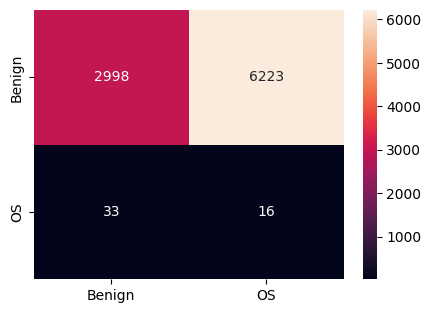





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  OS            0    1     0  XGB   0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.881     0.047
 1  OS            0    1     1  XGB   0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.644     0.016
 2  OS            0    1     2  XGB   0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.551     0.016
 3  OS            0    1     3  XGB   0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.791     0.027
 4  OS            0    1     4  XGB   0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.854     0.03
 5  OS            0    1     5  XGB   0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.708     0.031
 6  OS            0    1     6  XGB   0.997    0.988   0.824  0.988  0.89  0.779  0.988    0.821     0.031
 7  OS            0    1     7  XG

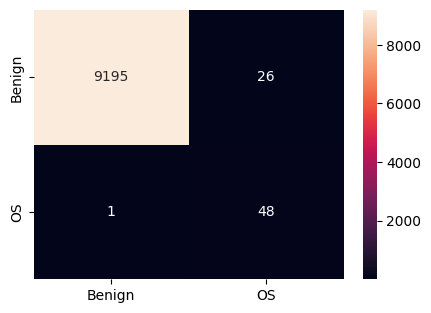





SCHD
['Ether_type', 'IP_version', 'IP_DF', 'IP_ttl', 'TCP_flags', 'TCP_options', 'dport_class', 'Protocol', 'IP_add_count', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'TCP_window_mean_WE', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'entropy_std_WE', 'pck_size_mean_2', 'ts_std_2', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  LR    0.997    0.677   0.581  0.677  0.611  0.222  0.677    0.173     0
 1  SCHD          0    1     1  LR    0.997    0.677   0.581  0.677  0.611  0.222  0.677    0.189     0
 2  SCHD          0    1     2  LR    0.997    0.677   

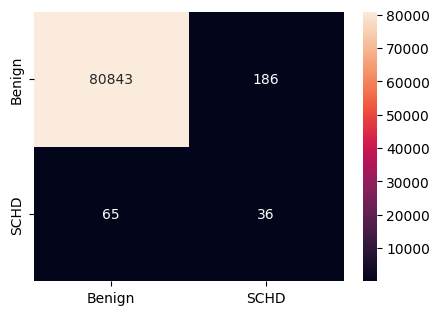





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  DT    0.999    0.703   0.872  0.703  0.763  0.525  0.703    0.047     0.016
 1  SCHD          0    1     1  DT    1        0.946   0.964  0.946  0.954  0.909  0.946    0.047     0.016
 2  SCHD          0    1     2  DT    1        0.946   0.964  0.946  0.954  0.909  0.946    0.047     0.016
 3  SCHD          0    1     3  DT    1        0.946   0.964  0.946  0.954  0.909  0.946    0.048     0.016
 4  SCHD          0    1     4  DT    0.999    0.5     0.499  0.5    0.5    0      0.5      0.031     0.016
 5  SCHD          0    1     5  DT    1        0.946   0.964  0.946  0.954  0.909  0.946    0.031     0.016
 6  SCHD          0    1     6  DT    1        0.946   0.964  0.946  0.954  0.909  0.946    0.048     0.016
 7  SCHD          0    1

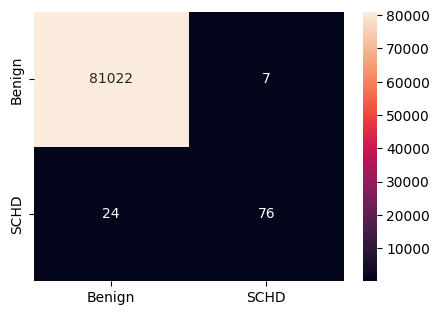





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  RF    0.999    0.792       1  0.792  0.869  0.737  0.792    0.897     0.447
 1  SCHD          0    1     1  RF    0.999    0.792       1  0.792  0.869  0.737  0.792    0.866     0.44
 2  SCHD          0    1     2  RF    0.999    0.678       1  0.678  0.763  0.525  0.678    0.881     0.456
 3  SCHD          0    1     3  RF    0.999    0.698       1  0.698  0.783  0.567  0.698    0.865     0.425
 4  SCHD          0    1     4  RF    0.999    0.698       1  0.698  0.783  0.567  0.698    0.834     0.425
 5  SCHD          0    1     5  RF    0.999    0.698       1  0.698  0.783  0.567  0.698    0.865     0.425
 6  SCHD          0    1     6  RF    1        0.802       1  0.802  0.876  0.753  0.802    0.849     0.425
 7  SCHD          0    1 

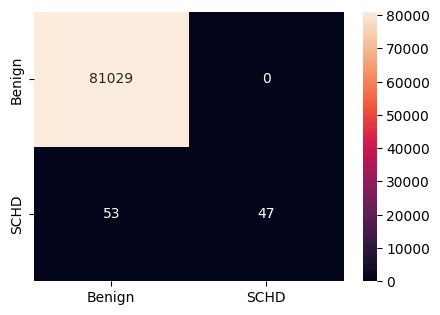





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SCHD          0    1     0  KNN   0.999    0.658       1  0.658  0.74  0.481  0.658    0.063     2.031
 1  SCHD          0    1     1  KNN   0.999    0.658       1  0.658  0.74  0.481  0.658    0.063     2.045
 2  SCHD          0    1     2  KNN   0.999    0.658       1  0.658  0.74  0.481  0.658    0.048     2.07
 3  SCHD          0    1     3  KNN   0.999    0.658       1  0.658  0.74  0.481  0.658    0.046     2.061
 4  SCHD          0    1     4  KNN   0.999    0.658       1  0.658  0.74  0.481  0.658    0.063     2.062
 5  SCHD          0    1     5  KNN   0.999    0.658       1  0.658  0.74  0.481  0.658    0.05      2.043
 6  SCHD          0    1     6  KNN   0.999    0.658       1  0.658  0.74  0.481  0.658    0.063     2.029
 7  SCHD          0    1     7  KN

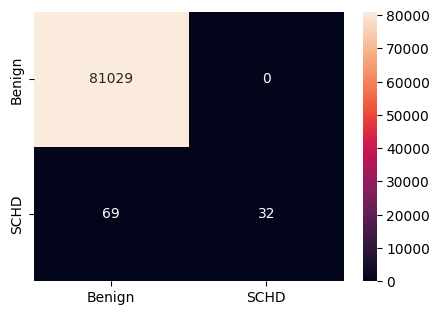





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  NB    0.996    0.998   0.616  0.998  0.687  0.375  0.998    0.013     0.087
 1  SCHD          0    1     1  NB    0.996    0.998   0.616  0.998  0.687  0.375  0.998    0         0.094
 2  SCHD          0    1     2  NB    0.996    0.998   0.616  0.998  0.687  0.375  0.998    0.016     0.094
 3  SCHD          0    1     3  NB    0.996    0.998   0.616  0.998  0.687  0.375  0.998    0.016     0.094
 4  SCHD          0    1     4  NB    0.996    0.998   0.616  0.998  0.687  0.375  0.998    0         0.079
 5  SCHD          0    1     5  NB    0.996    0.998   0.616  0.998  0.687  0.375  0.998    0.016     0.079
 6  SCHD          0    1     6  NB    0.996    0.998   0.616  0.998  0.687  0.375  0.998    0         0.079
 7  SCHD          0    1

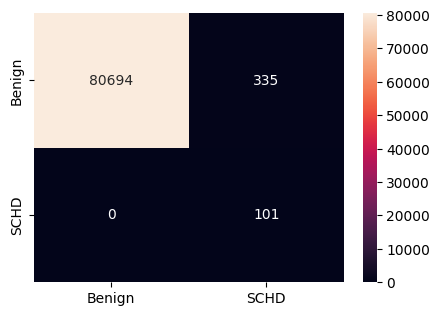





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          0    1     0  XGB       1    0.946   0.964  0.946  0.954  0.909  0.946    0.472     0.094
 1  SCHD          0    1     1  XGB       1    0.946   0.964  0.946  0.954  0.909  0.946    0.614     0.094
 2  SCHD          0    1     2  XGB       1    0.946   0.964  0.946  0.954  0.909  0.946    0.487     0.094
 3  SCHD          0    1     3  XGB       1    0.946   0.964  0.946  0.954  0.909  0.946    0.598     0.11
 4  SCHD          0    1     4  XGB       1    0.946   0.964  0.946  0.954  0.909  0.946    0.677     0.11
 5  SCHD          0    1     5  XGB       1    0.946   0.964  0.946  0.954  0.909  0.946    0.708     0.11
 6  SCHD          0    1     6  XGB       1    0.946   0.964  0.946  0.954  0.909  0.946    0.582     0.094
 7  SCHD          0    1   

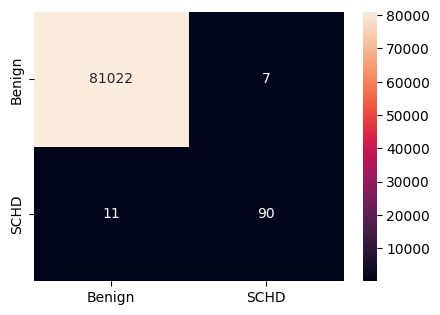





MHDis
['IP_ihl', 'IP_ttl', 'TCP_options', 'sport_class', 'Protocol', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'TCP_ACK_sum', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  LR    0.998    0.999   0.989  0.999  0.994  0.988  0.999    0.141     0
 1  MHDis         0    1     1  LR    0.998    0.999   0.989  0.999  0.994  0.988  0.999    0.126     0
 2  MHDis         0    1     2  LR    0.998    0.999   0.989  0.999  0.994  0.988  0.999    0.141     0
 3  MHDis         0    1     3  LR    0.998    0.999   0.989  0.999  0.994  0.988  0.999    0.141     0
 4  MHDis         0    1     4  LR    0.998    0.999   0.989  0.99

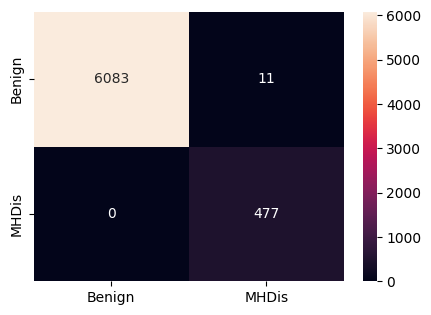





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  DT    0.995    0.964   0.996  0.964  0.98   0.959  0.964    0.016         0
 1  MHDis         0    1     1  DT    0.995    0.964   0.996  0.964  0.98   0.959  0.964    0.016         0
 2  MHDis         0    1     2  DT    0.995    0.964   0.997  0.964  0.98   0.96   0.964    0.016         0
 3  MHDis         0    1     3  DT    0.995    0.963   0.996  0.963  0.979  0.958  0.963    0.016         0
 4  MHDis         0    1     4  DT    0.995    0.963   0.996  0.963  0.979  0.958  0.963    0.016         0
 5  MHDis         0    1     5  DT    0.93     0.517   0.935  0.517  0.514  0.06   0.517    0.018         0
 6  MHDis         0    1     6  DT    0.995    0.963   0.996  0.963  0.979  0.958  0.963    0.016         0
 7  MHDis         0    1

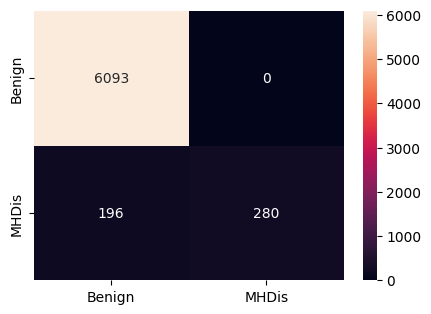





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  RF    0.994    0.962   0.996  0.962  0.978  0.957  0.962    0.362     0.053
 1  MHDis         0    1     1  RF    0.995    0.964   0.996  0.964  0.98   0.959  0.964    0.393     0.031
 2  MHDis         0    1     2  RF    0.995    0.966   0.996  0.966  0.981  0.962  0.966    0.378     0.031
 3  MHDis         0    1     3  RF    0.995    0.964   0.996  0.964  0.98   0.959  0.964    0.268     0.047
 4  MHDis         0    1     4  RF    0.995    0.964   0.996  0.964  0.98   0.959  0.964    0.382     0.043
 5  MHDis         0    1     5  RF    0.995    0.964   0.996  0.964  0.98   0.959  0.964    0.393     0.047
 6  MHDis         0    1     6  RF    0.995    0.964   0.996  0.964  0.98   0.959  0.964    0.377     0.048
 7  MHDis         0    1

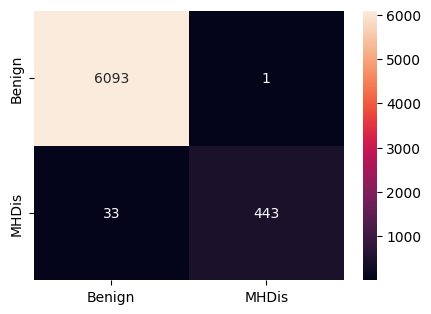





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.016     0.381
 1  MHDis         0    1     1  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.016     0.378
 2  MHDis         0    1     2  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.022     0.372
 3  MHDis         0    1     3  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.016     0.378
 4  MHDis         0    1     4  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.031     0.378
 5  MHDis         0    1     5  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.031     0.364
 6  MHDis         0    1     6  KNN   0.998    0.999   0.986  0.999  0.992  0.984  0.999    0.016     0.378
 7  MHDis         0    1

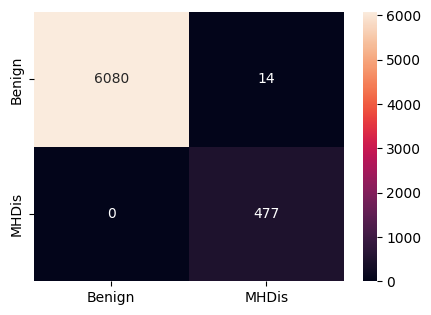





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  NB    0.917    0.955   0.734  0.955  0.795  0.597  0.955    0.016     0.004
 1  MHDis         0    1     1  NB    0.917    0.955   0.734  0.955  0.795  0.597  0.955    0         0.016
 2  MHDis         0    1     2  NB    0.917    0.955   0.734  0.955  0.795  0.597  0.955    0.016     0
 3  MHDis         0    1     3  NB    0.917    0.955   0.734  0.955  0.795  0.597  0.955    0         0
 4  MHDis         0    1     4  NB    0.917    0.955   0.734  0.955  0.795  0.597  0.955    0         0
 5  MHDis         0    1     5  NB    0.917    0.955   0.734  0.955  0.795  0.597  0.955    0.016     0
 6  MHDis         0    1     6  NB    0.917    0.955   0.734  0.955  0.795  0.597  0.955    0         0.016
 7  MHDis         0    1     7  NB    0.

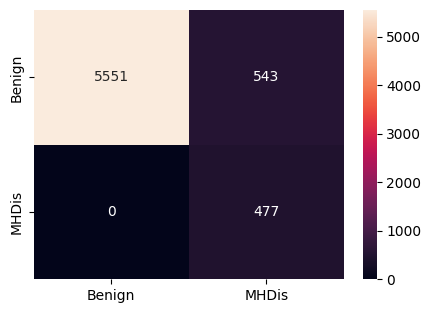





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         0    1     0  XGB   0.959    0.719   0.977  0.719  0.793   0.59  0.719    2.754     0.032
 1  MHDis         0    1     1  XGB   0.959    0.719   0.977  0.719  0.793   0.59  0.719    3.459     0.031
 2  MHDis         0    1     2  XGB   0.959    0.719   0.977  0.719  0.793   0.59  0.719    3.429     0.016
 3  MHDis         0    1     3  XGB   0.959    0.719   0.977  0.719  0.793   0.59  0.719    2.926     0.016
 4  MHDis         0    1     4  XGB   0.959    0.719   0.977  0.719  0.793   0.59  0.719    3.272     0.016
 5  MHDis         0    1     5  XGB   0.959    0.719   0.977  0.719  0.793   0.59  0.719    2.941     0.032
 6  MHDis         0    1     6  XGB   0.959    0.719   0.977  0.719  0.793   0.59  0.719    3.114     0.031
 7  MHDis         0    1

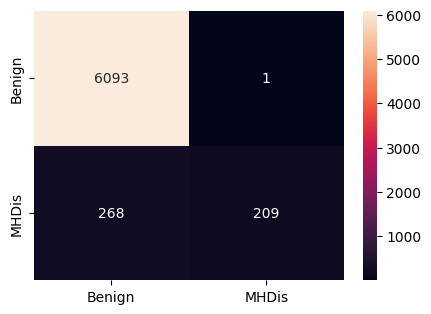

In [17]:
folder("results/val/")

for file in file_list:
    print(file)
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/val/{file}_VAL_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,0)   


In [18]:
import time

# sleep for 3 seconds
print('Sleep time: ', str(3600), 'seconds')
time.sleep(3600)
print('Woke up after: ', str(3), 'seconds')


Sleep time:  3600 seconds
Woke up after:  3 seconds


# TEST

In [19]:
file_list={'SYN': ['./INPUT/SM/DoS-SYN-1.csv',  './INPUT/TEST/small_Edge_IIoT_DDoS_TCP_SYN_Flood_Attacks_00000_20211124180237._SW.csv'],
 'HTTP': ['./INPUT/SM/MB-HTTP-4.csv',  './INPUT/TEST/NetatmoCamHTTPFlood_1_SW.csv'],
'ACK': ['./INPUT/SM/MB-ACK-4.csv',  './INPUT/TEST/NetatmoCamTCPFlood_3_SW.csv'],
 'UDP': ['./INPUT/SM/MB-UDP-4.csv',  './INPUT/TEST/Bot_IoT_UDP_DDoS_00001._SW.csv'],
 'ARP': ['./INPUT/SM/MitM-ARP-6.csv',   './INPUT/TEST/Kitsune_ARP_MitM._SW.csv'],
 'SP': ['./INPUT/SM/Scan-Port-3.csv', './INPUT/TEST/IoT_ENV_[Port_scan]Google_Home_Mini_SW.csv'],
 'BF': ['./INPUT/SM/MB-BF-5.csv',  './INPUT/TEST/AmcrestCamBruteForce_1_SW.csv'],
 'OS': ['./INPUT/SM/Scan-OS-3.csv',  './INPUT/TEST/IoT_ENV_[OS_Service_Detection]Google_Home_Mini_SW.csv'],
"SCHD":['./INPUT/SM/Scan-HDis-3.csv','./INPUT/SW/MB-HDis-3.csv'],
"MHDis":['./INPUT/SM/MB-HDis-3.csv','./INPUT/SW/Scan-HDis-3.csv' ]}

SYN
['ts', 'IP_flags', 'IP_DF', 'TCP_dataofs', 'TCP_SYN', 'TCP_ACK', 'sport_class', 'dst_IP_diversity', 'dst_port_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_std_WE', 'pck_size_mean_2', 'ts_mean_2', 'ts_std_2', 'TCP_window_mean_2', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'ts_std_6', 'pck_size_mean_9', 'ts_mean_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.063     0.097
 1  SYN           1    1     1  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.049     0.067
 2  SYN           1    1     2  LR    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.063     0.062
 3  SYN      

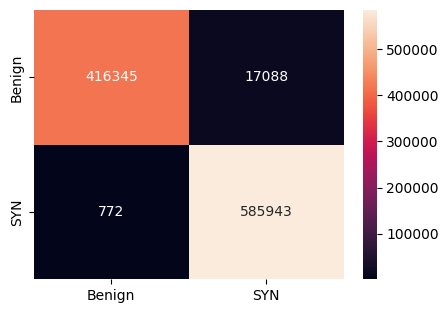





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  DT    1        1       1      1      1      1      1        0.016     0.169
 1  SYN           1    1     1  DT    0.427    0.502   0.713  0.502  0.302  0.003  0.502    0.028     0.162
 2  SYN           1    1     2  DT    1        1       1      1      1      1      1        0.016     0.204
 3  SYN           1    1     3  DT    1        1       1      1      1      1      1        0.01      0.157
 4  SYN           1    1     4  DT    1        1       1      1      1      1      1        0.016     0.196
 5  SYN           1    1     5  DT    0.999    0.999   0.999  0.999  0.999  0.998  0.999    0.016     0.172
 6  SYN           1    1     6  DT    1        1       1      1      1      1      1        0.016     0.204
 7  SYN           1    1

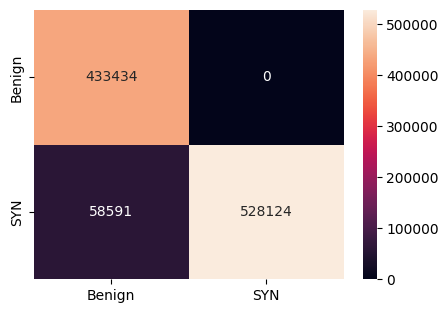





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  RF        1        1       1      1     1      1      1    1.178     8.276
 1  SYN           1    1     1  RF        1        1       1      1     1      1      1    1.255     8.426
 2  SYN           1    1     2  RF        1        1       1      1     1      1      1    1.146     8.262
 3  SYN           1    1     3  RF        1        1       1      1     1      1      1    1.091     8.281
 4  SYN           1    1     4  RF        1        1       1      1     1      1      1    1.154     8.007
 5  SYN           1    1     5  RF        1        1       1      1     1      1      1    1.178     8.361
 6  SYN           1    1     6  RF        1        1       1      1     1      1      1    1.194     8.294
 7  SYN           1    1     7  R

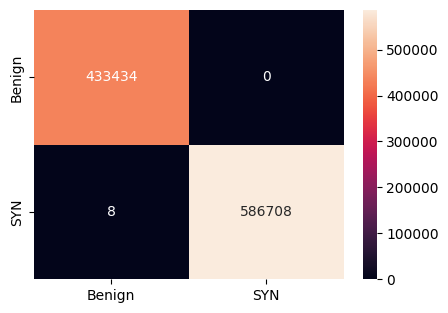





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.14     60.761
 1  SYN           1    1     1  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.103    67.732
 2  SYN           1    1     2  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.105    68.925
 3  SYN           1    1     3  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.083    67.94
 4  SYN           1    1     4  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.094    66.964
 5  SYN           1    1     5  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.107    67.073
 6  SYN           1    1     6  KNN   0.425      0.5   0.212    0.5  0.298     -0    0.5    0.11     66.064
 7  SYN           1    1 

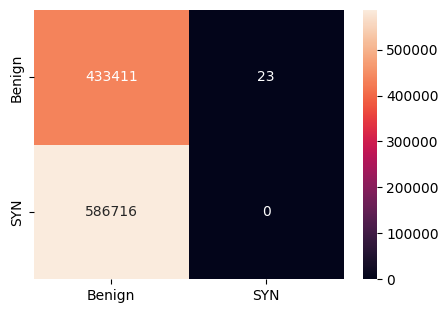





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SYN           1    1     0  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.015     0.904
 1  SYN           1    1     1  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016     0.768
 2  SYN           1    1     2  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016     0.835
 3  SYN           1    1     3  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0         0.792
 4  SYN           1    1     4  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.017     0.771
 5  SYN           1    1     5  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0         0.802
 6  SYN           1    1     6  NB    0.998    0.998   0.998  0.998  0.998  0.996  0.998    0.016     0.791
 7  SYN           1    1

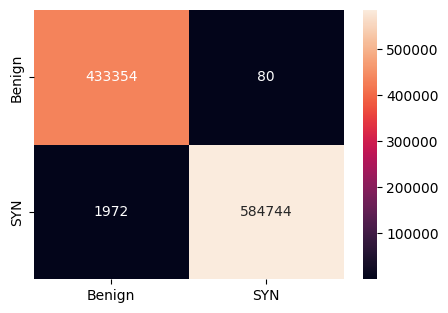





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  SYN           1    1     0  XGB       1        1       1      1     1      1      1    5.765     1.485
 1  SYN           1    1     1  XGB       1        1       1      1     1      1      1    5.654     1.576
 2  SYN           1    1     2  XGB       1        1       1      1     1      1      1    5.651     1.429
 3  SYN           1    1     3  XGB       1        1       1      1     1      1      1    5.804     1.499
 4  SYN           1    1     4  XGB       1        1       1      1     1      1      1    5.725     1.495
 5  SYN           1    1     5  XGB       1        1       1      1     1      1      1    5.704     1.459
 6  SYN           1    1     6  XGB       1        1       1      1     1      1      1    5.883     1.486
 7  SYN           1    1     7  X

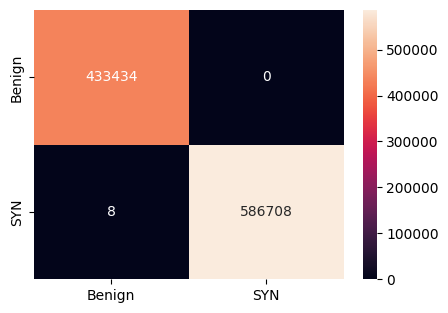





HTTP
['ts', 'TCP_flags', 'dport_class', 'pck_size_sum_of_EW', 'ts_std_WE', 'ts_sum_of_EW', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'TCP_window_mean_2', 'sport_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_PSH_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  LR     0.45      0.5   0.225    0.5  0.31     -0    0.5    0.355     0.016
 1  HTTP          1    1     1  LR     0.45      0.5   0.225    0.5  0.31     -0    0.5    0.377     0.012
 2  HTTP          1    1     2  LR     0.45      0.5   0.225    0.5  0.31     -0    0.5    0.372     0.016
 3  HTTP          1    1     3  LR     0.45      0.5   0.225    0.5  0.31     -0    0.5    0.381     0.02
 4  HTTP          1    1     4  LR     0.45      0.5   0.225    0.5  0.31   

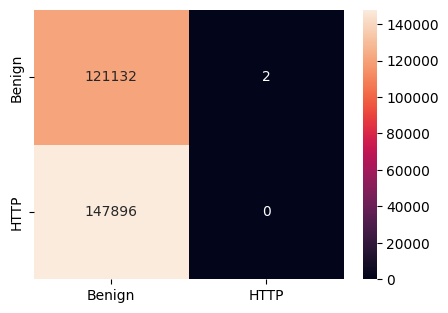





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  DT    1        1       1      1      1      1      1        0.045     0.031
 1  HTTP          1    1     1  DT    1        1       1      1      1      1      1        0.016     0.031
 2  HTTP          1    1     2  DT    1        1       1      1      1      1      1        0.016     0.031
 3  HTTP          1    1     3  DT    1        1       1      1      1      1      1        0.031     0.016
 4  HTTP          1    1     4  DT    1        1       1      1      1      1      1        0.042     0.025
 5  HTTP          1    1     5  DT    1        1       1      1      1      1      1        0.031     0.031
 6  HTTP          1    1     6  DT    1        1       1      1      1      1      1        0.047     0.031
 7  HTTP          1    1

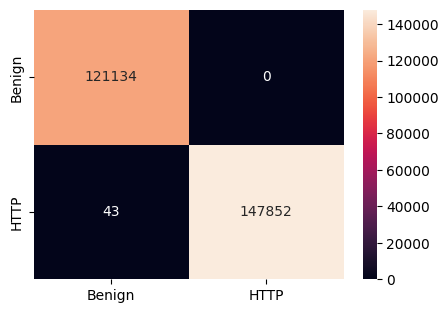





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  RF        1        1       1      1     1      1      1    1.747     1.533
 1  HTTP          1    1     1  RF        1        1       1      1     1      1      1    1.657     1.333
 2  HTTP          1    1     2  RF        1        1       1      1     1      1      1    1.872     1.564
 3  HTTP          1    1     3  RF        1        1       1      1     1      1      1    1.874     1.574
 4  HTTP          1    1     4  RF        1        1       1      1     1      1      1    1.835     1.494
 5  HTTP          1    1     5  RF        1        1       1      1     1      1      1    1.841     1.589
 6  HTTP          1    1     6  RF        1        1       1      1     1      1      1    1.794     1.541
 7  HTTP          1    1     7  R

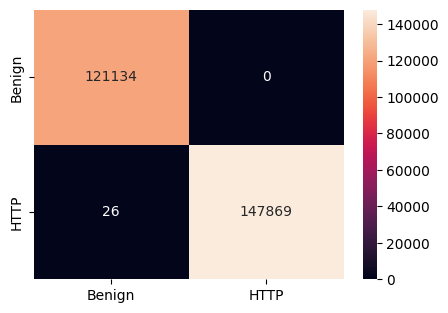





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.047     6.276
 1  HTTP          1    1     1  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.051     6.292
 2  HTTP          1    1     2  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.048     6.504
 3  HTTP          1    1     3  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.047     6.118
 4  HTTP          1    1     4  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.047     5.76
 5  HTTP          1    1     5  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.047     5.64
 6  HTTP          1    1     6  KNN   0.473     0.52    0.73   0.52  0.355  0.037   0.52    0.033     6.2
 7  HTTP          1    1    

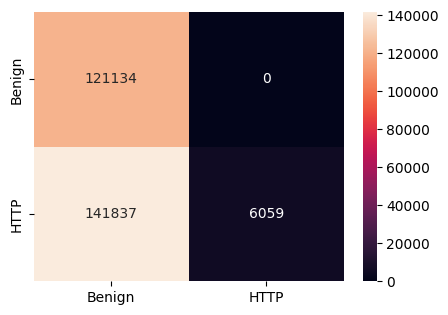





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  HTTP          1    1     0  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.109
 1  HTTP          1    1     1  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.012     0.112
 2  HTTP          1    1     2  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.111
 3  HTTP          1    1     3  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.141
 4  HTTP          1    1     4  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.125
 5  HTTP          1    1     5  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0         0.125
 6  HTTP          1    1     6  NB    0.473    0.521   0.714  0.521  0.356  0.037  0.521    0.016     0.141
 7  HTTP          1    1

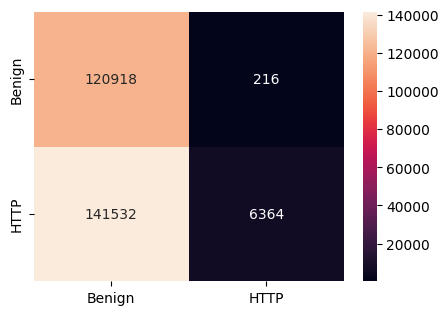





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  HTTP          1    1     0  XGB       1        1       1      1     1      1      1    2.134     0.21
 1  HTTP          1    1     1  XGB       1        1       1      1     1      1      1    2.2       0.217
 2  HTTP          1    1     2  XGB       1        1       1      1     1      1      1    2.231     0.205
 3  HTTP          1    1     3  XGB       1        1       1      1     1      1      1    2.212     0.235
 4  HTTP          1    1     4  XGB       1        1       1      1     1      1      1    2.164     0.229
 5  HTTP          1    1     5  XGB       1        1       1      1     1      1      1    2.082     0.206
 6  HTTP          1    1     6  XGB       1        1       1      1     1      1      1    2.065     0.218
 7  HTTP          1    1     7  XG

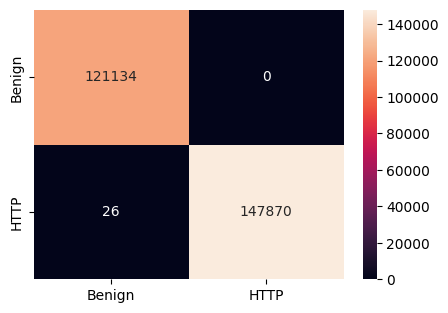





ACK
['payload_bytes_mean_WE', 'sport_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'ts_mean_6', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.082     0
 1  ACK           1    1     1  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.086     0.002
 2  ACK           1    1     2  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.081     0.002
 3  ACK           1    1     3  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.082     0.001
 4  ACK           1    1     4  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.082     0
 5  ACK           1    1     5  LR    0.989    0.992    0.98  0.992  0.986  0.972  0.992    0.085     0
 6  ACK           1    1     6  LR    0.989    0

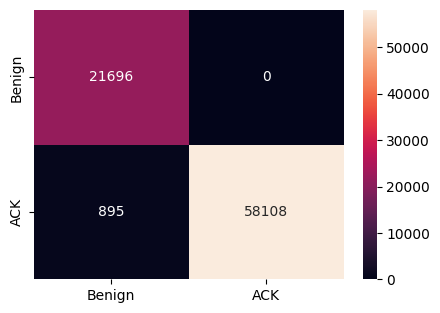





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.026     0.003
 1  ACK           1    1     1  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.012     0
 2  ACK           1    1     2  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.015     0.009
 3  ACK           1    1     3  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.02      0.004
 4  ACK           1    1     4  DT    0.997    0.998   0.995  0.998  0.997  0.993  0.998    0.011     0
 5  ACK           1    1     5  DT    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.021     0.005
 6  ACK           1    1     6  DT    0.269    0.5     0.134  0.5    0.212  0      0.5      0.016     0.01
 7  ACK           1    1     7  D

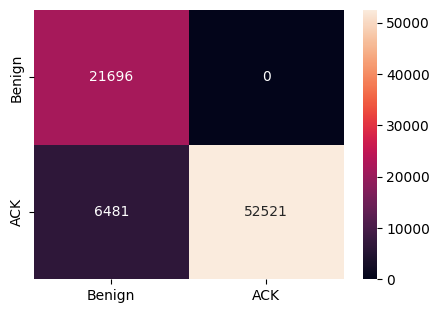





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.98      0.312
 1  ACK           1    1     1  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.948     0.279
 2  ACK           1    1     2  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.87      0.273
 3  ACK           1    1     3  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.927     0.302
 4  ACK           1    1     4  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    1.022     0.33
 5  ACK           1    1     5  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.928     0.273
 6  ACK           1    1     6  RF    0.991    0.994   0.984  0.994  0.989  0.978  0.994    0.944     0.288
 7  ACK           1    1 

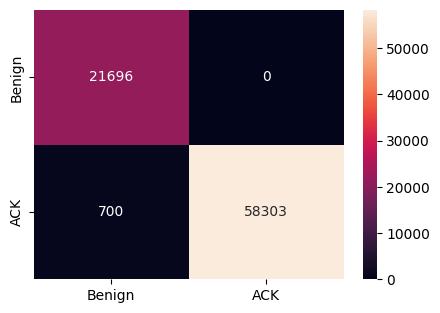





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.03      1.533
 1  ACK           1    1     1  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.03      1.569
 2  ACK           1    1     2  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.029     1.559
 3  ACK           1    1     3  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.024     1.558
 4  ACK           1    1     4  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.03      1.569
 5  ACK           1    1     5  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.03      1.564
 6  ACK           1    1     6  KNN   0.269      0.5   0.134    0.5  0.212      0    0.5    0.029     1.591
 7  ACK           1    1

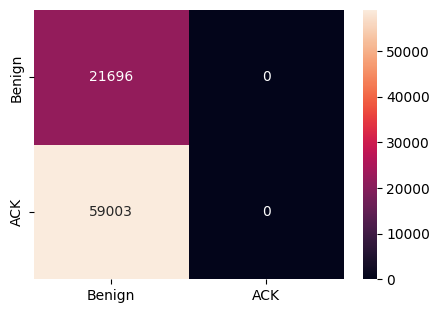





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.009     0.011
 1  ACK           1    1     1  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.013     0.015
 2  ACK           1    1     2  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.009     0.012
 3  ACK           1    1     3  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.004     0.013
 4  ACK           1    1     4  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.012     0.011
 5  ACK           1    1     5  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.005     0.005
 6  ACK           1    1     6  NB    0.269      0.5   0.134    0.5  0.212      0    0.5    0.004     0.004
 7  ACK           1    1

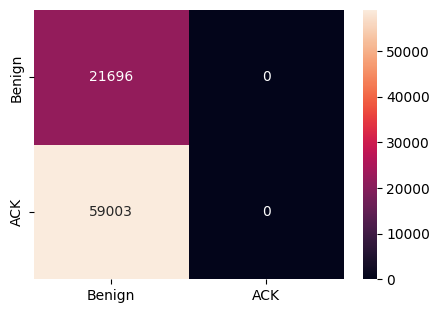





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  ACK           1    1     0  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.758     0.071
 1  ACK           1    1     1  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.838     0.082
 2  ACK           1    1     2  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.825     0.079
 3  ACK           1    1     3  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.763     0.079
 4  ACK           1    1     4  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.825     0.078
 5  ACK           1    1     5  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.838     0.089
 6  ACK           1    1     6  XGB   0.991    0.994   0.985  0.994  0.989  0.978  0.994    1.709     0.094
 7  ACK           1    1

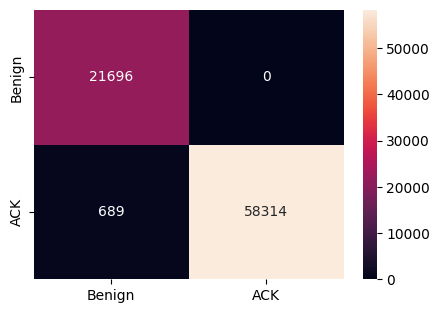





UDP
['IP_tos', 'IP_DF', 'IP_proto', 'TCP_dataofs', 'TCP_window', 'TCP_options', 'sport_class', 'Protocol', 'TCP_window_sum_of_EW', 'entropy_diff', 'ts_std_2', 'TCP_window_mean_2', 'entropy_std_2', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'sum', 'TCP_ACK_SR', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_mean_9', 'entropy_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  LR    0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.452     0.135
 1  UDP           1    1     1  LR    0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.356     0.151
 2  UDP           1    1     2  LR    0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.506     0.15
 3  UDP           1    1     3  LR    0.255     0.62   0.512   0.62  0.218  0.012   0.

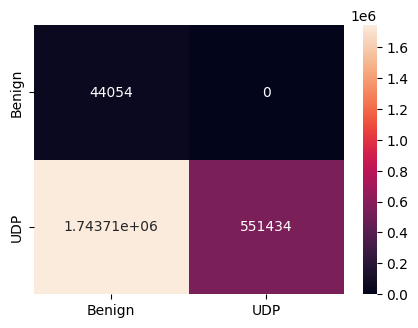





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  DT    0.994    0.949   0.9    0.949  0.923  0.847  0.949    0.067     0.35
 1  UDP           1    1     1  DT    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.029     0.204
 2  UDP           1    1     2  DT    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.016     0.314
 3  UDP           1    1     3  DT    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.016     0.282
 4  UDP           1    1     4  DT    0.883    0.832   0.555  0.832  0.569  0.173  0.832    0.047     0.346
 5  UDP           1    1     5  DT    0.883    0.832   0.555  0.832  0.569  0.173  0.832    0.031     0.298
 6  UDP           1    1     6  DT    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.019     0.299
 7  UDP           1    1 

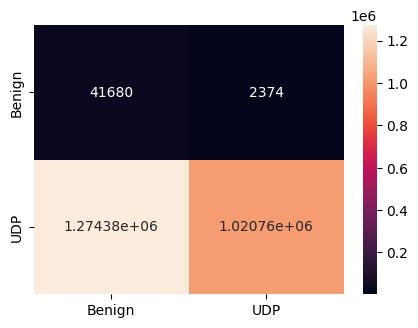





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.441     7.453
 1  UDP           1    1     1  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.456     6.952
 2  UDP           1    1     2  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.424     7.156
 3  UDP           1    1     3  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.424     7.471
 4  UDP           1    1     4  RF    0.894    0.946   0.575  0.946  0.602  0.236  0.946    0.457     6.811
 5  UDP           1    1     5  RF    0.897    0.947   0.577  0.947  0.606  0.243  0.947    0.471     6.606
 6  UDP           1    1     6  RF    0.255    0.62    0.512  0.62   0.218  0.012  0.62     0.331     7.029
 7  UDP           1    1

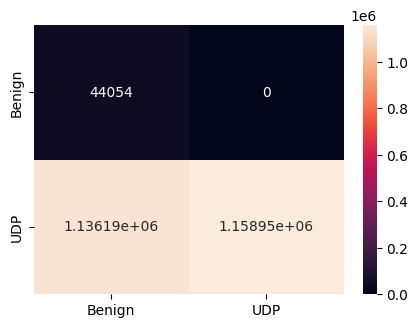





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.041   872.214
 1  UDP           1    1     1  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.063   897.308
 2  UDP           1    1     2  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.049   889.432
 3  UDP           1    1     3  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.063   875.621
 4  UDP           1    1     4  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.049   899.355
 5  UDP           1    1     5  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.063   888.705
 6  UDP           1    1     6  KNN   0.255     0.62   0.512   0.62  0.218  0.012   0.62    0.048  1004.54
 7  UDP           1    1 

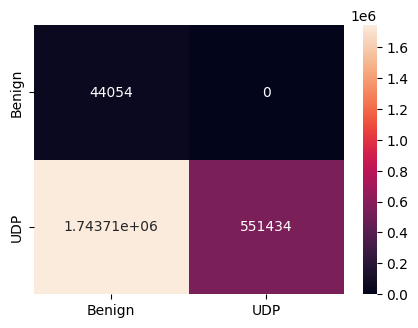





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     2.011
 1  UDP           1    1     1  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.888
 2  UDP           1    1     2  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.791
 3  UDP           1    1     3  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.965
 4  UDP           1    1     4  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.948
 5  UDP           1    1     5  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.015     1.871
 6  UDP           1    1     6  NB    0.996    0.897   0.998  0.897  0.941  0.883  0.897    0.016     1.729
 7  UDP           1    1

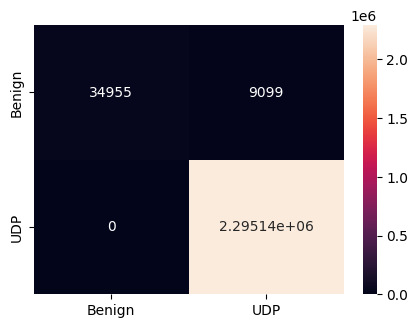





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  UDP           1    1     0  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62    7.624     4.042
 1  UDP           1    1     1  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62    7.737     4.186
 2  UDP           1    1     2  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62    8.205     4.327
 3  UDP           1    1     3  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62   10.701     4.721
 4  UDP           1    1     4  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62   15.616     4.5
 5  UDP           1    1     5  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62   22.728     4.861
 6  UDP           1    1     6  XGB   0.255     0.62   0.512   0.62  0.218  0.012   0.62   19.657     4.673
 7  UDP           1    1  

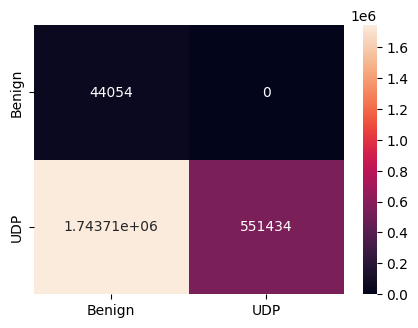





ARP
['Ether_type', 'IP_tos', 'IP_flags', 'IP_MF', 'IP_ttl', 'IP_proto', 'ICMP_type', 'TCP_reserved', 'TCP_ACK', 'TCP_ECE', 'TCP_CWR', 'UDP_len', 'DNS_qr', 'DNS_ra', 'DNS_qdcount', 'DNS_nscount', 'DNS_arcount', 'payload_bytes', 'entropy', 'Protocol', 'dst_IP_diversity', 'pck_size_diff', 'pck_size_mean_WE', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_std_WE', 'TCP_window_mean_WE', 'TCP_window_std_WE', 'TCP_window_sum_of_EW', 'payload_bytes_mean_WE', 'entropy_diff', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'entropy_mean_2', 'TCP_SYN_sum', 'TCP_RST_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_RST_ratio', 'TCP_PSH_ratio', 'TCP_CWR_ratio', 'TCP_RST_SR', 'TCP_PSH_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'TCP_window_std_6', 'payload_bytes_mean_6', 'payload_bytes_std_6', 'entropy_mean_6', 'entropy_std_6', 'pck_size_mean_9', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_std_9', 'TCP_SYN_R', 'Label']
  

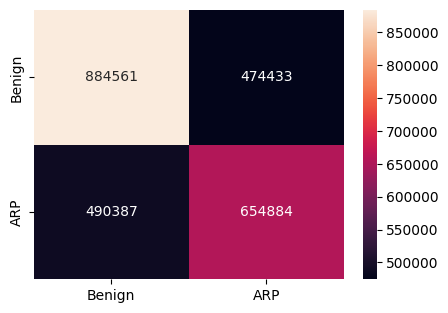





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  DT    0.525    0.508   0.509  0.508  0.495   0.016  0.508    0.644     0.944
 1  ARP           1    1     1  DT    0.532    0.51    0.514  0.51   0.486   0.022  0.51     0.655     1.257
 2  ARP           1    1     2  DT    0.506    0.467   0.263  0.467  0.336  -0.072  0.467    0.708     1.259
 3  ARP           1    1     3  DT    0.531    0.519   0.52   0.519  0.514   0.038  0.519    0.644     1.052
 4  ARP           1    1     4  DT    0.468    0.431   0.253  0.431  0.319  -0.147  0.431    0.755     1.117
 5  ARP           1    1     5  DT    0.532    0.545   0.548  0.545  0.527   0.086  0.545    0.721     1.193
 6  ARP           1    1     6  DT    0.537    0.495   0.27   0.495  0.349  -0.011  0.495    0.708     1.163
 7  ARP        

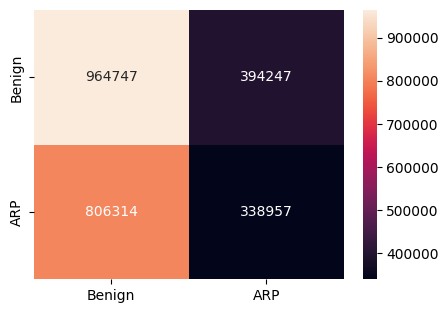





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  RF    0.527    0.486   0.268  0.486  0.345  -0.031  0.486   18.502    46.397
 1  ARP           1    1     1  RF    0.525    0.484   0.267  0.484  0.344  -0.034  0.484   18.653    45.901
 2  ARP           1    1     2  RF    0.526    0.485   0.268  0.485  0.345  -0.032  0.485   18.642    44.772
 3  ARP           1    1     3  RF    0.525    0.483   0.267  0.483  0.344  -0.036  0.483   18.96     45.463
 4  ARP           1    1     4  RF    0.525    0.484   0.267  0.484  0.344  -0.035  0.484   19.084    47.335
 5  ARP           1    1     5  RF    0.53     0.488   0.268  0.488  0.346  -0.026  0.488   19        46.504
 6  ARP           1    1     6  RF    0.528    0.487   0.268  0.487  0.346  -0.029  0.487   20.296    46.656
 7  ARP        

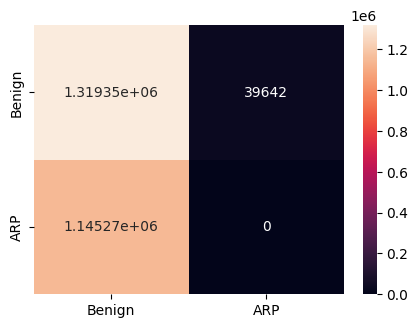





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.298    97.494
 1  ARP           1    1     1  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.315    99.601
 2  ARP           1    1     2  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.298    97.866
 3  ARP           1    1     3  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.315    97.162
 4  ARP           1    1     4  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.315    99.186
 5  ARP           1    1     5  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.298    99.031
 6  ARP           1    1     6  KNN   0.519    0.478   0.266  0.478  0.341  -0.048  0.478    0.299    97.583
 7  ARP        

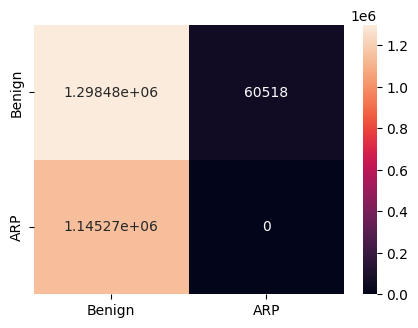





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.032     4.693
 1  ARP           1    1     1  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.023     4.883
 2  ARP           1    1     2  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.023     4.636
 3  ARP           1    1     3  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.032     5.222
 4  ARP           1    1     4  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.032     4.337
 5  ARP           1    1     5  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.016     4.395
 6  ARP           1    1     6  NB     0.49    0.451   0.259  0.451  0.329  -0.105  0.451    0.031     5.327
 7  ARP        

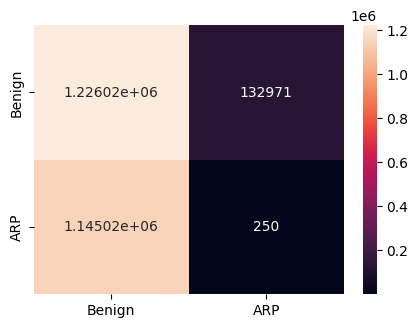





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  ARP           1    1     0  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.953     4.815
 1  ARP           1    1     1  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.849     4.923
 2  ARP           1    1     2  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.768     4.777
 3  ARP           1    1     3  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.938     4.813
 4  ARP           1    1     4  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.919     4.861
 5  ARP           1    1     5  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.927     4.801
 6  ARP           1    1     6  XGB   0.536    0.494    0.27  0.494  0.349  -0.013  0.494   11.928     4.831
 7  ARP        

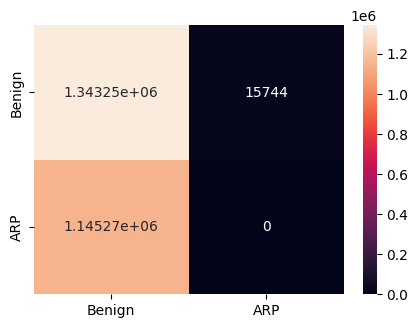





SP
['IP_flags', 'IP_DF', 'TCP_flags', 'TCP_SYN', 'entropy_sum_of_EW', 'TCP_SYN_sum', 'TCP_ACK_sum', 'TCP_SYN_ratio', 'TCP_ACK_SR', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063         0
 1  SP            1    1     1  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063         0
 2  SP            1    1     2  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063         0
 3  SP            1    1     3  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063         0
 4  SP            1    1     4  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.079         0
 5  SP            1    1     5  LR    0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.063   

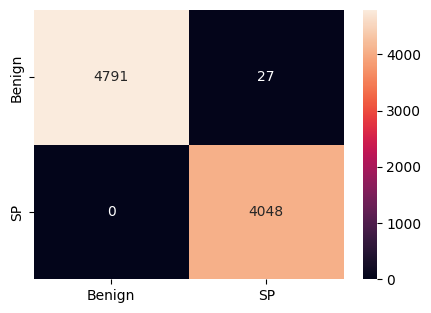





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  DT    0.863    0.873   0.884  0.873  0.862  0.729  0.873    0.009     0.001
 1  SP            1    1     1  DT    0.863    0.873   0.884  0.873  0.862  0.729  0.873    0.016     0
 2  SP            1    1     2  DT    0.995    0.995   0.994  0.995  0.995  0.989  0.995    0.019     0
 3  SP            1    1     3  DT    0.863    0.874   0.884  0.874  0.862  0.73   0.874    0.016     0
 4  SP            1    1     4  DT    0.994    0.995   0.994  0.995  0.994  0.989  0.995    0.016     0
 5  SP            1    1     5  DT    0.863    0.874   0.884  0.874  0.862  0.73   0.874    0         0
 6  SP            1    1     6  DT    0.82     0.803   0.872  0.803  0.806  0.625  0.803    0.016     0
 7  SP            1    1     7  DT    0.863    0

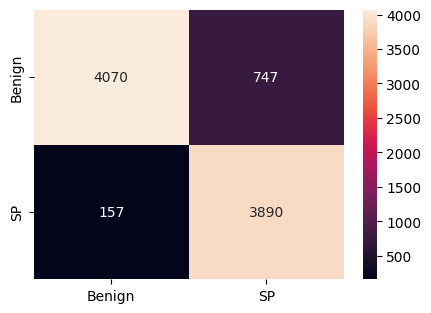





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  RF    0.863    0.874   0.885  0.874  0.863  0.73   0.874    0.016     0
 1  SP            1    1     1  RF    0.862    0.873   0.884  0.873  0.862  0.729  0.873    0.016     0
 2  SP            1    1     2  RF    0.863    0.874   0.884  0.874  0.862  0.73   0.874    0.016     0
 3  SP            1    1     3  RF    0.863    0.873   0.884  0.873  0.862  0.729  0.873    0         0.016
 4  SP            1    1     4  RF    0.863    0.874   0.885  0.874  0.863  0.73   0.874    0.003     0.014
 5  SP            1    1     5  RF    0.863    0.874   0.884  0.874  0.862  0.73   0.874    0         0
 6  SP            1    1     6  RF    0.862    0.873   0.884  0.873  0.862  0.729  0.873    0.013     0.003
 7  SP            1    1     7  RF    0.

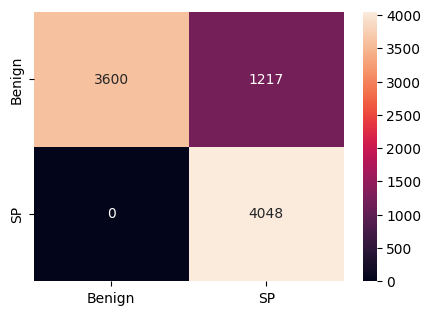





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.031     0.048
 1  SP            1    1     1  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.016     0.032
 2  SP            1    1     2  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.016     0.047
 3  SP            1    1     3  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.016     0.047
 4  SP            1    1     4  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.031     0.04
 5  SP            1    1     5  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.016     0.047
 6  SP            1    1     6  KNN   0.997    0.997   0.997  0.997  0.997  0.994  0.997    0.025     0.038
 7  SP            1    1 

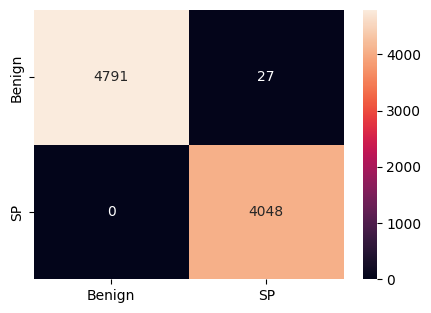





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 1  SP            1    1     1  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 2  SP            1    1     2  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 3  SP            1    1     3  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 4  SP            1    1     4  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 5  SP            1    1     5  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0
 6  SP            1    1     6  NB    0.972    0.974   0.971  0.974  0.971  0.943  0.974        0     0.016
 7  SP            1    1     7  NB    0.972    0

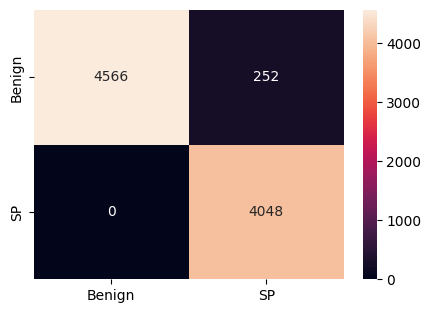





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SP            1    1     0  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.464     0.016
 1  SP            1    1     1  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.433     0.016
 2  SP            1    1     2  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.448     0.016
 3  SP            1    1     3  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.464     0.016
 4  SP            1    1     4  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.431     0.016
 5  SP            1    1     5  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.433     0.016
 6  SP            1    1     6  XGB   0.945    0.949   0.946  0.949  0.945   0.89  0.949    1.369     0.016
 7  SP            1    1

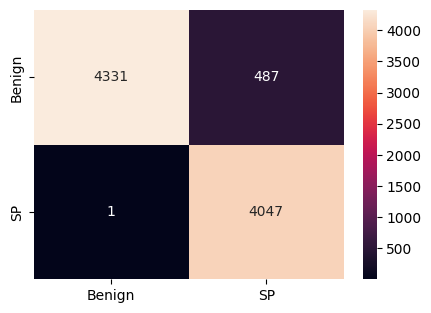





BF
['payload_bytes', 'pck_size_diff', 'TCP_window_diff', 'entropy_mean_WE', 'pck_size_mean_2', 'pck_size_std_2', 'TCP_window_mean_2', 'TCP_window_std_2', 'payload_bytes_mean_2', 'payload_bytes_std_2', 'sport_sum', 'TCP_FIN_sum', 'TCP_FIN_ratio', 'TCP_FIN_SR', 'pck_size_mean_6', 'ts_std_6', 'TCP_window_mean_6', 'TCP_window_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_std_9', 'TCP_window_mean_9', 'TCP_window_std_9', 'payload_bytes_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  LR    0.503    0.543   0.739  0.543  0.403  0.079  0.543    0.348         0
 1  BF            1    1     1  LR    0.506    0.546   0.74   0.546  0.409  0.085  0.546    0.267         0
 2  BF            1    1     2  LR    0.501    0.542   0.739 

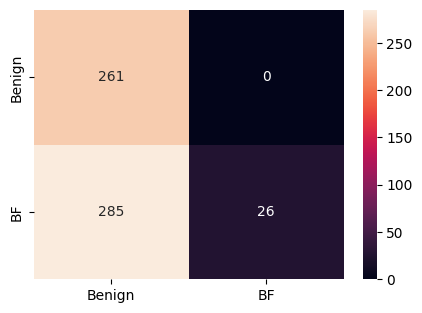





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  DT    0.457    0.502   0.728  0.502  0.317  0.003  0.502    0.037         0
 1  BF            1    1     1  DT    0.551    0.588   0.752  0.588  0.485  0.163  0.588    0.047         0
 2  BF            1    1     2  DT    0.455    0.5     0.228  0.5    0.313  0      0.5      0.047         0
 3  BF            1    1     3  DT    0.464    0.508   0.73   0.508  0.331  0.015  0.508    0.043         0
 4  BF            1    1     4  DT    0.457    0.502   0.728  0.502  0.317  0.003  0.502    0.047         0
 5  BF            1    1     5  DT    0.457    0.502   0.728  0.502  0.317  0.003  0.502    0.031         0
 6  BF            1    1     6  DT    0.455    0.5     0.228  0.5    0.313  0      0.5      0.047         0
 7  BF            1    1

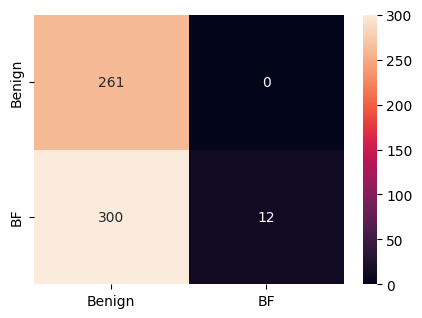





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.299     0.031
 1  BF            1    1     1  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.297     0.016
 2  BF            1    1     2  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.335     0.016
 3  BF            1    1     3  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.219     0.031
 4  BF            1    1     4  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.234     0.032
 5  BF            1    1     5  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.156     0.021
 6  BF            1    1     6  RF    0.457    0.502   0.728  0.502  0.317  0.003  0.502    2.219     0.031
 7  BF            1    1

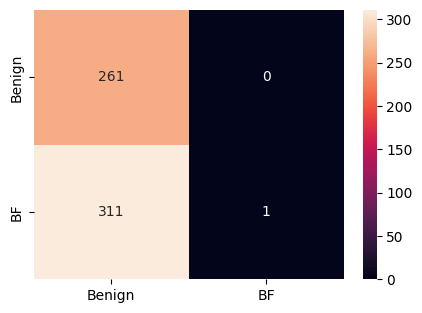





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec    F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  ----  -----  -----  -------  --------
 0  BF            1    1     0  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.043
 1  BF            1    1     1  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.026
 2  BF            1    1     2  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.039
 3  BF            1    1     3  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.031
 4  BF            1    1     4  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.047
 5  BF            1    1     5  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0         0.063
 6  BF            1    1     6  KNN   0.574    0.609   0.758  0.609  0.52  0.202  0.609    0.016     0.031
 7  BF            1    1     7  K

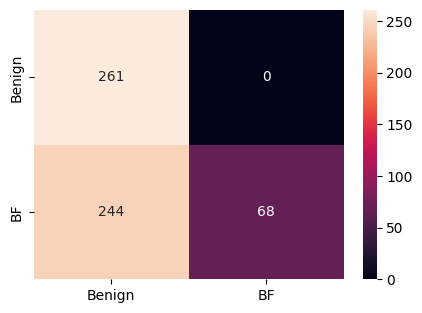





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0.006     0.001
 1  BF            1    1     1  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0.008     0
 2  BF            1    1     2  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0         0
 3  BF            1    1     3  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0         0
 4  BF            1    1     4  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0.016     0
 5  BF            1    1     5  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0.009     0
 6  BF            1    1     6  NB    0.745    0.766   0.821  0.766  0.738  0.509  0.766    0         0
 7  BF            1    1     7  NB    0.745    0

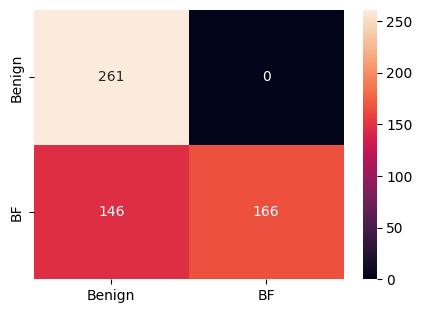





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  BF            1    1     0  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.207     0.005
 1  BF            1    1     1  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.152     0
 2  BF            1    1     2  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.072     0.016
 3  BF            1    1     3  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.026     0
 4  BF            1    1     4  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.087     0
 5  BF            1    1     5  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    2.173     0.016
 6  BF            1    1     6  XGB   0.455      0.5   0.228    0.5  0.313      0    0.5    4.532     0.014
 7  BF            1    1     7  XGB 

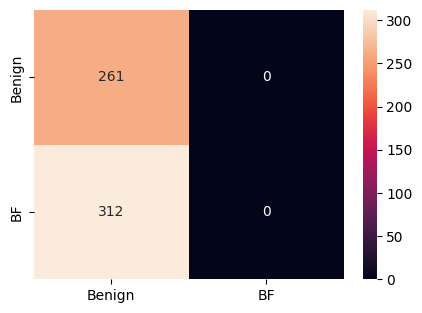





OS
['IP_ttl', 'TCP_flags', 'TCP_SYN', 'TCP_ACK', 'TCP_URG', 'TCP_ECE', 'TCP_window', 'TCP_urgptr', 'UDP_len', 'dport_class', 'Protocol', 'dst_IP_diversity', 'pck_size_sum_of_EW', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'TCP_window_mean_WE', 'TCP_window_sum_of_EW', 'payload_bytes_diff', 'payload_bytes_mean_WE', 'entropy_mean_WE', 'entropy_std_WE', 'entropy_sum_of_EW', 'payload_bytes_std_2', 'entropy_std_2', 'dport_sum', 'TCP_SYN_sum', 'TCP_PSH_sum', 'TCP_ACK_sum', 'TCP_FIN_ratio', 'TCP_PSH_ratio', 'TCP_ACK_ratio', 'TCP_URG_ratio', 'TCP_ECE_ratio', 'TCP_CWR_ratio', 'sum', 'TCP_FIN_SR', 'TCP_SYN_SR', 'TCP_ACK_SR', 'TCP_URG_SR', 'TCP_ECE_SR', 'TCP_CWR_SR', 'pck_size_mean_6', 'pck_size_std_6', 'ts_std_6', 'payload_bytes_std_6', 'entropy_mean_6', 'pck_size_std_9', 'ts_mean_9', 'payload_bytes_mean_9', 'entropy_mean_9', 'TCP_SYN_R', 'TCP_RST_R', 'TCP_PSH_R', 'TCP_ACK_R', 'TCP_ECE_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap   

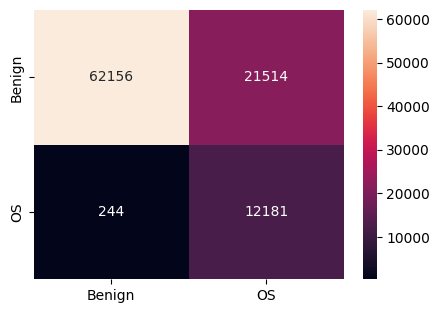





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  DT    0.587    0.756   0.616  0.756  0.536  0.218  0.756    0.073     0.027
 1  OS            1    1     1  DT    0.61     0.758   0.616  0.758  0.551  0.23   0.758    0.099     0.032
 2  OS            1    1     2  DT    0.61     0.758   0.616  0.758  0.551  0.23   0.758    0.09      0.03
 3  OS            1    1     3  DT    0.587    0.756   0.616  0.756  0.536  0.218  0.756    0.08      0.04
 4  OS            1    1     4  DT    0.61     0.758   0.616  0.758  0.551  0.23   0.758    0.098     0.033
 5  OS            1    1     5  DT    0.587    0.756   0.616  0.756  0.536  0.218  0.756    0.087     0.03
 6  OS            1    1     6  DT    0.587    0.756   0.616  0.756  0.536  0.218  0.756    0.083     0.03
 7  OS            1    1    

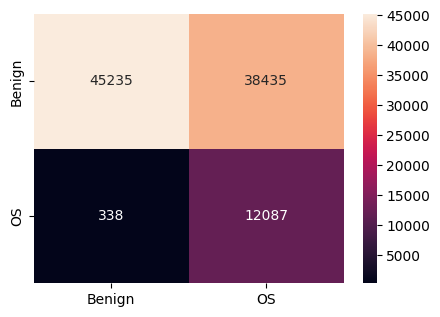





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS            1    1     0  RF    0.883    0.589   0.778  0.589  0.617   0.254  0.589    0.025     0.063
 1  OS            1    1     1  RF    0.877    0.589   0.731  0.589  0.614   0.245  0.589    0.04      0.1
 2  OS            1    1     2  RF    0.638    0.435   0.463  0.435  0.438  -0.088  0.435    0.038     0.054
 3  OS            1    1     3  RF    0.611    0.758   0.616  0.758  0.552   0.23   0.758    0.033     0.064
 4  OS            1    1     4  RF    0.944    0.93    0.856  0.93   0.887   0.775  0.93     0.03      0.065
 5  OS            1    1     5  RF    0.881    0.588   0.764  0.588  0.615   0.25   0.588    0.024     0.058
 6  OS            1    1     6  RF    0.894    0.612   0.855  0.612  0.651   0.322  0.612    0.038     0.06
 7  OS            

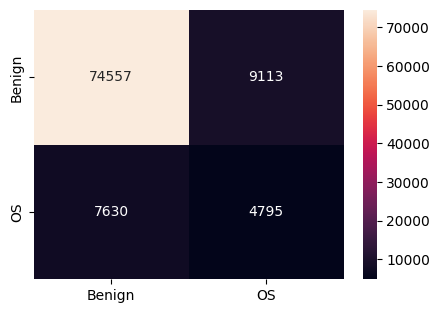





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1     kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  ------  -----  -------  --------
 0  OS            1    1     0  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0         8.257
 1  OS            1    1     1  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.006     8.054
 2  OS            1    1     2  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.009     7.694
 3  OS            1    1     3  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.011     7.609
 4  OS            1    1     4  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.01      7.762
 5  OS            1    1     5  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.005     7.646
 6  OS            1    1     6  KNN   0.785    0.464   0.452  0.464  0.457  -0.082  0.464    0.01      7.39
 7  OS          

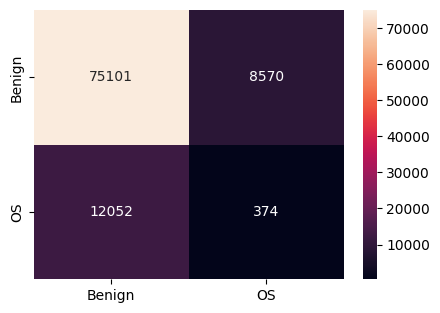





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.017     0.188
 1  OS            1    1     1  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.015     0.175
 2  OS            1    1     2  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.02      0.168
 3  OS            1    1     3  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.012     0.188
 4  OS            1    1     4  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.017     0.169
 5  OS            1    1     5  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.02      0.186
 6  OS            1    1     6  NB    0.724    0.449   0.459  0.449  0.453  -0.09  0.449    0.019     0.174
 7  OS            1    1

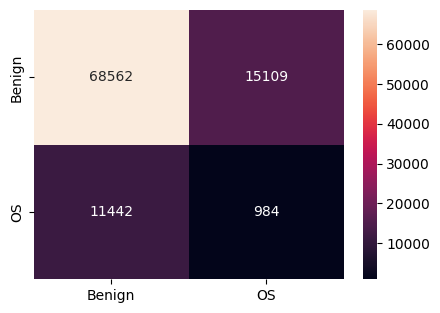





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  OS            1    1     0  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.08      0.224
 1  OS            1    1     1  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.122     0.253
 2  OS            1    1     2  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.05      0.249
 3  OS            1    1     3  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.04      0.27
 4  OS            1    1     4  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.022     0.277
 5  OS            1    1     5  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.026     0.244
 6  OS            1    1     6  XGB    0.61    0.758   0.616  0.758  0.551   0.23  0.758    1.002     0.287
 7  OS            1    1 

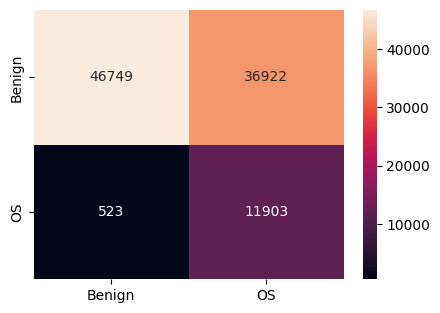





SCHD
['Ether_type', 'IP_version', 'IP_DF', 'IP_ttl', 'TCP_flags', 'TCP_options', 'dport_class', 'Protocol', 'IP_add_count', 'pck_size_mean_WE', 'pck_size_std_WE', 'ts_diff', 'ts_mean_WE', 'ts_std_WE', 'TCP_window_mean_WE', 'payload_bytes_mean_WE', 'payload_bytes_std_WE', 'payload_bytes_sum_of_EW', 'entropy_mean_WE', 'entropy_std_WE', 'pck_size_mean_2', 'ts_std_2', 'TCP_ACK_sum', 'TCP_ACK_ratio', 'TCP_ACK_SR', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_PSH_R', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  LR    0.989    0.971   0.583  0.971  0.639  0.281  0.971    0.34      0.011
 1  SCHD          1    1     1  LR    0.989    0.971   0.583  0.971  0.639  0.281  0.971    0.283     0.01
 2  SCHD          1    1     2  LR    0.989    0

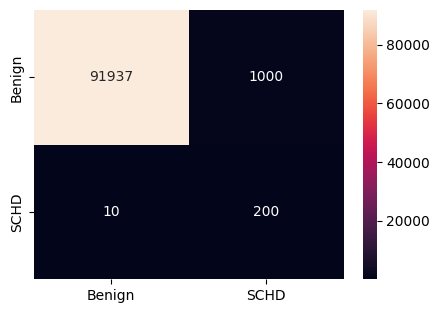





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  DT    0.998    0.619   0.902  0.619  0.683  0.367  0.619    0.051     0.025
 1  SCHD          1    1     1  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.06      0.02
 2  SCHD          1    1     2  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.05      0.025
 3  SCHD          1    1     3  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.06      0.02
 4  SCHD          1    1     4  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.07      0.021
 5  SCHD          1    1     5  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.053     0.025
 6  SCHD          1    1     6  DT    0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.058     0.017
 7  SCHD          1    1  

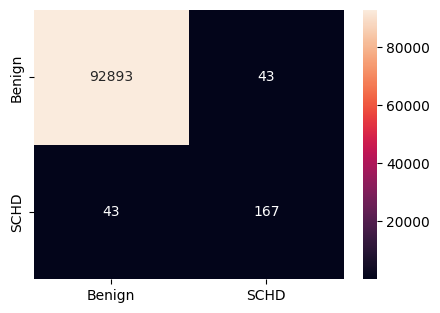





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  RF    0.998    0.616   0.778  0.616  0.664  0.328  0.616    1.172     0.523
 1  SCHD          1    1     1  RF    0.998    0.614   0.886  0.614  0.676  0.352  0.614    1.111     0.527
 2  SCHD          1    1     2  RF    0.998    0.612   0.943  0.612  0.678  0.357  0.612    1.133     0.508
 3  SCHD          1    1     3  RF    0.998    0.614   0.823  0.614  0.669  0.337  0.614    1.142     0.502
 4  SCHD          1    1     4  RF    0.998    0.617   0.907  0.617  0.681  0.362  0.617    1.186     0.566
 5  SCHD          1    1     5  RF    0.998    0.707   0.884  0.707  0.769  0.538  0.707    1.122     0.556
 6  SCHD          1    1     6  RF    0.998    0.614   0.944  0.614  0.681  0.363  0.614    1.13      0.549
 7  SCHD          1    1

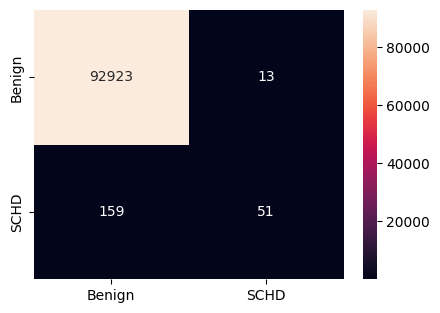





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.078     1.885
 1  SCHD          1    1     1  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.078     1.854
 2  SCHD          1    1     2  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.08      1.914
 3  SCHD          1    1     3  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.077     1.906
 4  SCHD          1    1     4  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.073     1.889
 5  SCHD          1    1     5  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.072     1.964
 6  SCHD          1    1     6  KNN   0.998    0.676   0.968  0.676  0.756  0.512  0.676    0.078     1.913
 7  SCHD          1    1

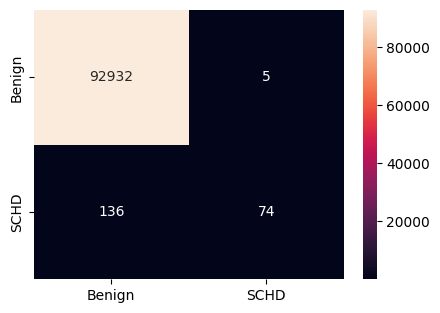





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.008     0.117
 1  SCHD          1    1     1  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.01      0.116
 2  SCHD          1    1     2  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.016     0.109
 3  SCHD          1    1     3  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.013     0.1
 4  SCHD          1    1     4  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.008     0.121
 5  SCHD          1    1     5  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.008     0.135
 6  SCHD          1    1     6  NB    0.995    0.997   0.647  0.997  0.726  0.453  0.997    0.009     0.108
 7  SCHD          1    1  

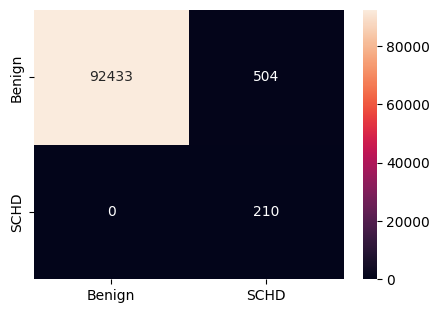





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  SCHD          1    1     0  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    1.007     0.192
 1  SCHD          1    1     1  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.898     0.194
 2  SCHD          1    1     2  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.971     0.194
 3  SCHD          1    1     3  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.96      0.17
 4  SCHD          1    1     4  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    0.888     0.184
 5  SCHD          1    1     5  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    1.04      0.178
 6  SCHD          1    1     6  XGB   0.999    0.928   0.896  0.928  0.912  0.823  0.928    1.082     0.161
 7  SCHD          1    1 

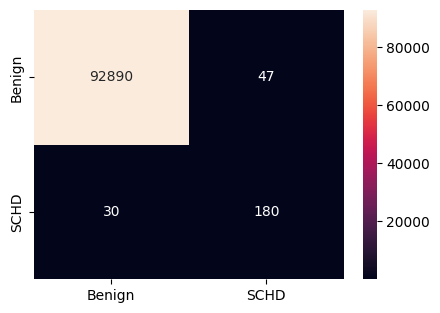





MHDis
['IP_ihl', 'IP_ttl', 'TCP_options', 'sport_class', 'Protocol', 'pck_size_std_WE', 'pck_size_sum_of_EW', 'ts_mean_WE', 'ts_std_WE', 'ts_sum_of_EW', 'pck_size_mean_2', 'ts_mean_2', 'TCP_ACK_sum', 'sum', 'pck_size_mean_6', 'ts_mean_6', 'ts_std_6', 'ts_mean_9', 'ts_std_9', 'TCP_ACK_R', 'Label']
    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  LR        1        1   0.997      1  0.998  0.997      1    0.188     0
 1  MHDis         1    1     1  LR        1        1   0.997      1  0.998  0.997      1    0.346     0.005
 2  MHDis         1    1     2  LR        1        1   0.997      1  0.998  0.997      1    0.158     0
 3  MHDis         1    1     3  LR        1        1   0.997      1  0.998  0.997      1    0.263     0
 4  MHDis         1    1     4  LR        1        1   0.997  

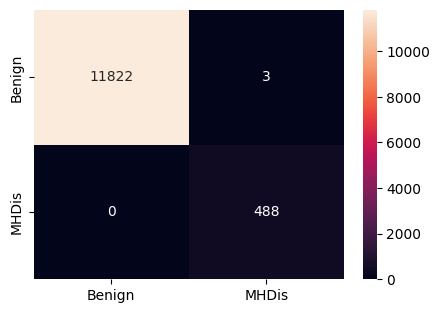





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  DT    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.022     0
 1  MHDis         1    1     1  DT    0.964    0.55    0.972  0.55   0.582  0.176  0.55     0.017     0.008
 2  MHDis         1    1     2  DT    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.017     0.005
 3  MHDis         1    1     3  DT    0.964    0.55    0.972  0.55   0.582  0.176  0.55     0.019     0.005
 4  MHDis         1    1     4  DT    0.97     0.623   0.981  0.623  0.689  0.384  0.623    0.015     0.008
 5  MHDis         1    1     5  DT    0.964    0.55    0.972  0.55   0.582  0.176  0.55     0.019     0
 6  MHDis         1    1     6  DT    0.998    0.977   0.998  0.977  0.987  0.975  0.977    0.017     0
 7  MHDis         1    1     7  DT  

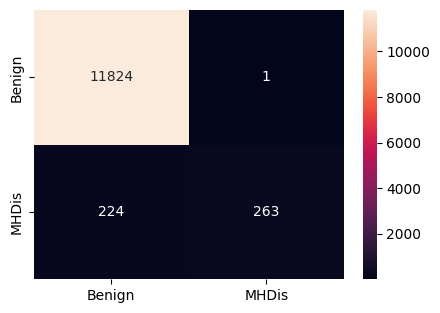





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.485     0.075
 1  MHDis         1    1     1  RF    0.998    0.976   0.998  0.976  0.987  0.974  0.976    0.465     0.073
 2  MHDis         1    1     2  RF    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.467     0.07
 3  MHDis         1    1     3  RF    0.998    0.975   0.998  0.975  0.986  0.973  0.975    0.47      0.07
 4  MHDis         1    1     4  RF    0.996    0.953   0.997  0.953  0.974  0.948  0.953    0.489     0.07
 5  MHDis         1    1     5  RF    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.482     0.08
 6  MHDis         1    1     6  RF    0.998    0.974   0.998  0.974  0.986  0.972  0.974    0.5       0.07
 7  MHDis         1    1     

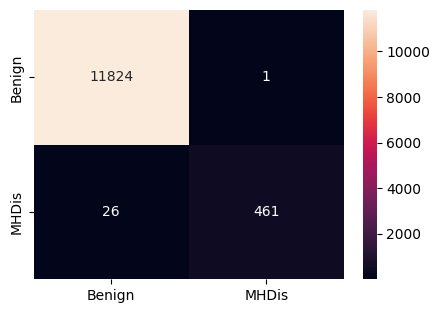





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.02      0.47
 1  MHDis         1    1     1  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.02      0.432
 2  MHDis         1    1     2  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.027     0.488
 3  MHDis         1    1     3  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.017     0.5
 4  MHDis         1    1     4  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.027     0.49
 5  MHDis         1    1     5  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.028     0.472
 6  MHDis         1    1     6  KNN   0.999    0.999   0.987  0.999  0.993  0.986  0.999    0.03      0.453
 7  MHDis         1    1    

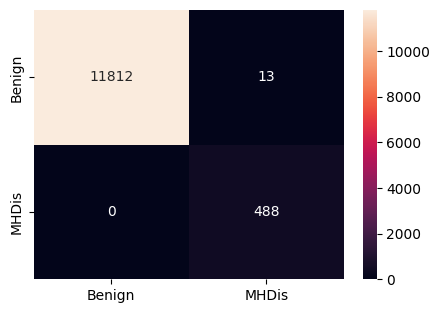





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.008     0.008
 1  MHDis         1    1     1  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.007     0.008
 2  MHDis         1    1     2  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.004     0.013
 3  MHDis         1    1     3  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.008     0.008
 4  MHDis         1    1     4  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.003     0.008
 5  MHDis         1    1     5  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.01      0.006
 6  MHDis         1    1     6  NB    0.964    0.981    0.76  0.981  0.833  0.668  0.981    0.01      0.01
 7  MHDis         1    1 

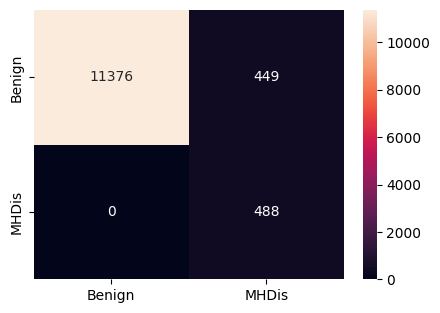





    Dataset      SW    T    CV  ML      Acc    b_Acc    Prec    Rec     F1    kap    ROC    tra-T    test-T
--  ---------  ----  ---  ----  ----  -----  -------  ------  -----  -----  -----  -----  -------  --------
 0  MHDis         1    1     0  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.637     0.024
 1  MHDis         1    1     1  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.68      0.022
 2  MHDis         1    1     2  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.714     0.083
 3  MHDis         1    1     3  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.588     0.093
 4  MHDis         1    1     4  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.481     0.053
 5  MHDis         1    1     5  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.577     0.087
 6  MHDis         1    1     6  XGB   0.979    0.732   0.987  0.732  0.811  0.623  0.732    4.891     0.113
 7  MHDis         1    1

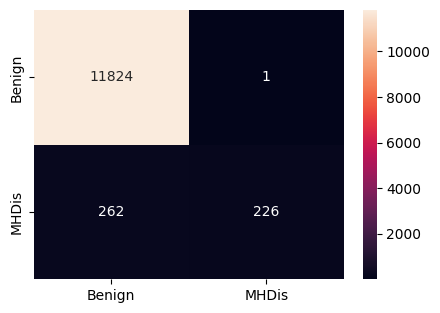

In [21]:
folder("results/test/")

for file in file_list:
    print(file)
    #if "UDP" in file:        feature=feature_list["UDP"]
    #else:        feature=feature_list[file]
    feature=feature_list[file]
    train=file_list[file][0]
    test=file_list[file][1]
    #feature,_=GA(train,test,features,gen_number=25,outputcsv=f"{file}_DT_chosed_GA_output.csv")
    print(feature)
    output_csv=f"./results/test/{file}_TEST_chosed_output_ML_.csv"
    target_names=["Benign",file]
    ML(train,test,output_csv,feature,file,1)  


In [22]:
print(2)

2


In [ ]:
files_add=find_the_way("./results/test/","_.csv")
files_add

results=[['Attack', 'ML','Acc', 'b_Acc', 'Prec', 'Rec',
       'F1', 'kap', 'ROC', 'tra-T', 'test-T']]


    
for i in tqdm(files_add):
    df=pd.read_csv(i)
    temp=df.values
    df=df.mean()
    df=list(df.values)
    temp=[temp[0][0],temp[0][4]]
    temp=temp+df[3:]
    results.append(temp)
results = pd.DataFrame (results[1:], columns = results[0])
results.to_csv("MEAN-resluts.csv",index=False)
print (tabulate(results, headers=list(results.columns)))

In [ ]:
df=pd.read_csv("MEAN-resluts.csv")
bos=pd.DataFrame()
for i in df["Attack"].unique():
    small=df[df["Attack"]==i]
    bos[i]=small["F1"].values
    print(i)
bos.to_csv("tablo.csv",index=False)